In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from datetime import datetime, timedelta

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        df = df['Adj Close']
        data_dict[ticker] = df

# Combine into a single DataFrame
prices = pd.DataFrame(data_dict)
prices = prices.dropna()  # Simple approach to drop days with missing data
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  ^CNXIT     ^CNXAUTO      ^NSEBANK      ^CNXFMCG  \
Date                                                                
2020-02-11  16452.300781  7892.399902  31300.236328  30414.550781   
2020-02-12  16538.099609  7933.799805  31492.535156  30986.250000   
2020-02-13  16673.050781  7914.899902  31229.886719  31039.300781   
2020-02-14  16642.750000  7822.200195  30834.443359  30646.750000   
2020-02-17  16647.699219  7770.500000  30680.341797  30481.050781   

              ^CNXMEDIA    ^CNXMETAL      ^CNXPSE       ^CNXMNC    ^CNXINFRA  \
Date                                                                           
2020-02-11  1827.449951  2651.750000  3061.300049  14066.400391  3281.100098   
2020-02-12  1824.199951  2668.250000  3051.899902  14174.049805  3290.149902   
2020-02-13  1834.849976  2651.600098  3029.949951  14251.349609  3281.850098   
2020-02-14  1832.500000  2613.600098  2977.850098  14076.950195  3279.899902   
2020-02-17  1812.250000  2586.699951

In [39]:
def add_technical_indicators(df):
    # Example: Add 20-day EMA, RSI (14), MACD, and Bollinger Bands
    df['EMA20'] = ta.ema(df, length=20)
    df['RSI14'] = ta.rsi(df, length=14)
    
    # MACD: returns three columns: MACD, Signal, and Histogram
    macd = ta.macd(df)
    df = df.join(macd)
    
    # Bollinger Bands (default: 20-period and 2 std)
    bb = ta.bbands(df)
    df = df.join(bb)
    
    return df

In [44]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Annualized mean return and volatility
annualized_return = returns.mean() * 252
annualized_vol = returns.std() * np.sqrt(252)

# Covariance matrix (annualized)
cov_matrix = returns.cov() * 252

print("Annualized Returns:\n", annualized_return)
print("Annualized Volatility:\n", annualized_vol)
print("Covariance Matrix:\n", cov_matrix)

Annualized Returns:
 ^CNXIT         0.227106
^CNXAUTO       0.254127
^NSEBANK       0.131304
^CNXFMCG       0.137544
^CNXMEDIA      0.023679
^CNXMETAL      0.291688
^CNXPSE        0.253644
^CNXMNC        0.149150
^CNXINFRA      0.211840
^CNXREALTY     0.267751
^CNXENERGY     0.187000
^CNXPSUBANK    0.263097
^CNXSERVICE    0.140924
dtype: float64
Annualized Volatility:
 ^CNXIT         0.241091
^CNXAUTO       0.240902
^NSEBANK       0.258958
^CNXFMCG       0.172021
^CNXMEDIA      0.310558
^CNXMETAL      0.312138
^CNXPSE        0.253425
^CNXMNC        0.166980
^CNXINFRA      0.206140
^CNXREALTY     0.311530
^CNXENERGY     0.237975
^CNXPSUBANK    0.339139
^CNXSERVICE    0.212309
dtype: float64
Covariance Matrix:
                ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG  ^CNXMEDIA  ^CNXMETAL  \
^CNXIT       0.058125  0.028765  0.028469  0.019873   0.030067   0.035100   
^CNXAUTO     0.028765  0.058034  0.043389  0.023283   0.044192   0.047371   
^NSEBANK     0.028469  0.043389  0.067059  0.02273

In [50]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# 1. Function to convert correlation matrix to a distance matrix
def correl_distance(corr):
    """
    Convert a correlation matrix to a distance matrix using:
       distance = sqrt((1 - corr) / 2)
    """
    dist = np.sqrt((1 - corr) / 2)
    return dist

# 2. Function to get quasi-diagonal ordering of assets from linkage matrix
def get_quasi_diag(link):
    """
    Sort clustered items by distance to generate a quasi-diagonal ordering.
    This function uses pd.concat() instead of .append() to work with newer pandas versions.
    """
    # Convert the linkage matrix to integer type for indexing
    link = link.astype(int)
    # Initialize the sorted index series with the two indices from the last (root) linkage
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # Total number of original items
    while sort_ix.max() >= num_items:
        # Reset the index to allow insertion at the correct positions
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        # Find the first element that is a cluster (i.e., its value >= num_items)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index[0]
        j = sort_ix[i]
        # Replace the cluster index with its first child from the linkage matrix
        sort_ix[i] = link[j - num_items, 0]
        # Create a new Series with the second child
        new_series = pd.Series([link[j - num_items, 1]], index=[i + 1])
        # Concatenate the new value
        sort_ix = pd.concat([sort_ix, new_series])
        # Sort by index to maintain the correct order
        sort_ix = sort_ix.sort_index()
    return list(sort_ix.astype(int))

# 3. Function to compute the variance of a given cluster from the covariance matrix
def get_cluster_variance(cov, cluster):
    """
    Compute the variance for a cluster of assets.
    """
    sub_cov = cov.iloc[cluster, cluster]
    w = np.repeat(1, len(cluster)) / len(cluster)
    variance = np.dot(w, np.dot(sub_cov, w))
    return variance

# 4. Recursive bisection to assign weights based on the clustering
def get_recursive_bisection(cov, sort_ix):
    """
    Compute the HRP weights using recursive bisection on the sorted index list.
    """
    # Start with equal weights for each asset
    weights = pd.Series(1, index=sort_ix)
    clusters = [sort_ix]
    while len(clusters) > 0:
        # Only work with clusters that have more than one asset
        clusters = [cluster for cluster in clusters if len(cluster) > 1]
        temp_clusters = []
        for cluster in clusters:
            split = int(len(cluster) / 2)
            cluster1 = cluster[:split]
            cluster2 = cluster[split:]
            # Compute the variance of each cluster
            var1 = get_cluster_variance(cov, cluster1)
            var2 = get_cluster_variance(cov, cluster2)
            # Determine the allocation factor for the two clusters
            alpha = 1 - var1 / (var1 + var2)
            weights.loc[cluster1] *= alpha
            weights.loc[cluster2] *= (1 - alpha)
            temp_clusters += [cluster1, cluster2]
        clusters = temp_clusters
    return weights.sort_index()

# ----------------------
# Example usage:
# Assume 'returns' is a DataFrame of asset returns (e.g., sector returns)
# For instance, if you already have a DataFrame 'prices' from yfinance:
# returns = prices.pct_change().dropna()

# 5. Compute the correlation matrix from returns
corr = returns.corr()

# 6. Convert the correlation matrix to a distance matrix
dist = correl_distance(corr)

# 7. Generate the linkage matrix using the distance matrix
link = linkage(squareform(dist), method='single')

# 8. Get the quasi-diagonal sorted order of indices from the linkage matrix
sort_ix = get_quasi_diag(link)

# 9. Compute the covariance matrix (annualized if desired; here, just using raw cov)
cov_matrix = returns.cov()  # Multiply by 252 if annualizing daily returns

# 10. Calculate HRP weights using recursive bisection
hrp_weights = get_recursive_bisection(cov_matrix, sort_ix)

# Output the sorted indices and the computed HRP weights
print("Sorted Indices:", sort_ix)
print("HRP Weights:\n", hrp_weights)

Sorted Indices: [4, 0, 11, 9, 5, 3, 1, 2, 12, 7, 6, 8, 10]
HRP Weights:
 0     0.089875
1     0.118818
2     0.051639
3     0.127655
4     0.079139
5     0.038771
6     0.050038
7     0.115257
8     0.075195
9     0.074948
10    0.056422
11    0.045420
12    0.076825
dtype: float64


C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\2471898766.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.45580757 0.45580757 0.45580757 0.45580757 0.45580757 0.45580757]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha


In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta  # Ensure you have pandas_ta installed: pip install pandas_ta
from datetime import datetime, timedelta

# -----------------------------
# (0) Data Fetching and Setup (as provided)

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        # Use 'Adj Close' as the price column
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict)
prices = prices.dropna()
print(prices.head())

# -----------------------------
# Revised Technical Indicator Function

def add_technical_indicators(df):
    """
    Compute technical indicators using the price series.
    Assumes the DataFrame has a column 'Adj Close' (or uses the first column).
    """
    # Use the 'Adj Close' column (or first column if not available)
    if 'Adj Close' in df.columns:
        close = df['Adj Close']
    else:
        close = df.iloc[:, 0]
        
    # Calculate a 20-day EMA and 14-day RSI
    df['EMA20'] = ta.ema(close, length=20)
    df['RSI14'] = ta.rsi(close, length=14)
    
    # Calculate MACD; this returns a DataFrame with columns like "MACD_12_26_9", "MACDs_12_26_9", etc.
    macd = ta.macd(close)
    if macd is not None:
        df = df.join(macd)
    
    # Calculate Bollinger Bands; this returns a DataFrame with columns like "BBL_20_2.0", "BBM_20_2.0", "BBU_20_2.0"
    bb = ta.bbands(close)
    if bb is not None:
        df = df.join(bb)
    
    return df

# -----------------------------
# (e) Machine Learning for Future Prediction

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def prepare_ml_data(df):
    """
    Prepare feature and target data for ML.
    Assumes that 'df' already contains technical indicators.
    The target is defined as the next-day return computed on 'Adj Close'.
    """
    df = df.copy()
    # Calculate next-day return (as a percentage change)
    df['Return'] = df['Adj Close'].pct_change().shift(-1)
    # Drop rows with missing values (from indicator calculations and the return)
    df = df.dropna()
    
    # Define the feature columns.
    # Adjust these names if your pandas_ta version produces slightly different column names.
    feature_cols = ['EMA20', 'RSI14', 'MACD_12_26_9', 'MACDs_12_26_9']
    X = df[feature_cols]
    y = df['Return']
    return X, y

# Build ML model for one sector (example: "^CNXIT")
# Create a DataFrame for the sector and rename the price column to "Adj Close" if needed
df_sector = pd.DataFrame(prices["^CNXIT"]).rename(columns={"^CNXIT": "Adj Close"})
# Add technical indicators
df_sector = add_technical_indicators(df_sector)

# Prepare features and target
X, y = prepare_ml_data(df_sector)

# Split the data (keeping time order, so no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model performance (R^2 score on the test set)
score = rf_model.score(X_test, y_test)
print(f"Random Forest Model R^2 Score for ^CNXIT: {score:.4f}")

# Predict next-day return using the latest available feature values
latest_features = X.iloc[[-1]]  # Get the most recent row of features
predicted_return = rf_model.predict(latest_features)
print(f"Predicted Next-Day Return for ^CNXIT: {predicted_return[0]:.4%}")

# -----------------------------
# (f) Rebalancing & Optimization Logic

# For demonstration, we will create dummy ML predictions and technical signals for each sector.
# In a real implementation, you would train (or use a multi-output model) per sector.

# Create dummy ML predictions (for example, between -1% and +1%)
ml_predictions = {ticker: np.random.uniform(-0.01, 0.01) for ticker in sector_tickers}

# Create dummy technical signals (multiplicative adjustments based on technical criteria)
# For simplicity, we'll assign a neutral factor of 1.0 for each sector.
technical_signals = {ticker: 1.0 for ticker in sector_tickers}

print("\nDummy ML Predictions:")
print(ml_predictions)

# --- Mapping HRP Weights to Ticker Names ---
# (Assuming your HRP code produced a Series 'hrp_weights' whose indices match the order of returns.columns.)
# Map these weights to a dictionary using the ticker order from 'prices' (or 'returns').
tickers = list(returns.columns)
hrp_weight_dict = {ticker: hrp_weights.iloc[i] for i, ticker in enumerate(tickers)}
print("\nHRP Weights (Baseline):")
print(hrp_weight_dict)

# --- Combine HRP Weights with ML Predictions and Technical Signals ---
# Choose a scaling factor to control the influence of ML predictions.
scaling_factor = 10  # For example, a prediction of +0.01 (1%) increases the weight by ~10%

adjusted_weights = {}
for ticker in sector_tickers:
    base_weight = hrp_weight_dict.get(ticker, 0)
    ml_pred = ml_predictions.get(ticker, 0)
    tech_signal = technical_signals.get(ticker, 1)
    # Adjust the weight using a simple multiplicative rule:
    # New Weight = Base Weight * (1 + scaling_factor * ml_pred) * tech_signal
    adjusted_weight = base_weight * (1 + scaling_factor * ml_pred) * tech_signal
    adjusted_weights[ticker] = adjusted_weight

# Normalize the adjusted weights so they sum to 1
total_weight = sum(adjusted_weights.values())
for ticker in adjusted_weights:
    adjusted_weights[ticker] /= total_weight

print("\nAdjusted Portfolio Weights based on HRP, ML Predictions, and Technical Signals:")
for ticker, weight in adjusted_weights.items():
    print(f"{ticker}: {weight:.2%}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                  ^CNXIT     ^CNXAUTO      ^NSEBANK      ^CNXFMCG  \
Date                                                                
2020-02-11  16452.300781  7892.399902  31300.236328  30414.550781   
2020-02-12  16538.099609  7933.799805  31492.535156  30986.250000   
2020-02-13  16673.050781  7914.899902  31229.886719  31039.300781   
2020-02-14  16642.750000  7822.200195  30834.443359  30646.750000   
2020-02-17  16647.699219  7770.500000  30680.341797  30481.050781   

              ^CNXMEDIA    ^CNXMETAL      ^CNXPSE       ^CNXMNC    ^CNXINFRA  \
Date                                                                           
2020-02-11  1827.449951  2651.750000  3061.300049  14066.400391  3281.100098   
2020-02-12  1824.199951  2668.250000  3051.899902  14174.049805  3290.149902   
2020-02-13  1834.849976  2651.600098  3029.949951  14251.349609  3281.850098   
2020-02-14  1832.500000  2613.600098  2977.850098  14076.950195  3279.899902   
2020-02-17  1812.250000  2586.699951

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Price Data (first 5 rows):
                  ^CNXIT     ^CNXAUTO      ^NSEBANK      ^CNXFMCG  \
Date                                                                
2020-02-11  16452.300781  7892.399902  31300.236328  30414.550781   
2020-02-12  16538.099609  7933.799805  31492.535156  30986.250000   
2020-02-13  16673.050781  7914.899902  31229.886719  31039.300781   
2020-02-14  16642.750000  7822.200195  30834.443359  30646.750000   
2020-02-17  16647.699219  7770.500000  30680.341797  30481.050781   

              ^CNXMEDIA    ^CNXMETAL      ^CNXPSE       ^CNXMNC    ^CNXINFRA  \
Date                                                                           
2020-02-11  1827.449951  2651.750000  3061.300049  14066.400391  3281.100098   
2020-02-12  1824.199951  2668.250000  3051.899902  14174.049805  3290.149902   
2020-02-13  1834.849976  2651.600098  3029.949951  14251.349609  3281.850098   
2020-02-14  1832.500000  2613.600098  2977.850098  14076.950195  3279.899902   
2020-02-1

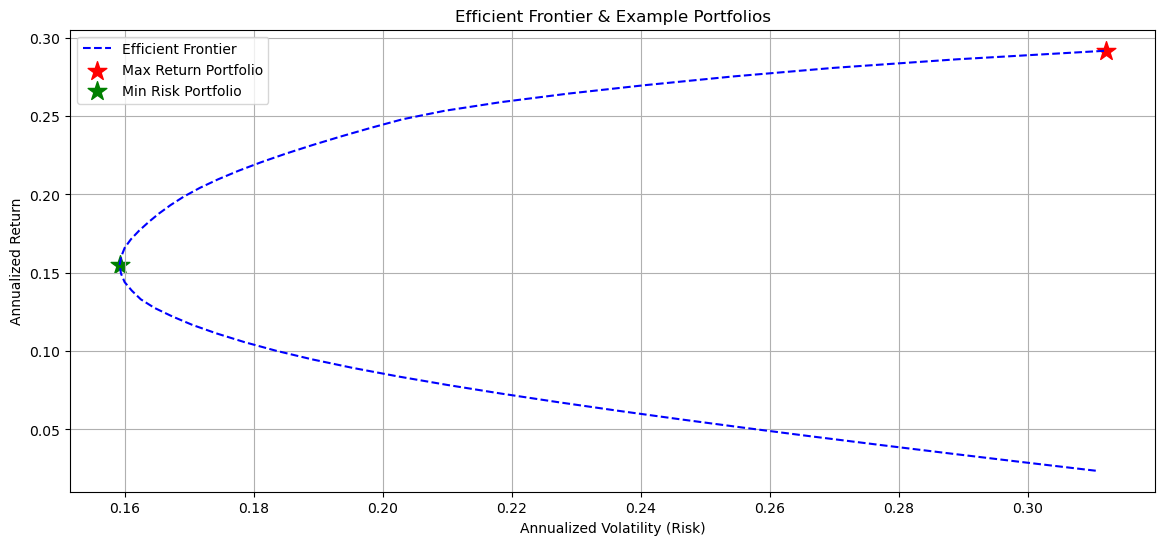

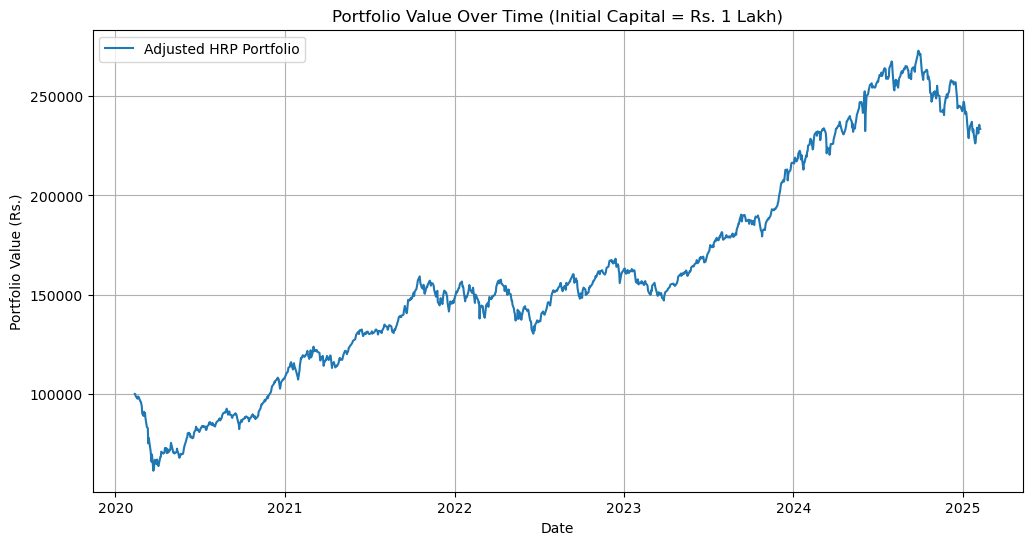


Final Portfolio Value (Adjusted HRP Portfolio): Rs. 233,432.33


In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta  # pip install pandas_ta
from datetime import datetime, timedelta

# -----------------------------
# (0) Data Fetching and Setup

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict)
prices = prices.dropna()
print("Price Data (first 5 rows):")
print(prices.head())

# Compute daily returns
returns = prices.pct_change().dropna()

# Annualized metrics (for later use)
annualized_return = returns.mean() * 252
annualized_vol = returns.std() * np.sqrt(252)
cov_matrix_daily = returns.cov()
cov_matrix_annual = cov_matrix_daily * 252

# -----------------------------
# Revised Technical Indicator Function

def add_technical_indicators(df):
    """
    Compute technical indicators using the price series.
    Assumes the DataFrame has a column 'Adj Close' (or uses the first column).
    """
    # Use the 'Adj Close' column (or the first column if not available)
    if 'Adj Close' in df.columns:
        close = df['Adj Close']
    else:
        close = df.iloc[:, 0]
        
    # Calculate a 20-day EMA and 14-day RSI
    df['EMA20'] = ta.ema(close, length=20)
    df['RSI14'] = ta.rsi(close, length=14)
    
    # Calculate MACD; this returns a DataFrame with columns like "MACD_12_26_9" and "MACDs_12_26_9"
    macd = ta.macd(close)
    if macd is not None:
        df = df.join(macd)
    
    # Calculate Bollinger Bands; columns like "BBL_20_2.0", "BBM_20_2.0", "BBU_20_2.0"
    bb = ta.bbands(close)
    if bb is not None:
        df = df.join(bb)
    
    return df

# -----------------------------
# (e) MACHINE LEARNING FOR FUTURE PREDICTION
# We'll build three models on one example sector ("^CNXIT") for comparison.

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def prepare_ml_data(df):
    """
    Prepare features and target for ML.
    The target is the next-day return based on 'Adj Close'.
    """
    df = df.copy()
    df['Return'] = df['Adj Close'].pct_change().shift(-1)
    df = df.dropna()
    
    # Feature columns: adjust these if your pandas_ta version uses different names
    feature_cols = ['EMA20', 'RSI14', 'MACD_12_26_9', 'MACDs_12_26_9']
    X = df[feature_cols]
    y = df['Return']
    return X, y

# Build ML models for "^CNXIT"
df_sector = pd.DataFrame(prices["^CNXIT"]).rename(columns={"^CNXIT": "Adj Close"})
df_sector = add_technical_indicators(df_sector)

X, y = prepare_ml_data(df_sector)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)

# Model 2: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_preds)

# Model 3: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_preds)

print("\nML Model Comparison for ^CNXIT (Test R^2 Scores):")
print(f"Random Forest R^2: {rf_r2:.4f}")
print(f"Linear Regression R^2: {lr_r2:.4f}")
print(f"Gradient Boosting R^2: {gb_r2:.4f}")

# Predict next-day return using the latest features (from the most recent available data)
latest_features = X.iloc[[-1]]
predicted_return_rf = rf_model.predict(latest_features)[0]
predicted_return_lr = lr_model.predict(latest_features)[0]
predicted_return_gb = gb_model.predict(latest_features)[0]
print("\nPredicted Next-Day Returns for ^CNXIT (using latest features):")
print(f"Random Forest: {predicted_return_rf:.4%}")
print(f"Linear Regression: {predicted_return_lr:.4%}")
print(f"Gradient Boosting: {predicted_return_gb:.4%}")

# For demonstration in our portfolio rebalancing, we’ll use dummy ML predictions (one per sector).
# In practice, you’d run similar models for each sector.
ml_predictions = {ticker: np.random.uniform(-0.01, 0.01) for ticker in sector_tickers}
technical_signals = {ticker: 1.0 for ticker in sector_tickers}  # You can refine these

print("\nDummy ML Predictions:")
print(ml_predictions)

# -----------------------------
# (Existing HRP Code – Assuming you have computed HRP weights already)
# For this example, we assume hrp_weights is available.
# (If not, include your HRP code from earlier and compute hrp_weights.)
# Here, we’ll simulate hrp_weights using equal weights for demonstration.
hrp_weights = pd.Series(np.repeat(1/len(sector_tickers), len(sector_tickers)))

# Map HRP weights to ticker names (based on the order in the returns DataFrame)
tickers = list(returns.columns)
hrp_weight_dict = {ticker: hrp_weights.iloc[i] for i, ticker in enumerate(tickers)}
print("\nHRP Weights (Baseline):")
print(hrp_weight_dict)

# Combine HRP Weights with ML Predictions and Technical Signals
scaling_factor = 10  # Adjust influence of ML predictions
adjusted_weights = {}
for ticker in sector_tickers:
    base_weight = hrp_weight_dict.get(ticker, 0)
    ml_pred = ml_predictions.get(ticker, 0)
    tech_signal = technical_signals.get(ticker, 1)
    adjusted_weight = base_weight * (1 + scaling_factor * ml_pred) * tech_signal
    adjusted_weights[ticker] = adjusted_weight

# Normalize the adjusted weights so that they sum to 1
total_weight = sum(adjusted_weights.values())
for ticker in adjusted_weights:
    adjusted_weights[ticker] /= total_weight

print("\nAdjusted Portfolio Weights based on HRP, ML Predictions, and Technical Signals:")
for ticker, weight in adjusted_weights.items():
    print(f"{ticker}: {weight:.2%}")

# -----------------------------
# (2) Portfolio Simulation with 1 Lakh Rupees

initial_capital = 100000  # 1 Lakh rupees

def portfolio_value(weights_array, returns_df, initial_capital=100000):
    """
    Given a weight vector (numpy array matching returns_df.columns),
    compute the daily portfolio value over time.
    """
    # Daily portfolio return as weighted sum
    daily_portfolio_return = (returns_df * weights_array).sum(axis=1)
    # Cumulative portfolio value
    portfolio_val = initial_capital * (1 + daily_portfolio_return).cumprod()
    return portfolio_val

# Convert adjusted_weights dictionary into a numpy array (aligned with returns.columns)
hrp_adjusted_weights = np.array([adjusted_weights[ticker] for ticker in returns.columns])

# Compute portfolio value over time using the adjusted weights
portfolio_val_adjusted = portfolio_value(hrp_adjusted_weights, returns, initial_capital)

# -----------------------------
# (3) Efficient Frontier Analysis

from scipy.optimize import minimize

def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and standard deviation.
    """
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

def min_variance_portfolio(mean_returns, cov_matrix):
    """
    Compute the minimum variance portfolio given mean returns and covariance.
    """
    num_assets = len(mean_returns)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    def portfolio_variance(weights, cov_matrix):
         return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    result = minimize(portfolio_variance, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Maximum return portfolio: invest 100% in the asset with highest annualized return
max_return_asset = annualized_return.idxmax()
max_return_weights = np.array([1.0 if ticker==max_return_asset else 0.0 for ticker in annualized_return.index])

# Minimum risk portfolio: via minimum variance optimization using annual data
min_risk_weights = min_variance_portfolio(annualized_return.values, cov_matrix_annual.values)

# Compute performance (annualized return and volatility) for these two portfolios
max_ret, max_std = portfolio_performance(max_return_weights, annualized_return.values, cov_matrix_annual.values)
min_ret, min_std = portfolio_performance(min_risk_weights, annualized_return.values, cov_matrix_annual.values)
print("\nPortfolio Performance (Annualized):")
print(f"Max Return Portfolio: Return = {max_ret:.2%}, Volatility = {max_std:.2%}")
print(f"Min Risk Portfolio:  Return = {min_ret:.2%}, Volatility = {min_std:.2%}")

# Now, generate an efficient frontier by solving a series of optimization problems
def efficient_frontier(mean_returns, cov_matrix, num_points=50):
    num_assets = len(mean_returns)
    target_returns = np.linspace(annualized_return.min(), annualized_return.max(), num_points)
    efficients = []
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    for target in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns) - target}
        )
        def portfolio_variance(weights, cov_matrix):
            return np.dot(weights.T, np.dot(cov_matrix, weights))
        result = minimize(portfolio_variance, num_assets*[1./num_assets,], args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            efficients.append(result)
        else:
            efficients.append(None)
    return target_returns, efficients

target_returns, efficient_results = efficient_frontier(annualized_return.values, cov_matrix_annual.values, num_points=50)
frontier_returns = []
frontier_std = []
for res in efficient_results:
    if res is not None:
        w = res.x
        ret, std = portfolio_performance(w, annualized_return.values, cov_matrix_annual.values)
        frontier_returns.append(ret)
        frontier_std.append(std)
        
# -----------------------------
# Plotting the results

plt.figure(figsize=(14,6))

# Plot the efficient frontier
plt.plot(frontier_std, frontier_returns, 'b--', label='Efficient Frontier')

# Plot the two portfolios: max return and min risk
plt.scatter(max_std, max_ret, marker='*', color='r', s=200, label='Max Return Portfolio')
plt.scatter(min_std, min_ret, marker='*', color='g', s=200, label='Min Risk Portfolio')

plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier & Example Portfolios')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot the Portfolio Value over time for the adjusted HRP portfolio
plt.figure(figsize=(12,6))
plt.plot(portfolio_val_adjusted.index, portfolio_val_adjusted, label='Adjusted HRP Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Rs.)')
plt.title('Portfolio Value Over Time (Initial Capital = Rs. 1 Lakh)')
plt.legend()
plt.grid(True)
plt.show()

# Print final portfolio value
final_value = portfolio_val_adjusted.iloc[-1]
print(f"\nFinal Portfolio Value (Adjusted HRP Portfolio): Rs. {final_value:,.2f}")

In [70]:
# Dictionary to store results for each sector
ml_results = {}

for ticker in sector_tickers:
    print(f"\nProcessing {ticker}...")
    # Prepare the data for this ticker: create DataFrame, add indicators, prepare ML data
    df_sector = pd.DataFrame(prices[ticker]).rename(columns={ticker: "Adj Close"})
    df_sector = add_technical_indicators(df_sector)
    X, y = prepare_ml_data(df_sector)
    
    # Ensure there is enough data to split into train and test sets
    if len(X) < 50:
        print(f"Not enough data for {ticker}. Skipping.")
        continue
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train three models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_r2 = r2_score(y_test, rf_preds)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    lr_r2 = r2_score(y_test, lr_preds)
    
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    gb_preds = gb_model.predict(X_test)
    gb_r2 = r2_score(y_test, gb_preds)
    
    # Get latest predictions for each model
    latest_features = X.iloc[[-1]]
    pred_rf = rf_model.predict(latest_features)[0]
    pred_lr = lr_model.predict(latest_features)[0]
    pred_gb = gb_model.predict(latest_features)[0]
    
    ml_results[ticker] = {
        "rf_r2": rf_r2,
        "lr_r2": lr_r2,
        "gb_r2": gb_r2,
        "pred_rf": pred_rf,
        "pred_lr": pred_lr,
        "pred_gb": pred_gb
    }

# Print results
for ticker, results in ml_results.items():
    print(f"\nML Model Comparison for {ticker}:")
    print(f"Random Forest R^2: {results['rf_r2']:.4f}")
    print(f"Linear Regression R^2: {results['lr_r2']:.4f}")
    print(f"Gradient Boosting R^2: {results['gb_r2']:.4f}")
    print(f"Predicted Next-Day Return (RF): {results['pred_rf']:.4%}")
    print(f"Predicted Next-Day Return (LR): {results['pred_lr']:.4%}")
    print(f"Predicted Next-Day Return (GB): {results['pred_gb']:.4%}")


Processing ^CNXIT...

Processing ^CNXAUTO...

Processing ^NSEBANK...

Processing ^CNXFMCG...

Processing ^CNXMEDIA...

Processing ^CNXMETAL...

Processing ^CNXPSE...

Processing ^CNXMNC...

Processing ^CNXINFRA...

Processing ^CNXREALTY...

Processing ^CNXENERGY...

Processing ^CNXPSUBANK...

Processing ^CNXSERVICE...

ML Model Comparison for ^CNXIT:
Random Forest R^2: -0.7742
Linear Regression R^2: -0.0167
Gradient Boosting R^2: -0.7895
Predicted Next-Day Return (RF): -1.3038%
Predicted Next-Day Return (LR): -0.2532%
Predicted Next-Day Return (GB): -1.4755%

ML Model Comparison for ^CNXAUTO:
Random Forest R^2: -0.1813
Linear Regression R^2: -0.0578
Gradient Boosting R^2: -0.8614
Predicted Next-Day Return (RF): 0.7831%
Predicted Next-Day Return (LR): -0.0660%
Predicted Next-Day Return (GB): 1.4901%

ML Model Comparison for ^NSEBANK:
Random Forest R^2: -4.6540
Linear Regression R^2: -0.0182
Gradient Boosting R^2: -5.3492
Predicted Next-Day Return (RF): -2.3889%
Predicted Next-Day Retur

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta  # pip install pandas_ta
from datetime import datetime, timedelta
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.optimize import minimize

# -----------------------------
# (0) Data Fetching and Setup

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict)
prices = prices.dropna()
prices.index = pd.to_datetime(prices.index)
print("Price Data (first 5 rows):")
print(prices.head())

# Calculate daily returns
returns = prices.pct_change().dropna()

# -----------------------------
# Technical Indicator & HRP Functions
# (These are the helper functions from our earlier code.)

def add_technical_indicators(df):
    """
    Compute technical indicators using the price series.
    Assumes the DataFrame has a column 'Adj Close' (or uses the first column).
    """
    if 'Adj Close' in df.columns:
        close = df['Adj Close']
    else:
        close = df.iloc[:, 0]
        
    df['EMA20'] = ta.ema(close, length=20)
    df['RSI14'] = ta.rsi(close, length=14)
    
    macd = ta.macd(close)
    if macd is not None:
        df = df.join(macd)
    
    bb = ta.bbands(close)
    if bb is not None:
        df = df.join(bb)
    
    return df

def correl_distance(corr):
    """Convert correlation matrix to a distance matrix."""
    return np.sqrt((1 - corr) / 2)

def get_quasi_diag(link):
    """Obtain quasi-diagonal ordering from linkage matrix."""
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index[0]
        j = sort_ix[i]
        sort_ix[i] = link[j - num_items, 0]
        new_series = pd.Series([link[j - num_items, 1]], index=[i + 1])
        sort_ix = pd.concat([sort_ix, new_series])
        sort_ix = sort_ix.sort_index()
    return list(sort_ix.astype(int))

def get_cluster_variance(cov, cluster):
    sub_cov = cov.iloc[cluster, cluster]
    w = np.repeat(1, len(cluster)) / len(cluster)
    return np.dot(w, np.dot(sub_cov, w))

def get_recursive_bisection(cov, sort_ix):
    weights = pd.Series(1, index=sort_ix)
    clusters = [sort_ix]
    while len(clusters) > 0:
        clusters = [cluster for cluster in clusters if len(cluster) > 1]
        temp_clusters = []
        for cluster in clusters:
            split = int(len(cluster) / 2)
            cluster1 = cluster[:split]
            cluster2 = cluster[split:]
            var1 = get_cluster_variance(cov, cluster1)
            var2 = get_cluster_variance(cov, cluster2)
            alpha = 1 - var1 / (var1 + var2)
            weights.loc[cluster1] *= alpha
            weights.loc[cluster2] *= (1 - alpha)
            temp_clusters += [cluster1, cluster2]
        clusters = temp_clusters
    return weights.sort_index()

# -----------------------------
# (Dynamic Rebalancing: Quarterly Rebalancing Simulation)

initial_capital = 100000  # 1 Lakh rupees

# Define quarterly rebalancing dates based on the prices index
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
cumulative_value = initial_capital
quarterly_results = []

print("\n--- Dynamic Quarterly Rebalancing Simulation ---\n")

for i, q_end in enumerate(quarter_end_dates):
    # Determine quarter start date
    if i == 0:
        q_start = prices.index[0]
    else:
        q_start = quarter_end_dates[i-1] + pd.Timedelta(days=1)
    
    # Slice the returns for the quarter period
    quarter_returns = returns.loc[q_start:q_end]
    if quarter_returns.empty:
        continue

    # For the rebalancing signal, we use the data in this quarter to calculate weights.
    # (In practice, you might use a longer lookback window.)
    cov_quarter = quarter_returns.cov() * (252 / len(quarter_returns))  # Rough annualization adjustment
    corr_quarter = quarter_returns.corr()
    dist_quarter = correl_distance(corr_quarter)
    
    # Perform hierarchical clustering
    link_quarter = linkage(squareform(dist_quarter), method='single')
    sort_ix_quarter = get_quasi_diag(link_quarter)
    hrp_weights_quarter = get_recursive_bisection(cov_quarter, sort_ix_quarter)
    
    # Map HRP weights to ticker names (using the order in quarter_returns)
    tickers_quarter = list(quarter_returns.columns)
    hrp_weight_dict_quarter = {ticker: hrp_weights_quarter.iloc[i] for i, ticker in enumerate(tickers_quarter)}
    
    # For demonstration, we use dummy ML predictions and technical signals.
    scaling_factor = 10
    ml_predictions_quarter = {ticker: np.random.uniform(-0.01, 0.01) for ticker in sector_tickers}
    technical_signals_quarter = {ticker: 1.0 for ticker in sector_tickers}
    adjusted_weights_quarter = {}
    for ticker in sector_tickers:
        # If a ticker isn’t in our quarter's data (it should be, but as a safety check):
        base_weight = hrp_weight_dict_quarter.get(ticker, 1.0/len(sector_tickers))
        ml_pred = ml_predictions_quarter.get(ticker, 0)
        tech_signal = technical_signals_quarter.get(ticker, 1)
        adjusted_weight = base_weight * (1 + scaling_factor * ml_pred) * tech_signal
        adjusted_weights_quarter[ticker] = adjusted_weight
    # Normalize the weights so they sum to 1
    total = sum(adjusted_weights_quarter.values())
    for ticker in adjusted_weights_quarter:
        adjusted_weights_quarter[ticker] /= total
    
    # Calculate the quarter's portfolio return
    # Align weights with the quarter_returns DataFrame's columns
    weight_array = np.array([adjusted_weights_quarter.get(ticker, 0) for ticker in quarter_returns.columns])
    daily_portfolio_return = (quarter_returns * weight_array).sum(axis=1)
    quarter_cum_return = (1 + daily_portfolio_return).cumprod().iloc[-1] - 1
    
    # Update the cumulative portfolio value
    cumulative_value *= (1 + quarter_cum_return)
    
    # Save and print the results for the quarter
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'weights': adjusted_weights_quarter,
        'quarter_return': quarter_cum_return,
        'portfolio_value': cumulative_value
    })
    
    print(f"Quarter {q_start.date()} to {q_end.date()}:")
    print("Sector Weights:")
    for ticker, wt in adjusted_weights_quarter.items():
        print(f"  {ticker}: {wt:.2%}")
    print(f"Quarter Return: {quarter_cum_return:.2%}")
    print(f"Cumulative Portfolio Value: Rs. {cumulative_value:,.2f}\n")

print("Total Cumulative Portfolio Value after 5 years: Rs. {:,.2f}".format(cumulative_value))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of i

Price Data (first 5 rows):
                  ^CNXIT     ^CNXAUTO      ^NSEBANK      ^CNXFMCG  \
Date                                                                
2020-02-11  16452.300781  7892.399902  31300.236328  30414.550781   
2020-02-12  16538.099609  7933.799805  31492.535156  30986.250000   
2020-02-13  16673.050781  7914.899902  31229.886719  31039.300781   
2020-02-14  16642.750000  7822.200195  30834.443359  30646.750000   
2020-02-17  16647.699219  7770.500000  30680.341797  30481.050781   

              ^CNXMEDIA    ^CNXMETAL      ^CNXPSE       ^CNXMNC    ^CNXINFRA  \
Date                                                                           
2020-02-11  1827.449951  2651.750000  3061.300049  14066.400391  3281.100098   
2020-02-12  1824.199951  2668.250000  3051.899902  14174.049805  3290.149902   
2020-02-13  1834.849976  2651.600098  3029.949951  14251.349609  3281.850098   
2020-02-14  1832.500000  2613.600098  2977.850098  14076.950195  3279.899902   
2020-02-1

C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.51441658 0.51441658 0.51441658 0.51441658 0.51441658 0.51441658]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.37749351 0.37749351 0.37749351 0.37749351 0.37749351 0.37749351]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha


Quarter 2020-04-01 to 2020-06-30:
Sector Weights:
  ^CNXIT: 8.73%
  ^CNXAUTO: 4.79%
  ^NSEBANK: 2.07%
  ^CNXFMCG: 12.52%
  ^CNXMEDIA: 6.83%
  ^CNXMETAL: 7.08%
  ^CNXPSE: 8.35%
  ^CNXMNC: 11.94%
  ^CNXINFRA: 9.10%
  ^CNXREALTY: 10.36%
  ^CNXENERGY: 6.46%
  ^CNXPSUBANK: 8.27%
  ^CNXSERVICE: 3.51%
Quarter Return: 19.65%
Cumulative Portfolio Value: Rs. 81,857.33

Quarter 2020-07-01 to 2020-09-30:
Sector Weights:
  ^CNXIT: 12.81%
  ^CNXAUTO: 4.08%
  ^NSEBANK: 4.55%
  ^CNXFMCG: 14.95%
  ^CNXMEDIA: 4.57%
  ^CNXMETAL: 7.94%
  ^CNXPSE: 5.08%
  ^CNXMNC: 10.39%
  ^CNXINFRA: 6.64%
  ^CNXREALTY: 4.26%
  ^CNXENERGY: 5.57%
  ^CNXPSUBANK: 3.50%
  ^CNXSERVICE: 15.66%
Quarter Return: 7.86%
Cumulative Portfolio Value: Rs. 88,289.47



C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.39422242 0.39422242 0.39422242 0.39422242 0.39422242 0.39422242]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.4617401 0.4617401 0.4617401 0.4617401 0.4617401 0.4617401]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha


Quarter 2020-10-01 to 2020-12-31:
Sector Weights:
  ^CNXIT: 14.16%
  ^CNXAUTO: 4.95%
  ^NSEBANK: 3.44%
  ^CNXFMCG: 21.84%
  ^CNXMEDIA: 5.04%
  ^CNXMETAL: 2.63%
  ^CNXPSE: 3.38%
  ^CNXMNC: 14.27%
  ^CNXINFRA: 7.93%
  ^CNXREALTY: 4.16%
  ^CNXENERGY: 4.92%
  ^CNXPSUBANK: 5.23%
  ^CNXSERVICE: 8.06%
Quarter Return: 21.27%
Cumulative Portfolio Value: Rs. 107,068.90

Quarter 2021-01-01 to 2021-03-31:
Sector Weights:
  ^CNXIT: 13.36%
  ^CNXAUTO: 10.66%
  ^NSEBANK: 3.98%
  ^CNXFMCG: 12.68%
  ^CNXMEDIA: 7.83%
  ^CNXMETAL: 3.22%
  ^CNXPSE: 4.73%
  ^CNXMNC: 13.70%
  ^CNXINFRA: 7.39%
  ^CNXREALTY: 6.18%
  ^CNXENERGY: 6.48%
  ^CNXPSUBANK: 3.41%
  ^CNXSERVICE: 6.37%
Quarter Return: 6.48%
Cumulative Portfolio Value: Rs. 114,010.10

Quarter 2021-04-01 to 2021-06-30:
Sector Weights:
  ^CNXIT: 20.95%
  ^CNXAUTO: 4.87%
  ^NSEBANK: 3.60%
  ^CNXFMCG: 17.38%
  ^CNXMEDIA: 5.03%
  ^CNXMETAL: 1.52%
  ^CNXPSE: 3.44%
  ^CNXMNC: 14.11%
  ^CNXINFRA: 8.92%
  ^CNXREALTY: 3.03%
  ^CNXENERGY: 6.00%
  ^CNXPSUBANK: 3.42%

C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.54032197 0.54032197 0.54032197 0.54032197 0.54032197 0.54032197]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.50850139 0.50850139 0.50850139 0.50850139 0.50850139 0.50850139]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.32741563 0.32741563 0.32741563 0.32741563 0.32741563 0.327415

Quarter 2021-07-01 to 2021-09-30:
Sector Weights:
  ^CNXIT: 6.58%
  ^CNXAUTO: 9.11%
  ^NSEBANK: 7.70%
  ^CNXFMCG: 19.10%
  ^CNXMEDIA: 1.55%
  ^CNXMETAL: 0.93%
  ^CNXPSE: 3.77%
  ^CNXMNC: 20.52%
  ^CNXINFRA: 7.61%
  ^CNXREALTY: 2.29%
  ^CNXENERGY: 5.52%
  ^CNXPSUBANK: 1.54%
  ^CNXSERVICE: 13.80%
Quarter Return: 11.94%
Cumulative Portfolio Value: Rs. 139,249.87

Quarter 2021-10-01 to 2021-12-31:
Sector Weights:
  ^CNXIT: 11.73%
  ^CNXAUTO: 8.77%
  ^NSEBANK: 6.61%
  ^CNXFMCG: 19.61%
  ^CNXMEDIA: 3.53%
  ^CNXMETAL: 3.48%
  ^CNXPSE: 4.94%
  ^CNXMNC: 10.53%
  ^CNXINFRA: 8.57%
  ^CNXREALTY: 2.33%
  ^CNXENERGY: 6.32%
  ^CNXPSUBANK: 3.16%
  ^CNXSERVICE: 10.40%
Quarter Return: -0.75%
Cumulative Portfolio Value: Rs. 138,206.78

Quarter 2022-01-01 to 2022-03-31:
Sector Weights:
  ^CNXIT: 9.04%
  ^CNXAUTO: 4.69%
  ^NSEBANK: 5.02%
  ^CNXFMCG: 10.69%
  ^CNXMEDIA: 8.32%
  ^CNXMETAL: 4.89%
  ^CNXPSE: 10.24%
  ^CNXMNC: 10.07%
  ^CNXINFRA: 7.41%
  ^CNXREALTY: 5.09%
  ^CNXENERGY: 10.29%
  ^CNXPSUBANK: 7.4

C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.38462637 0.38462637 0.38462637 0.38462637 0.38462637 0.38462637]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.56161853 0.56161853 0.56161853 0.56161853 0.56161853 0.56161853]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33572937 0.33572937 0.33572937 0.33572937 0.33572937 0.335729

Quarter 2022-07-01 to 2022-09-30:
Sector Weights:
  ^CNXIT: 4.87%
  ^CNXAUTO: 6.32%
  ^NSEBANK: 5.39%
  ^CNXFMCG: 12.09%
  ^CNXMEDIA: 8.81%
  ^CNXMETAL: 5.09%
  ^CNXPSE: 8.99%
  ^CNXMNC: 19.30%
  ^CNXINFRA: 6.56%
  ^CNXREALTY: 8.16%
  ^CNXENERGY: 5.44%
  ^CNXPSUBANK: 2.19%
  ^CNXSERVICE: 6.81%
Quarter Return: 10.70%
Cumulative Portfolio Value: Rs. 145,244.96

Quarter 2022-10-01 to 2022-12-31:
Sector Weights:
  ^CNXIT: 6.40%
  ^CNXAUTO: 7.30%
  ^NSEBANK: 15.86%
  ^CNXFMCG: 15.31%
  ^CNXMEDIA: 5.20%
  ^CNXMETAL: 1.78%
  ^CNXPSE: 7.27%
  ^CNXMNC: 11.21%
  ^CNXINFRA: 8.56%
  ^CNXREALTY: 2.98%
  ^CNXENERGY: 5.22%
  ^CNXPSUBANK: 2.97%
  ^CNXSERVICE: 9.94%
Quarter Return: 5.24%
Cumulative Portfolio Value: Rs. 152,858.83

Quarter 2023-01-01 to 2023-03-31:
Sector Weights:
  ^CNXIT: 7.28%
  ^CNXAUTO: 15.85%
  ^NSEBANK: 4.37%
  ^CNXFMCG: 21.03%
  ^CNXMEDIA: 4.37%
  ^CNXMETAL: 1.73%
  ^CNXPSE: 5.55%
  ^CNXMNC: 12.25%
  ^CNXINFRA: 8.42%
  ^CNXREALTY: 4.42%
  ^CNXENERGY: 7.05%
  ^CNXPSUBANK: 0.99%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.4871448 0.4871448 0.4871448 0.4871448 0.4871448 0.4871448]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.48027435 0.48027435 0.48027435 0.48027435 0.48027435 0.48027435]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha
C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.51027981 0.51027981 0.51027981 0.51027981 0.51027981 0.51027981]' h

Quarter 2023-07-01 to 2023-09-30:
Sector Weights:
  ^CNXIT: 7.04%
  ^CNXAUTO: 6.01%
  ^NSEBANK: 19.45%
  ^CNXFMCG: 10.12%
  ^CNXMEDIA: 3.74%
  ^CNXMETAL: 6.21%
  ^CNXPSE: 4.42%
  ^CNXMNC: 11.34%
  ^CNXINFRA: 7.97%
  ^CNXREALTY: 3.32%
  ^CNXENERGY: 4.21%
  ^CNXPSUBANK: 4.04%
  ^CNXSERVICE: 12.14%
Quarter Return: 5.96%
Cumulative Portfolio Value: Rs. 176,492.95

Quarter 2023-10-01 to 2023-12-31:
Sector Weights:
  ^CNXIT: 7.32%
  ^CNXAUTO: 5.39%
  ^NSEBANK: 5.79%
  ^CNXFMCG: 21.60%
  ^CNXMEDIA: 6.55%
  ^CNXMETAL: 2.83%
  ^CNXPSE: 3.06%
  ^CNXMNC: 21.64%
  ^CNXINFRA: 6.24%
  ^CNXREALTY: 4.85%
  ^CNXENERGY: 3.78%
  ^CNXPSUBANK: 1.80%
  ^CNXSERVICE: 9.15%
Quarter Return: 13.07%
Cumulative Portfolio Value: Rs. 199,561.57

Quarter 2024-01-01 to 2024-03-31:
Sector Weights:
  ^CNXIT: 11.73%
  ^CNXAUTO: 15.19%
  ^NSEBANK: 19.01%
  ^CNXFMCG: 11.77%
  ^CNXMEDIA: 2.17%
  ^CNXMETAL: 2.95%
  ^CNXPSE: 1.67%
  ^CNXMNC: 8.32%
  ^CNXINFRA: 5.51%
  ^CNXREALTY: 3.60%
  ^CNXENERGY: 3.26%
  ^CNXPSUBANK: 2.66%

C:\Users\sarda\AppData\Local\Temp\ipykernel_4340\3786884473.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.53630433 0.53630433 0.53630433 0.53630433 0.53630433 0.53630433]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[cluster1] *= alpha


In [95]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

# Function to calculate Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.02):
    return (returns.mean() - risk_free_rate) / returns.std()

print("\n--- Dynamic Quarterly Rebalancing Simulation ---\n")

for i, q_end in enumerate(quarter_end_dates):
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    quarter_returns = returns.loc[q_start:q_end]
    if quarter_returns.empty:
        continue

    # Compute Sharpe Ratio and select top 5 sectors
    sharpe_scores = quarter_returns.mean() / quarter_returns.std()
    top_5_sectors = sharpe_scores.nlargest(5).index.tolist()

    # Assign equal weights to selected sectors
    adjusted_weights = {ticker: (1 / len(top_5_sectors)) if ticker in top_5_sectors else 0 for ticker in sector_tickers}
    
    # Calculate portfolio return
    weight_array = np.array([adjusted_weights.get(ticker, 0) for ticker in quarter_returns.columns])
    daily_portfolio_return = (quarter_returns * weight_array).sum(axis=1)
    quarter_cum_return = (1 + daily_portfolio_return).cumprod().iloc[-1] - 1
    
    # Calculate volatility
    quarter_volatility = daily_portfolio_return.std() * np.sqrt(252)
    
    # Update cumulative portfolio value
    cumulative_value *= (1 + quarter_cum_return)
    
    # Save results
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': top_5_sectors,
        'weights': adjusted_weights,
        'quarter_return': quarter_cum_return,
        'quarter_volatility': quarter_volatility,
        'portfolio_value': cumulative_value
    })
    
    print(f"Quarter {q_start.date()} to {q_end.date()}:")
    print("Selected Sectors:", top_5_sectors)
    print(f"Quarter Return: {quarter_cum_return:.2%}, Volatility: {quarter_volatility:.2%}")
    print(f"Cumulative Portfolio Value: Rs. {cumulative_value:,.2f}\n")

# Final cumulative portfolio value
equally_weighted_value = initial_capital * ((1 + returns.mean()).prod())
print("Total Cumulative Portfolio Value after 5 years: Rs. {:,.2f}".format(cumulative_value))
print("Equally Weighted Portfolio Value after 5 years: Rs. {:,.2f}".format(equally_weighted_value))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


--- Dynamic Quarterly Rebalancing Simulation ---

Quarter 2020-02-11 to 2020-03-31:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXINFRA']
Quarter Return: -21.90%, Volatility: 57.08%
Cumulative Portfolio Value: Rs. 78,095.59

Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXINFRA', '^CNXENERGY', '^CNXAUTO', '^CNXMNC', '^CNXMEDIA']
Quarter Return: 29.97%, Volatility: 30.95%
Cumulative Portfolio Value: Rs. 101,497.95

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXMNC']
Quarter Return: 17.34%, Volatility: 19.13%
Cumulative Portfolio Value: Rs. 119,098.94

Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXSERVICE', '^CNXMETAL', '^NSEBANK', '^CNXREALTY', '^CNXINFRA']
Quarter Return: 38.39%, Volatility: 19.09%
Cumulative Portfolio Value: Rs. 164,824.19

Quarter 2021-01-01 to 2021-03-31:
Selected Sectors: ['^CNXMETAL', '^CNXINFRA', '^CNXPSUBANK', '^CNXPSE', '^CNXENERGY']
Quarter Return: 15.34

In [104]:
#Upar waale code mein look ahead bias hai

LOOK AHEAD BIAS INCORPORATED (NOT GOOD)

In [110]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

# Function to calculate Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.02):
    return (returns.mean() - risk_free_rate) / returns.std()

print("\n--- Dynamic Quarterly Rebalancing Simulation ---\n")

for i, q_end in enumerate(quarter_end_dates):
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    quarter_returns = returns.loc[q_start:q_end]
    if quarter_returns.empty:
        continue

    # Compute Sharpe Ratio and select top 5 sectors using only the current and past data (no future data)
    sharpe_scores = quarter_returns.mean() / quarter_returns.std()
    top_5_sectors = sharpe_scores.nlargest(5).index.tolist()

    # Assign equal weights to selected sectors
    adjusted_weights = {ticker: (1 / len(top_5_sectors)) if ticker in top_5_sectors else 0 for ticker in sector_tickers}
    
    # Calculate portfolio return using the selected sectors for the current quarter
    weight_array = np.array([adjusted_weights.get(ticker, 0) for ticker in quarter_returns.columns])
    daily_portfolio_return = (quarter_returns * weight_array).sum(axis=1)
    quarter_cum_return = (1 + daily_portfolio_return).cumprod().iloc[-1] - 1
    
    # Calculate volatility for the quarter
    quarter_volatility = daily_portfolio_return.std() * np.sqrt(252)
    
    # Update cumulative portfolio value
    cumulative_value *= (1 + quarter_cum_return)
    
    # Save results for the current quarter
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': top_5_sectors,
        'weights': adjusted_weights,
        'quarter_return': quarter_cum_return,
        'quarter_volatility': quarter_volatility,
        'portfolio_value': cumulative_value
    })
    
    print(f"Quarter {q_start.date()} to {q_end.date()}:")
    print("Selected Sectors:", top_5_sectors)
    print(f"Quarter Return: {quarter_cum_return:.2%}, Volatility: {quarter_volatility:.2%}")
    print(f"Cumulative Portfolio Value: Rs. {cumulative_value:,.2f}\n")

# Final cumulative portfolio value
equally_weighted_value = initial_capital * ((1 + returns.mean()).prod())
print("Total Cumulative Portfolio Value after 5 years: Rs. {:,.2f}".format(cumulative_value))
print("Equally Weighted Portfolio Value after 5 years: Rs. {:,.2f}".format(equally_weighted_value))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


--- Dynamic Quarterly Rebalancing Simulation ---

Quarter 2020-02-11 to 2020-03-31:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXINFRA']
Quarter Return: -21.90%, Volatility: 57.08%
Cumulative Portfolio Value: Rs. 78,095.59

Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXINFRA', '^CNXENERGY', '^CNXAUTO', '^CNXMNC', '^CNXMEDIA']
Quarter Return: 29.97%, Volatility: 30.95%
Cumulative Portfolio Value: Rs. 101,497.95

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXMNC']
Quarter Return: 17.34%, Volatility: 19.13%
Cumulative Portfolio Value: Rs. 119,098.94

Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXSERVICE', '^CNXMETAL', '^NSEBANK', '^CNXREALTY', '^CNXINFRA']
Quarter Return: 38.39%, Volatility: 19.09%
Cumulative Portfolio Value: Rs. 164,824.19

Quarter 2021-01-01 to 2021-03-31:
Selected Sectors: ['^CNXMETAL', '^CNXINFRA', '^CNXPSUBANK', '^CNXPSE', '^CNXENERGY']
Quarter Return: 15.34

In [122]:
#THIS IS THE NO LOOK AHEAD BIAS CODE BUT WITH 100% ALLOCATION TO ONE SECTOR

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



--- Optimized Quarterly Rebalancing with Sector Tracking ---


Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXINFRA']
Optimized Weights:
  ^CNXFMCG: 100.0%
  ^CNXIT: 0.0%
  ^CNXMNC: 0.0%
  ^CNXENERGY: 0.0%
  ^CNXINFRA: 0.0%

Sector Returns:
  ^CNXFMCG: 14.05%
  ^CNXIT: 22.48%
  ^CNXMNC: 22.57%
  ^CNXENERGY: 33.65%
  ^CNXINFRA: 32.79%

Portfolio Return: 14.05%
Cumulative Value: Rs. 114,053.94

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXMNC', '^CNXINFRA', '^CNXIT']
Optimized Weights:
  ^CNXFMCG: 100.0%
  ^CNXENERGY: 0.0%
  ^CNXMNC: 0.0%
  ^CNXINFRA: 0.0%
  ^CNXIT: 0.0%

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXMNC: 6.58%
  ^CNXINFRA: 1.63%
  ^CNXIT: 35.43%

Portfolio Return: -1.29%
Cumulative Value: Rs. 112,579.81

Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMNC', '^CNXENERGY', '^CNXFMCG']
Optimized Weights:
  ^CNXIT: 100.0%
  ^CNXAUT

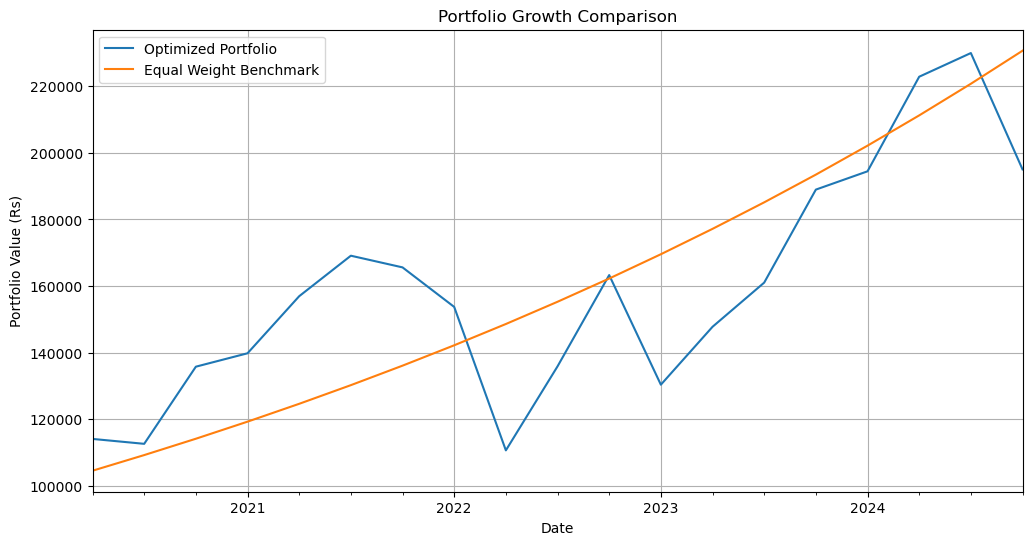

In [102]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

print("\n--- Optimized Quarterly Rebalancing with Sector Tracking ---\n")

for i, q_end in enumerate(quarter_end_dates):
    # Determine quarter start date
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    
    # Skip quarters without sufficient data
    if q_start >= prices.index[-1]:
        continue

    # Get training period data (up to day before quarter starts)
    training_end = q_start - pd.Timedelta(days=1)
    training_prices = prices[prices.index <= training_end]
    
    # Skip if no training data available
    if training_prices.empty:
        continue
        
    # Calculate training returns and Sharpe ratios
    training_returns = training_prices.pct_change().dropna()
    sharpe_scores = training_returns.mean() / training_returns.std()
    
    # Select top 5 sectors
    top_5_sectors = sharpe_scores.nlargest(5).index.tolist()
    
    # Calculate expected returns for optimization
    sector_returns = training_returns[top_5_sectors]
    expected_returns = sector_returns.mean()
    
    # Optimize weights for maximum return (100% to top performer)
    best_sector = expected_returns.idxmax()
    optimized_weights = {sector: 1.0 if sector == best_sector else 0.0 
                         for sector in top_5_sectors}
    
    # Get actual investment period prices
    period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
    if period_prices.empty:
        continue
    
    # Calculate individual sector returns
    start_prices = period_prices.iloc[0][top_5_sectors]
    end_prices = period_prices.iloc[-1][top_5_sectors]
    sector_period_returns = (end_prices / start_prices) - 1
    
    # Calculate portfolio return
    weight_vector = np.array([optimized_weights[sector] for sector in top_5_sectors])
    portfolio_return = np.dot(weight_vector, sector_period_returns)
    
    # Update cumulative value
    cumulative_value *= (1 + portfolio_return)
    
    # Store results
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': top_5_sectors,
        'optimized_weights': optimized_weights,
        'portfolio_return': portfolio_return,
        'sector_returns': sector_period_returns.to_dict(),
        'cumulative_value': cumulative_value
    })
    
    # Print detailed results
    print(f"\nQuarter {q_start.date()} to {q_end.date()}:")
    print(f"Selected Sectors: {top_5_sectors}")
    print("Optimized Weights:")
    for sector, weight in optimized_weights.items():
        print(f"  {sector}: {weight:.1%}")
    print("\nSector Returns:")
    for sector, ret in sector_period_returns.items():
        print(f"  {sector}: {ret:.2%}")
    print(f"\nPortfolio Return: {portfolio_return:.2%}")
    print(f"Cumulative Value: Rs. {cumulative_value:,.2f}")
    print("="*80)

# Calculate benchmark returns
full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
equally_weighted_return = full_period_returns.mean()
benchmark_value = initial_capital * (1 + equally_weighted_return)

# Final results
print("\n=== Final Results ===")
print(f"Initial Capital: Rs. {initial_capital:,.2f}")
print(f"Final Optimized Portfolio Value: Rs. {cumulative_value:,.2f}")
print(f"Equally Weighted Benchmark Value: Rs. {benchmark_value:,.2f}")
print(f"Outperformance: Rs. {cumulative_value - benchmark_value:,.2f}")

# Plot portfolio growth
portfolio_growth = pd.Series(
    {result['quarter_end']: result['cumulative_value'] for result in quarterly_results}
)
benchmark_growth = pd.Series(
    {result['quarter_end']: initial_capital * (1 + equally_weighted_return) ** ((i+1)/len(quarterly_results)) 
     for i, result in enumerate(quarterly_results)}
)

plt.figure(figsize=(12, 6))
portfolio_growth.plot(label='Optimized Portfolio')
benchmark_growth.plot(label='Equal Weight Benchmark')
plt.title("Portfolio Growth Comparison")
plt.ylabel("Portfolio Value (Rs)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

THE NO LOOK AHEAD BIAS CODE WITH EQUAL WEIGHTAGE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



--- Equal-Weighted Quarterly Rebalancing with Sector Tracking ---


Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXINFRA']

Sector Returns:
  ^CNXFMCG: 14.05%
  ^CNXIT: 22.48%
  ^CNXMNC: 22.57%
  ^CNXENERGY: 33.65%
  ^CNXINFRA: 32.79%

Portfolio Return: 25.11%
Cumulative Value: Rs. 125,108.95

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXMNC', '^CNXINFRA', '^CNXIT']

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXMNC: 6.58%
  ^CNXINFRA: 1.63%
  ^CNXIT: 35.43%

Portfolio Return: 9.23%
Cumulative Value: Rs. 136,661.41

Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMNC', '^CNXENERGY', '^CNXFMCG']

Sector Returns:
  ^CNXIT: 20.59%
  ^CNXAUTO: 15.41%
  ^CNXMNC: 11.34%
  ^CNXENERGY: 12.44%
  ^CNXFMCG: 13.89%

Portfolio Return: 14.73%
Cumulative Value: Rs. 156,795.89

Quarter 2021-01-01 to 2021-03-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXA

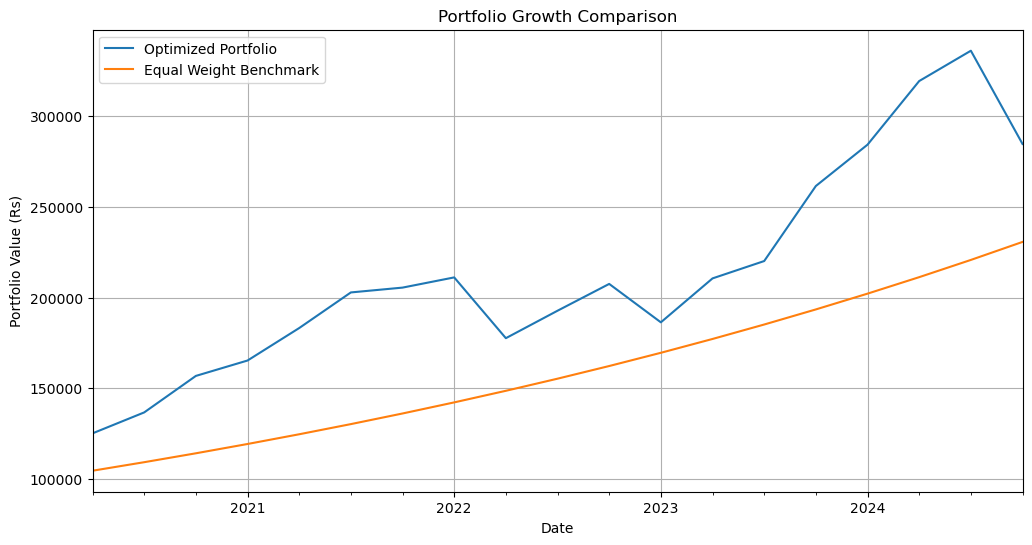

In [120]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

equal_weight = 1 / 5  # 0.2 weight for each sector

print("\n--- Equal-Weighted Quarterly Rebalancing with Sector Tracking ---\n")

for i, q_end in enumerate(quarter_end_dates):
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    
    if q_start >= prices.index[-1]:
        continue

    training_end = q_start - pd.Timedelta(days=1)
    training_prices = prices[prices.index <= training_end]
    
    if training_prices.empty:
        continue
        
    training_returns = training_prices.pct_change().dropna()
    sharpe_scores = training_returns.mean() / training_returns.std()
    
    top_5_sectors = sharpe_scores.nlargest(5).index.tolist()
    
    period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
    if period_prices.empty:
        continue
    
    start_prices = period_prices.iloc[0][top_5_sectors]
    end_prices = period_prices.iloc[-1][top_5_sectors]
    sector_period_returns = (end_prices / start_prices) - 1
    
    weight_vector = np.full(5, equal_weight)  # Equal weight for all 5 sectors
    portfolio_return = np.dot(weight_vector, sector_period_returns)
    
    cumulative_value *= (1 + portfolio_return)
    
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': top_5_sectors,
        'portfolio_return': portfolio_return,
        'sector_returns': sector_period_returns.to_dict(),
        'cumulative_value': cumulative_value
    })
    
    print(f"\nQuarter {q_start.date()} to {q_end.date()}:")
    print(f"Selected Sectors: {top_5_sectors}")
    print("\nSector Returns:")
    for sector, ret in sector_period_returns.items():
        print(f"  {sector}: {ret:.2%}")
    print(f"\nPortfolio Return: {portfolio_return:.2%}")
    print(f"Cumulative Value: Rs. {cumulative_value:,.2f}")
    print("="*80)

full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
equally_weighted_return = full_period_returns.mean()
benchmark_value = initial_capital * (1 + equally_weighted_return)

print("\n=== Final Results ===")
print(f"Initial Capital: Rs. {initial_capital:,.2f}")
print(f"Final Optimized Portfolio Value: Rs. {cumulative_value:,.2f}")
print(f"Equally Weighted Benchmark Value: Rs. {benchmark_value:,.2f}")
print(f"Outperformance: Rs. {cumulative_value - benchmark_value:,.2f}")

# Plot portfolio growth
portfolio_growth = pd.Series(
    {result['quarter_end']: result['cumulative_value'] for result in quarterly_results}
)
benchmark_growth = pd.Series(
    {result['quarter_end']: initial_capital * (1 + equally_weighted_return) ** ((i+1)/len(quarterly_results)) 
     for i, result in enumerate(quarterly_results)}
)

plt.figure(figsize=(12, 6))
portfolio_growth.plot(label='Optimized Portfolio')
benchmark_growth.plot(label='Equal Weight Benchmark')
plt.title("Portfolio Growth Comparison")
plt.ylabel("Portfolio Value (Rs)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [146]:
#Equal weighted portfolios for 'n' sectors

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



--- Multi-Sector Portfolio Optimization ---

 num_sectors   final_value  outperformance
           1 212448.007918   -14388.961851
           2 243526.107642    16689.137873
           3 290839.282668    64002.312898
           4 296058.763734    69221.793964
           5 296483.771168    69646.801398


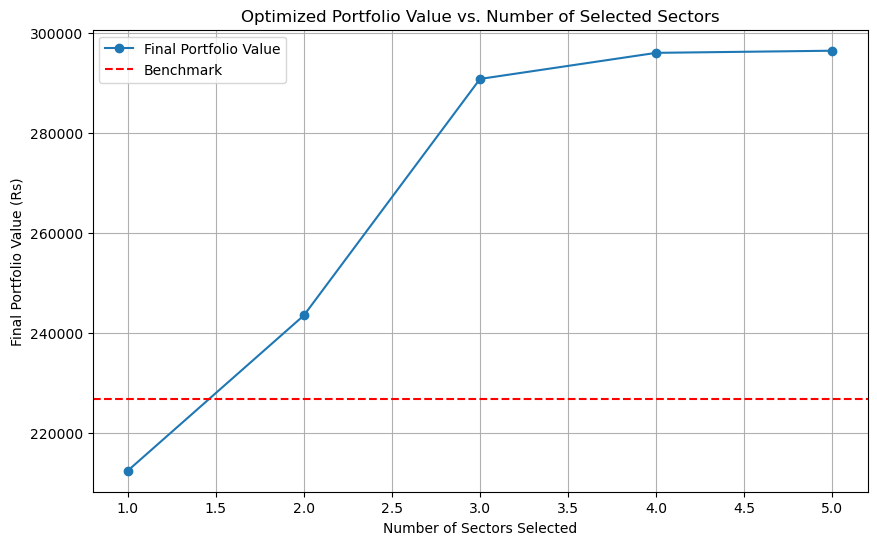

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000

# Store results for different sector counts
results = []

print("\n--- Multi-Sector Portfolio Optimization ---\n")

for n in range(1, 6):  # Iterate from top 1 to top 5 sectors
    cumulative_value = initial_capital
    quarterly_results = []
    
    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        
        if q_start >= prices.index[-1]:
            continue

        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        
        if training_prices.empty:
            continue
            
        training_returns = training_prices.pct_change().dropna()
        sharpe_scores = training_returns.mean() / training_returns.std()
        
        top_sectors = sharpe_scores.nlargest(n).index.tolist()
        
        period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
        if period_prices.empty:
            continue
        
        start_prices = period_prices.iloc[0][top_sectors]
        end_prices = period_prices.iloc[-1][top_sectors]
        sector_period_returns = (end_prices / start_prices) - 1
        
        weight_vector = np.full(n, 1/n)  # Equal weight for selected sectors
        portfolio_return = np.dot(weight_vector, sector_period_returns)
        
        cumulative_value *= (1 + portfolio_return)
        
        quarterly_results.append({'quarter_end': q_end, 'cumulative_value': cumulative_value})

    # Calculate final results for this sector count
    full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
    equally_weighted_return = full_period_returns.mean()
    benchmark_value = initial_capital * (1 + equally_weighted_return)
    outperformance = cumulative_value - benchmark_value
    
    results.append({
        'num_sectors': n,
        'final_value': cumulative_value,
        'outperformance': outperformance
    })

# Convert results into a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_sectors'], results_df['final_value'], marker='o', label='Final Portfolio Value')
plt.axhline(y=benchmark_value, color='r', linestyle='--', label='Benchmark')
plt.xlabel("Number of Sectors Selected")
plt.ylabel("Final Portfolio Value (Rs)")
plt.title("Optimized Portfolio Value vs. Number of Selected Sectors")
plt.legend()
plt.grid(True)
plt.show()

In [148]:
#Instead of equal weightage, we tried to optimize the weightage in each sector for each quarter

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


   Number of Sectors  Final Portfolio Value  Outperformance  \
0                  1          234314.831205    21424.275318   
1                  2          213750.610707      860.054820   
2                  3          183988.489551   -28902.066336   
3                  4          229458.572548    16568.016661   
4                  5          215481.098276     2590.542389   
5                  6          218616.582705     5726.026818   
6                  7          203647.085916    -9243.469971   
7                  8          220209.143513     7318.587626   
8                  9          240883.860967    27993.305080   
9                 10          229317.398864    16426.842977   

   Annualized Volatility  
0               0.268511  
1               0.194401  
2               0.199518  
3               0.195157  
4               0.196773  
5               0.195222  
6               0.203984  
7               0.206159  
8               0.218505  
9               0.220590  


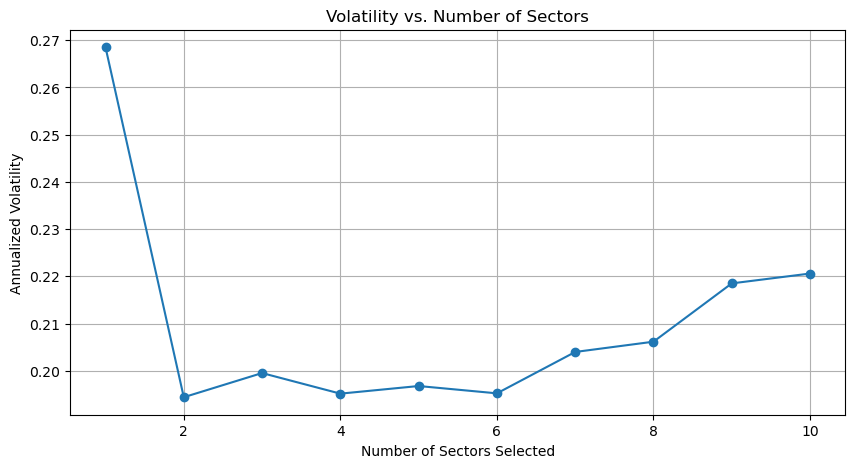

In [150]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=7*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
results_summary = []

# Iterate over n=1 to n=7 sectors
for n in range(1, 11):
    cumulative_value = initial_capital
    quarterly_returns = []

    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)

        if q_start >= prices.index[-1]:
            continue

        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]

        if training_prices.empty:
            continue

        training_returns = training_prices.pct_change().dropna()
        sharpe_scores = training_returns.mean() / training_returns.std()

        top_n_sectors = sharpe_scores.nlargest(n).index.tolist()

        period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
        if period_prices.empty:
            continue

        start_prices = period_prices.iloc[0][top_n_sectors]
        end_prices = period_prices.iloc[-1][top_n_sectors]
        sector_period_returns = (end_prices / start_prices) - 1

        weight_vector = np.full(n, 1/n)  # Equal weight for selected sectors
        portfolio_return = np.dot(weight_vector, sector_period_returns)

        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)

    # Calculate volatility (annualized standard deviation)
    if len(quarterly_returns) > 1:
        annualized_volatility = np.std(quarterly_returns) * np.sqrt(4)  # 4 quarters in a year
    else:
        annualized_volatility = np.nan  # Not enough data for volatility calculation

    # Benchmark: Equal weight across all sectors
    full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
    equally_weighted_return = full_period_returns.mean()
    benchmark_value = initial_capital * (1 + equally_weighted_return)

    outperformance = cumulative_value - benchmark_value

    results_summary.append({
        'Number of Sectors': n,
        'Final Portfolio Value': cumulative_value,
        'Outperformance': outperformance,
        'Annualized Volatility': annualized_volatility
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results_summary)
print(results_df)

# Plot: Volatility vs. Number of Sectors
plt.figure(figsize=(10, 5))
plt.plot(results_df['Number of Sectors'], results_df['Annualized Volatility'], marker='o', linestyle='-')
plt.xlabel("Number of Sectors Selected")
plt.ylabel("Annualized Volatility")
plt.title("Volatility vs. Number of Sectors")
plt.grid(True)
plt.show()

In [152]:
#Instead of giving equal weights to the best sectors, we have tried to optimize the weightage

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Quarter 2 | n = 1 | Date: 2020-04-01 to 2020-06-30
   ^CNXFMCG: 1.000
   Quarterly Return: 14.054%

Quarter 3 | n = 1 | Date: 2020-07-01 to 2020-09-30
   ^CNXFMCG: 1.000
   Quarterly Return: -1.292%

Quarter 4 | n = 1 | Date: 2020-10-01 to 2020-12-31
   ^CNXIT: 1.000
   Quarterly Return: 20.591%

Quarter 5 | n = 1 | Date: 2021-01-01 to 2021-03-31
   ^CNXIT: 1.000
   Quarterly Return: 2.967%

Quarter 6 | n = 1 | Date: 2021-04-01 to 2021-06-30
   ^CNXIT: 1.000
   Quarterly Return: 12.269%

Quarter 7 | n = 1 | Date: 2021-07-01 to 2021-09-30
   ^CNXIT: 1.000
   Quarterly Return: 20.773%

Quarter 8 | n = 1 | Date: 2021-10-01 to 2021-12-31
   ^CNXIT: 1.000
   Quarterly Return: 11.272%

Quarter 9 | n = 1 | Date: 2022-01-01 to 2022-03-31
   ^CNXIT: 1.000
   Quarterly Return: -7.174%

Quarter 10 | n = 1 | Date: 2022-04-01 to 2022-06-30
   ^CNXIT: 1.000
   Quarterly Return: -23.388%

Quarter 11 | n = 1 | Date: 2022-07-01 to 2022-09-30
   ^CNXIT: 1.000
   Quarterly Return: -3.859%

Quarter 12 | n

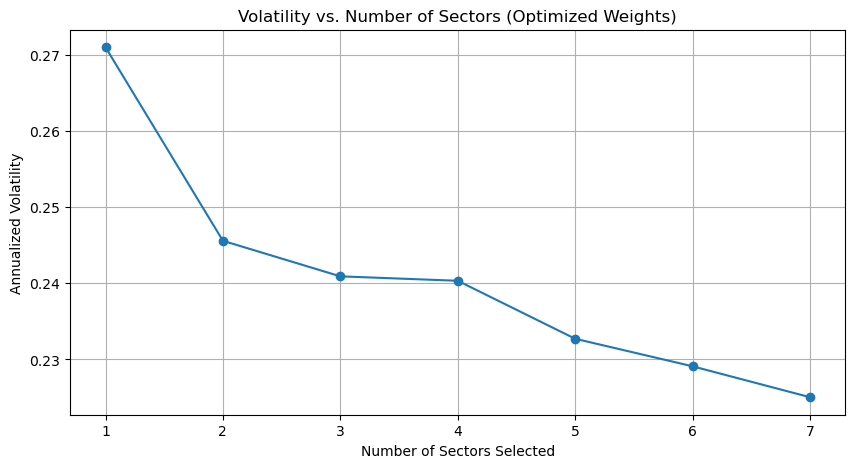

In [142]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store only the Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
results_summary = []

def optimize_weights(returns):
    """Optimize portfolio weights using Mean-Variance Optimization (Sharpe Ratio Maximization)."""
    n_assets = returns.shape[1]

    def portfolio_return(weights):
        return np.dot(weights, returns.mean())

    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

    def neg_sharpe(weights):
        return -portfolio_return(weights) / portfolio_volatility(weights)  # Negative Sharpe to minimize

    # Constraints: Sum of weights = 1, No short selling (weights >= 0)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))  # No short selling
    initial_guess = np.array([1/n_assets] * n_assets)  # Equal weights as starting point

    result = sco.minimize(neg_sharpe, initial_guess, bounds=bounds, constraints=constraints)
    return result.x if result.success else initial_guess  # Return optimized weights

# Iterate over n=1 to n=7 sectors
for n in range(1, 8):
    cumulative_value = initial_capital
    quarterly_returns = []
    weight_history = []

    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            continue

        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]

        if training_prices.empty:
            continue

        training_returns = training_prices.pct_change().dropna()
        sharpe_scores = training_returns.mean() / training_returns.std()

        top_n_sectors = sharpe_scores.nlargest(n).index.tolist()
        period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
        if period_prices.empty:
            continue

        start_prices = period_prices.iloc[0][top_n_sectors]
        end_prices = period_prices.iloc[-1][top_n_sectors]
        sector_period_returns = (end_prices / start_prices) - 1

        selected_returns = training_returns[top_n_sectors]
        optimized_weights = optimize_weights(selected_returns)

        portfolio_return = np.dot(optimized_weights, sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)
        weight_history.append(dict(zip(top_n_sectors, optimized_weights)))

        # Print weights for each quarter
        print(f"Quarter {i+1} | n = {n} | Date: {q_start.date()} to {q_end.date()}")
        for sector, weight in zip(top_n_sectors, optimized_weights):
            print(f"   {sector}: {weight:.3f}")
        print(f"   Quarterly Return: {portfolio_return:.3%}\n")

    # Calculate annualized volatility
    if len(quarterly_returns) > 1:
        annualized_volatility = np.std(quarterly_returns) * np.sqrt(4)  # 4 quarters per year
    else:
        annualized_volatility = np.nan

    results_summary.append({
        'Number of Sectors': n,
        'Final Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_volatility
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results_summary)
print(results_df)

# Plot: Volatility vs. Number of Sectors
plt.figure(figsize=(10, 5))
plt.plot(results_df['Number of Sectors'], results_df['Annualized Volatility'], marker='o', linestyle='-')
plt.xlabel("Number of Sectors Selected")
plt.ylabel("Annualized Volatility")
plt.title("Volatility vs. Number of Sectors (Optimized Weights)")
plt.grid(True)
plt.show()

In [155]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch sector data
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000

# Data storage for Excel output
summary_data = []
weights_data = []
returns_data = []

def optimize_weights(returns):
    """Optimize portfolio weights using Mean-Variance Optimization."""
    n_assets = returns.shape[1]

    def portfolio_return(weights):
        return np.dot(weights, returns.mean())

    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

    def neg_sharpe(weights):
        return -portfolio_return(weights) / portfolio_volatility(weights)  # Negative Sharpe to minimize

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)

    result = sco.minimize(neg_sharpe, initial_guess, bounds=bounds, constraints=constraints)
    return result.x if result.success else initial_guess

# Iterate over n=1 to n=7 sectors
for n in range(1, 11):
    cumulative_value = initial_capital
    quarterly_returns = []

    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            continue

        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]

        if training_prices.empty:
            continue

        training_returns = training_prices.pct_change().dropna()
        sharpe_scores = training_returns.mean() / training_returns.std()

        top_n_sectors = sharpe_scores.nlargest(n).index.tolist()
        period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
        if period_prices.empty:
            continue

        start_prices = period_prices.iloc[0][top_n_sectors]
        end_prices = period_prices.iloc[-1][top_n_sectors]
        sector_period_returns = (end_prices / start_prices) - 1

        selected_returns = training_returns[top_n_sectors]
        optimized_weights = optimize_weights(selected_returns)

        portfolio_return = np.dot(optimized_weights, sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)

        # Store weights for Excel
        for sector, weight in zip(top_n_sectors, optimized_weights):
            weights_data.append([n, i+1, q_start.date(), q_end.date(), sector, weight])

        # Store returns for Excel
        returns_data.append([n, i+1, q_start.date(), q_end.date(), portfolio_return])

    # Calculate annualized volatility
    annualized_volatility = np.std(quarterly_returns) * np.sqrt(4) if len(quarterly_returns) > 1 else np.nan

    # Store final summary
    summary_data.append([n, cumulative_value, annualized_volatility])

# Convert to DataFrames
summary_df = pd.DataFrame(summary_data, columns=["Number of Sectors", "Final Portfolio Value", "Annualized Volatility"])
weights_df = pd.DataFrame(weights_data, columns=["Number of Sectors", "Quarter", "Start Date", "End Date", "Sector", "Weight"])
returns_df = pd.DataFrame(returns_data, columns=["Number of Sectors", "Quarter", "Start Date", "End Date", "Quarterly Return"])

# Save to Excel
with pd.ExcelWriter("Portfolio_Optimization.xlsx") as writer:
    summary_df.to_excel(writer, sheet_name="Portfolio Summary", index=False)
    weights_df.to_excel(writer, sheet_name="Quarterly Weights", index=False)
    returns_df.to_excel(writer, sheet_name="Quarterly Returns", index=False)

print("✅ Excel file 'Portfolio_Optimization.xlsx' created successfully!")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


✅ Excel file 'Portfolio_Optimization.xlsx' created successfully!


In [164]:
#Trying to optimize the rebalancing period and the diversification 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


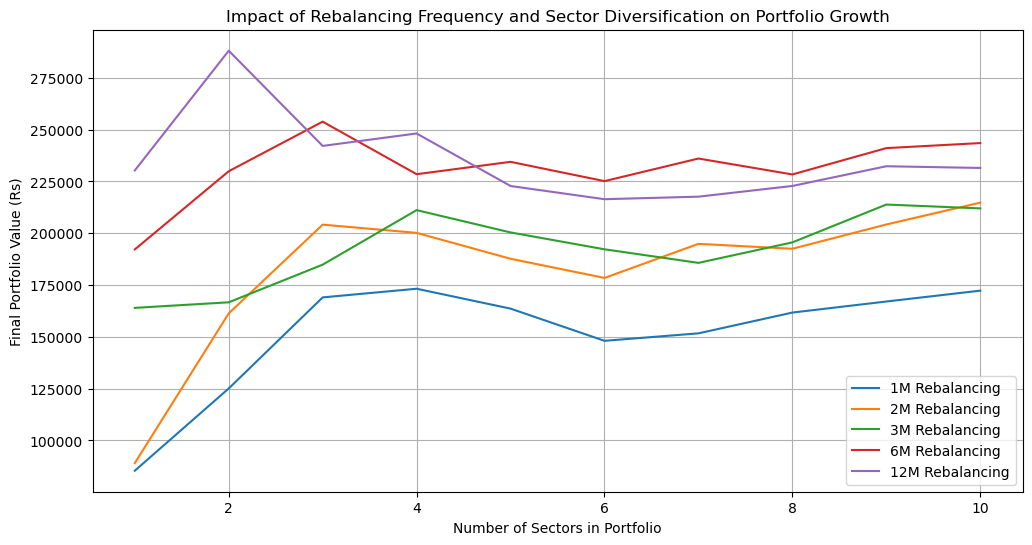

Analysis complete. Results saved to 'optimal_rebalancing_analysis.xlsx'.


In [168]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector
prices = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in sector_tickers})
prices.dropna(inplace=True)
returns = prices.pct_change().dropna()

# Define rebalancing periods
rebalance_periods = {"1M": "M", "2M": "2M", "3M": "Q", "6M": "6M", "12M": "A"}
sector_counts = range(1, 11)  # From 1 to 7 sectors
initial_capital = 100000

# Store results
results = []

for period_name, period_freq in rebalance_periods.items():
    rebalance_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq=period_freq)
    
    for n_sectors in sector_counts:
        capital = initial_capital
        portfolio_values = []
        volatilities = []
        
        for i, rebalance_date in enumerate(rebalance_dates):
            start_date = prices.index[0] if i == 0 else rebalance_dates[i-1] + timedelta(days=1)
            
            if start_date >= prices.index[-1]:
                break

            # Train on past data to select sectors
            train_prices = prices.loc[:start_date]
            train_returns = train_prices.pct_change().dropna()
            
            sharpe_scores = train_returns.mean() / train_returns.std()
            top_sectors = sharpe_scores.nlargest(n_sectors).index.tolist()
            
            # Get rebalancing period returns
            period_prices = prices.loc[start_date:rebalance_date, top_sectors]
            if period_prices.empty:
                continue
            
            start_prices = period_prices.iloc[0]
            end_prices = period_prices.iloc[-1]
            sector_returns = (end_prices / start_prices) - 1
            
            # Equal weight allocation
            weight_vector = np.full(n_sectors, 1/n_sectors)
            portfolio_return = np.dot(weight_vector, sector_returns)
            
            capital *= (1 + portfolio_return)
            
            # Store performance metrics
            portfolio_values.append(capital)
            volatilities.append(np.std(sector_returns))
        
        # Compute final metrics
        final_value = capital
        avg_volatility = np.mean(volatilities)
        avg_sharpe = (final_value / initial_capital - 1) / avg_volatility if avg_volatility != 0 else 0
        
        results.append([period_name, n_sectors, final_value, avg_volatility, avg_sharpe])

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results, columns=["Rebalancing Period", "Number of Sectors", "Final Portfolio Value", "Volatility", "Sharpe Ratio"])
results_df.to_excel("optimal_rebalancing_analysis.xlsx", index=False)

# Visualization
plt.figure(figsize=(12, 6))
for period_name in rebalance_periods.keys():
    subset = results_df[results_df["Rebalancing Period"] == period_name]
    plt.plot(subset["Number of Sectors"], subset["Final Portfolio Value"], label=f"{period_name} Rebalancing")
    
plt.xlabel("Number of Sectors in Portfolio")
plt.ylabel("Final Portfolio Value (Rs)")
plt.title("Impact of Rebalancing Frequency and Sector Diversification on Portfolio Growth")
plt.legend()
plt.grid()
plt.show()

print("Analysis complete. Results saved to 'optimal_rebalancing_analysis.xlsx'.")

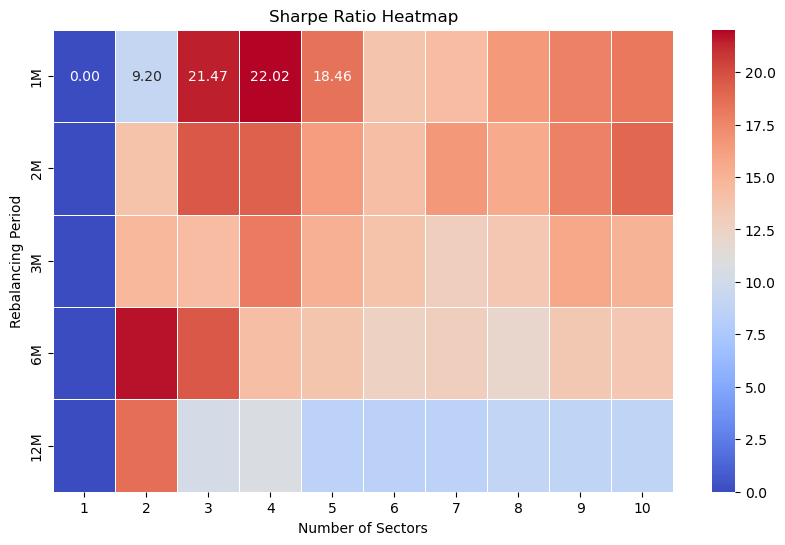

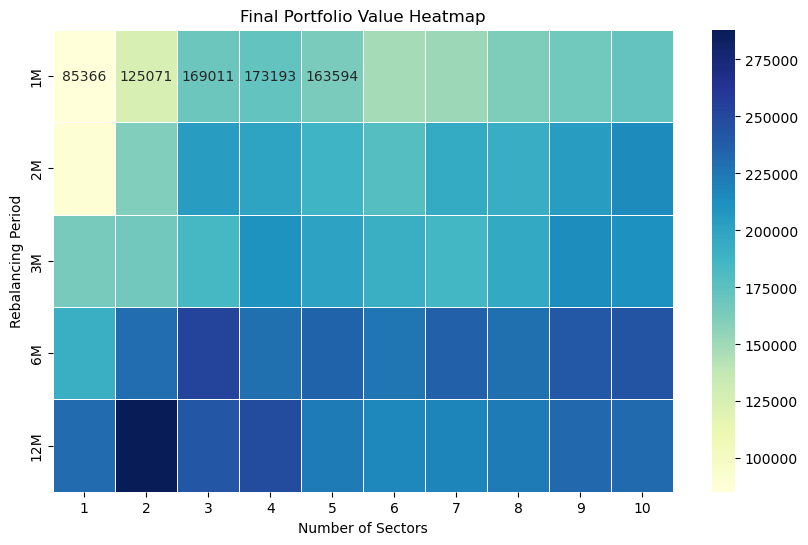

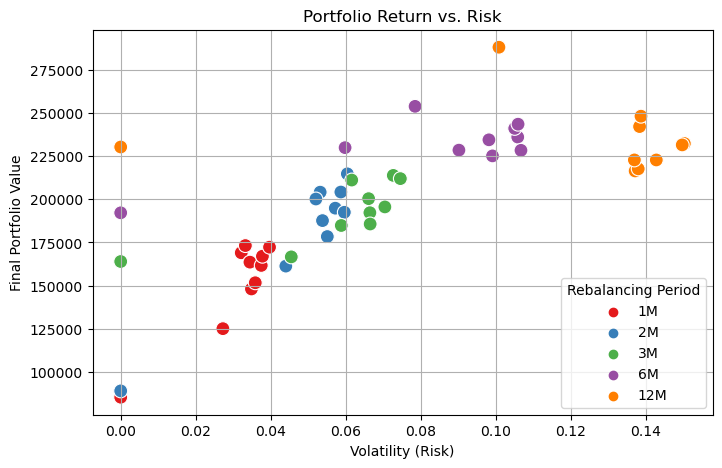

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "optimal_rebalancing_analysis.xlsx"  # Update if needed
df = pd.read_excel(file_path)

# Convert 'Rebalancing Period' to categorical for proper sorting
df["Rebalancing Period"] = pd.Categorical(df["Rebalancing Period"], categories=["1M", "2M", "3M", "6M", "12M"], ordered=True)

# Use pivot_table (handles duplicates better)
sharpe_pivot = df.pivot_table(index="Rebalancing Period", columns="Number of Sectors", values="Sharpe Ratio")
portfolio_pivot = df.pivot_table(index="Rebalancing Period", columns="Number of Sectors", values="Final Portfolio Value")

# Plot Heatmap: Sharpe Ratio
plt.figure(figsize=(10, 6))
sns.heatmap(sharpe_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Sharpe Ratio Heatmap")
plt.xlabel("Number of Sectors")
plt.ylabel("Rebalancing Period")
plt.show()

# Plot Heatmap: Final Portfolio Value
plt.figure(figsize=(10, 6))
sns.heatmap(portfolio_pivot, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Final Portfolio Value Heatmap")
plt.xlabel("Number of Sectors")
plt.ylabel("Rebalancing Period")
plt.show()

# Scatter Plot: Return vs. Risk
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Volatility"], y=df["Final Portfolio Value"], hue=df["Rebalancing Period"], palette="Set1", s=100)
plt.title("Portfolio Return vs. Risk")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Final Portfolio Value")
plt.legend(title="Rebalancing Period")
plt.grid()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

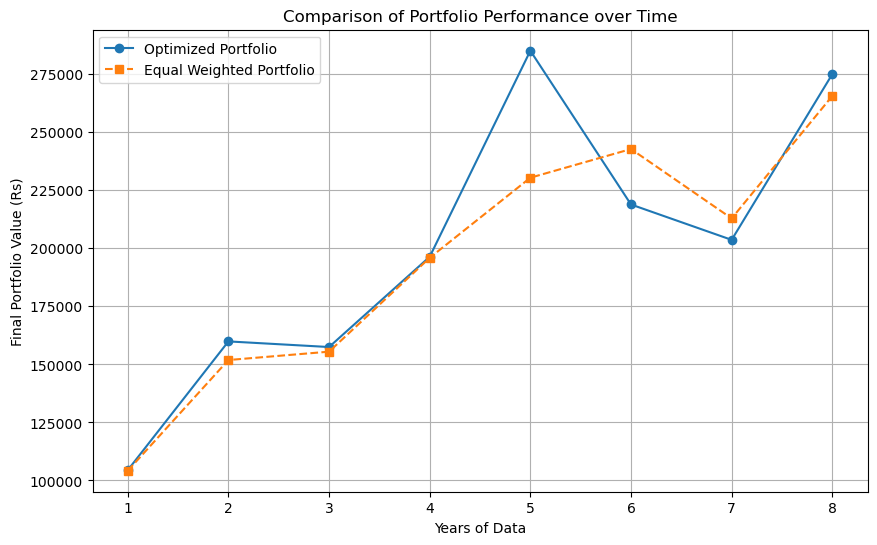

Comparison data saved to 'Portfolio_Comparison.xlsx' and plotted successfully.


In [182]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define range of years for comparison (1 to 8 years)
years_range = range(1, 9)
initial_capital = 100000
n_sectors = 7  # Fixed number of sectors

# Store results for both strategies
comparison_results = []

for years in years_range:
    end_date = datetime.today()
    start_date = end_date - timedelta(days=years * 365)

    # Fetch data
    data_dict = {}
    for ticker in sector_tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        if not df.empty:
            data_dict[ticker] = df['Adj Close']

    prices = pd.DataFrame(data_dict).dropna()
    returns = prices.pct_change().dropna()
    
    # Define quarterly rebalancing dates
    quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')

    # Optimized Weighted Portfolio
    cumulative_value_optimized = initial_capital
    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            continue

        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue

        training_returns = training_prices.pct_change().dropna()
        sharpe_scores = training_returns.mean() / training_returns.std()
        top_sectors = sharpe_scores.nlargest(n_sectors).index.tolist()

        period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
        if period_prices.empty:
            continue

        start_prices = period_prices.iloc[0][top_sectors]
        end_prices = period_prices.iloc[-1][top_sectors]
        sector_period_returns = (end_prices / start_prices) - 1

        weight_vector = np.full(n_sectors, 1/n_sectors)
        portfolio_return = np.dot(weight_vector, sector_period_returns)
        cumulative_value_optimized *= (1 + portfolio_return)

    # Equal Weighted Portfolio
    full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
    equally_weighted_return = full_period_returns.mean()
    cumulative_value_equal_weighted = initial_capital * (1 + equally_weighted_return)

    # Store results
    comparison_results.append({
        "Years": years,
        "Final Portfolio Value (Optimized)": cumulative_value_optimized,
        "Final Portfolio Value (Equal Weighted)": cumulative_value_equal_weighted
    })

# Convert results into a DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Save to Excel
comparison_df.to_excel("Portfolio_Comparison.xlsx", index=False)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Years"], comparison_df["Final Portfolio Value (Optimized)"], marker='o', label="Optimized Portfolio")
plt.plot(comparison_df["Years"], comparison_df["Final Portfolio Value (Equal Weighted)"], marker='s', linestyle="--", label="Equal Weighted Portfolio")
plt.xlabel("Years of Data")
plt.ylabel("Final Portfolio Value (Rs)")
plt.title("Comparison of Portfolio Performance over Time")
plt.legend()
plt.grid(True)
plt.show()

print("Comparison data saved to 'Portfolio_Comparison.xlsx' and plotted successfully.")

In [3]:
#Equal vs Optimized, 3 month rebalancing, for 1 to 10 years

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Results saved to Portfolio_Comparison_1to10Yrs.xlsx


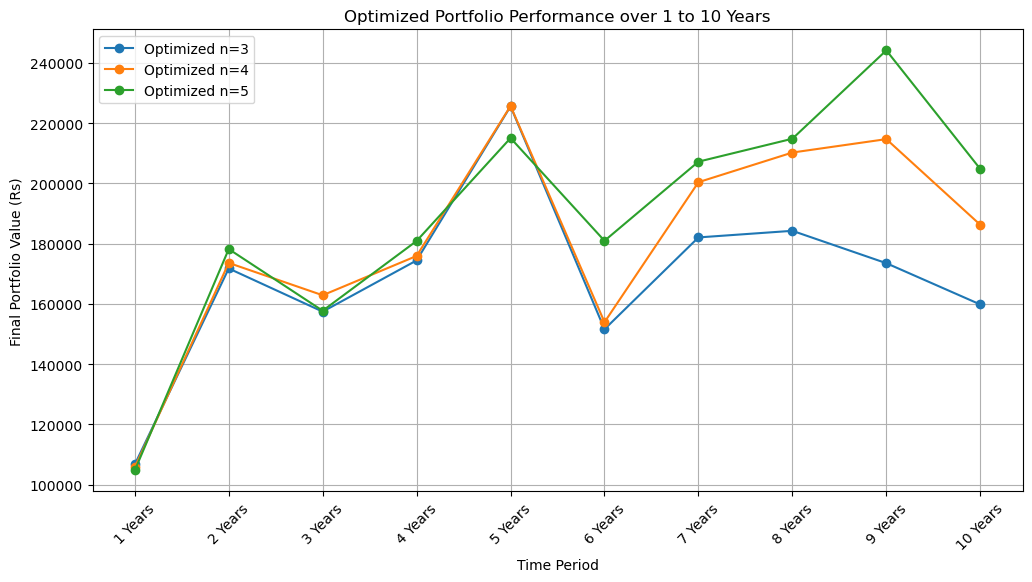

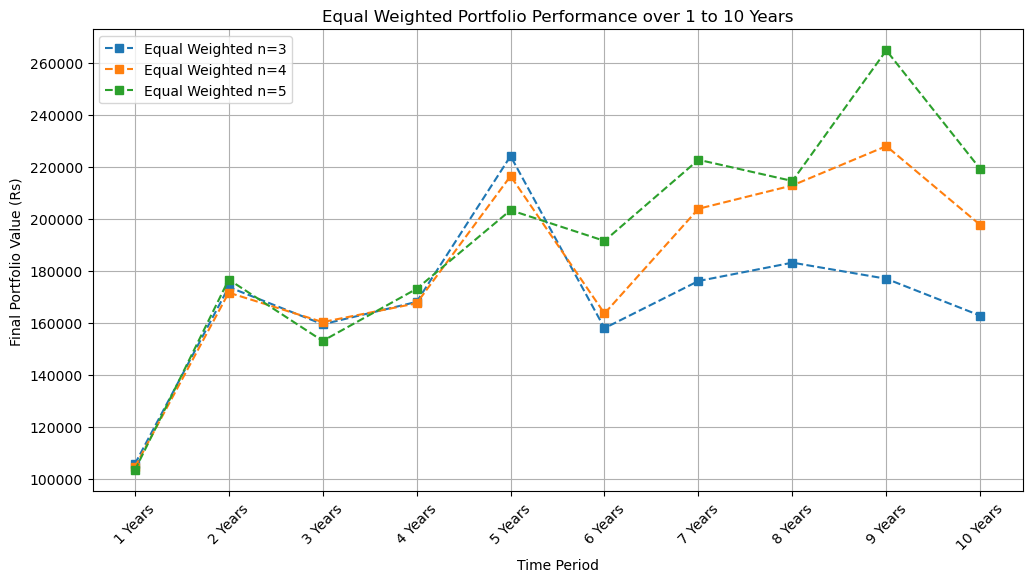

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define different time periods from 1 year to 10 years
end_date = datetime.today()
time_periods = {f"{i} Years": end_date - timedelta(days=365 * i) for i in range(1, 11)}

# Store results
comparison_results = []

# Initial investment amount
initial_capital = 100000  

# Iterate over different time periods
for period_name, start_date in time_periods.items():
    # Fetch data
    data_dict = {}
    for ticker in sector_tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        if not df.empty:
            data_dict[ticker] = df['Adj Close']

    # Combine into DataFrame and drop NaN
    prices = pd.DataFrame(data_dict).dropna()
    
    # Define rebalancing periods (every 6 months)
    rebalance_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='3M')

    # Iterate over different n values (number of sectors)
    for n in [3, 4, 5]:
        cumulative_value_optimized = initial_capital
        cumulative_value_equal = initial_capital

        for i, rebalance_date in enumerate(rebalance_dates):
            rebalance_start = prices.index[0] if i == 0 else rebalance_dates[i - 1] + pd.Timedelta(days=1)
            
            if rebalance_start >= prices.index[-1]:
                continue

            training_end = rebalance_start - pd.Timedelta(days=1)
            training_prices = prices[prices.index <= training_end]

            if training_prices.empty:
                continue

            training_returns = training_prices.pct_change().dropna()
            sharpe_scores = training_returns.mean() / training_returns.std()

            top_n_sectors = sharpe_scores.nlargest(n).index.tolist()

            period_prices = prices[(prices.index >= rebalance_start) & (prices.index <= rebalance_date)]
            if period_prices.empty:
                continue

            start_prices = period_prices.iloc[0][top_n_sectors]
            end_prices = period_prices.iloc[-1][top_n_sectors]
            sector_period_returns = (end_prices / start_prices) - 1

            weight_vector = np.full(n, 1/n)  # Equal weight

            # Optimized Portfolio Return (Sharpe-weighted)
            sharpe_weights = sharpe_scores.loc[top_n_sectors].abs()
            sharpe_weights /= sharpe_weights.sum()
            portfolio_return_optimized = np.dot(sharpe_weights, sector_period_returns)

            # Equal Weighted Portfolio Return
            portfolio_return_equal = np.dot(weight_vector, sector_period_returns)

            cumulative_value_optimized *= (1 + portfolio_return_optimized)
            cumulative_value_equal *= (1 + portfolio_return_equal)

        comparison_results.append({
            'Time Period': period_name,
            'Number of Sectors': n,
            'Final Portfolio Value (Optimized)': cumulative_value_optimized,
            'Final Portfolio Value (Equal Weighted)': cumulative_value_equal
        })

# Convert results to DataFrame
results_df = pd.DataFrame(comparison_results)

# Save to Excel
excel_filename = "Portfolio_Comparison_1to10Yrs.xlsx"
results_df.to_excel(excel_filename, index=False)
print(f"Results saved to {excel_filename}")

# Plot comparison line charts
plt.figure(figsize=(12, 6))

# Optimized Portfolio Chart
for n in [3, 4, 5]:
    subset = results_df[results_df['Number of Sectors'] == n]
    plt.plot(subset['Time Period'], subset['Final Portfolio Value (Optimized)'], marker='o', linestyle='-', label=f'Optimized n={n}')

plt.xlabel("Time Period")
plt.ylabel("Final Portfolio Value (Rs)")
plt.title("Optimized Portfolio Performance over 1 to 10 Years")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Equal Weighted Portfolio Chart
plt.figure(figsize=(12, 6))
for n in [3, 4, 5]:
    subset = results_df[results_df['Number of Sectors'] == n]
    plt.plot(subset['Time Period'], subset['Final Portfolio Value (Equal Weighted)'], marker='s', linestyle='--', label=f'Equal Weighted n={n}')

plt.xlabel("Time Period")
plt.ylabel("Final Portfolio Value (Rs)")
plt.title("Equal Weighted Portfolio Performance over 1 to 10 Years")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [194]:
#BENCHMARK - NIFTY50

[*********************100%%**********************]  1 of 1 completed

Results saved to NIFTY_Benchmark_Comparison.xlsx


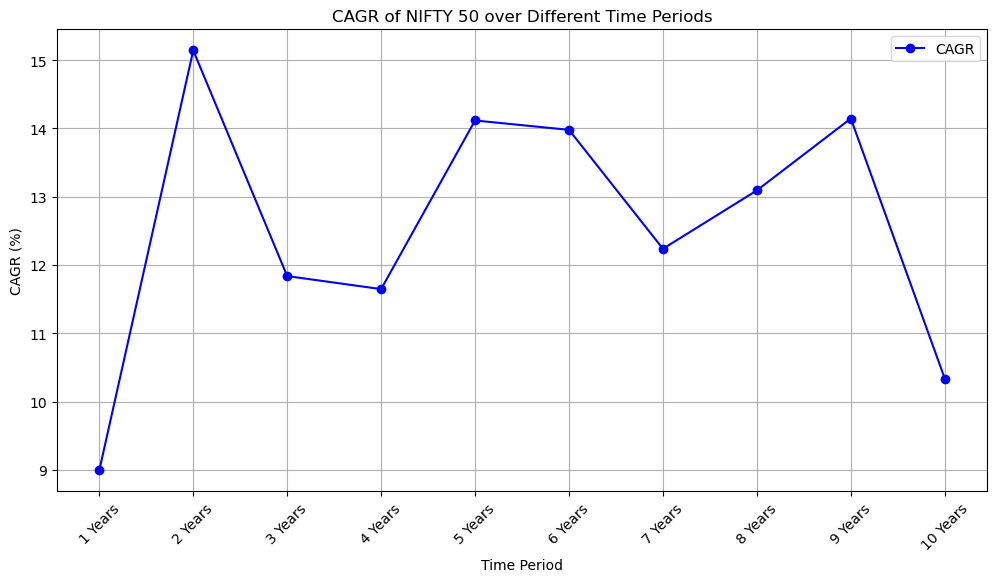


📊 Final Portfolio Value and CAGR after 10 years:
  Time Period  Start Price     End Price  Total Return       CAGR  \
9    10 Years  8809.349609  23559.949219     167.44255  10.337477   

   Final Portfolio Value  
9           267442.54983  


In [196]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the benchmark index (NIFTY 50)
benchmark_ticker = "^NSEI"

# Define start and end dates
end_date = datetime.today()
time_periods = {f"{i} Years": end_date - timedelta(days=365 * i) for i in range(1, 11)}

# Store results
benchmark_results = []

# Initial investment
initial_capital = 100000  

# Fetch benchmark data
data = yf.download(benchmark_ticker, start=min(time_periods.values()), end=end_date)['Adj Close']

# Iterate over each time period
for period, start_date in time_periods.items():
    filtered_data = data[data.index >= start_date]
    
    if filtered_data.empty:
        continue
    
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    
    # Calculate total return over period
    total_return = (end_price / start_price) - 1
    
    # Calculate CAGR
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    
    # Final portfolio value
    final_value = initial_capital * (1 + total_return)
    
    # Store results
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return': total_return * 100,
        'CAGR': cagr * 100,
        'Final Portfolio Value': final_value
    })

# Convert to DataFrame
results_df = pd.DataFrame(benchmark_results)

# Save to Excel
excel_filename = "NIFTY_Benchmark_Comparison.xlsx"
results_df.to_excel(excel_filename, index=False)
print(f"Results saved to {excel_filename}")

# Plot CAGR over time
plt.figure(figsize=(12, 6))
plt.plot(results_df['Time Period'], results_df['CAGR'], marker='o', linestyle='-', color='b', label='CAGR')
plt.xlabel("Time Period")
plt.ylabel("CAGR (%)")
plt.title("CAGR of NIFTY 50 over Different Time Periods")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print final 10-year results
final_10_years = results_df[results_df["Time Period"] == "10 Years"]
print("\n📊 Final Portfolio Value and CAGR after 10 years:")
print(final_10_years)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\701047459.py:46: FutureWarning: Setting an item of in


--- HRP-Weighted Quarterly Rebalancing with Sector Tracking ---


Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXREALTY', '^NSEBANK', '^CNXSERVICE', '^CNXINFRA', '^CNXENERGY', '^CNXMETAL', '^CNXPSE', '^CNXAUTO', '^CNXMNC', '^CNXIT', '^CNXFMCG', '^CNXMEDIA', '^CNXPSUBANK']

Sector Returns:
  ^CNXIT: 22.48%
  ^CNXAUTO: 44.26%
  ^NSEBANK: 17.36%
  ^CNXFMCG: 14.05%
  ^CNXMEDIA: 34.17%
  ^CNXMETAL: 28.18%
  ^CNXPSE: 16.18%
  ^CNXMNC: 22.57%
  ^CNXINFRA: 32.79%
  ^CNXREALTY: 17.75%
  ^CNXENERGY: 33.65%
  ^CNXPSUBANK: 11.29%
  ^CNXSERVICE: 20.48%

Portfolio Return: 23.16%
Cumulative Value: Rs. 123,162.56

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXINFRA', '^CNXENERGY', '^CNXMETAL', '^CNXPSE', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^NSEBANK', '^CNXSERVICE', '^CNXMEDIA', '^CNXPSUBANK']

Sector Returns:
  ^CNXIT: 35.43%
  ^CNXAUTO: 17.70%
  ^NSEBANK: -2.39%
  ^CNXFMCG: -1.29%
  ^CNXMEDIA: 13.17%
  ^CNXMETAL: 12.28%
  ^CNXPSE: -9.31%
  ^CNXMNC: 6.58

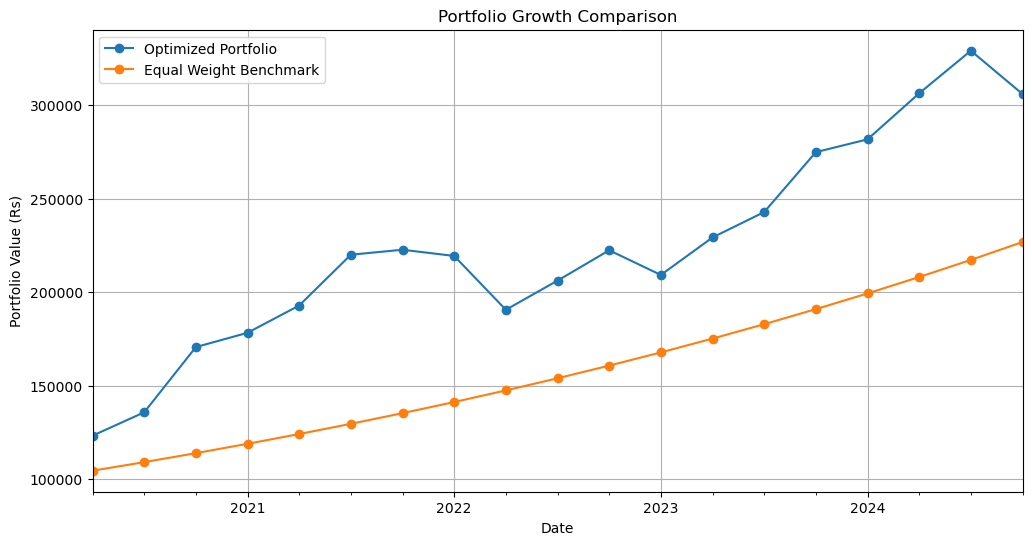

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Fetch data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Combine into a single DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# Function to calculate HRP weights
def get_hrp_weights(returns):
    corr = returns.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    link = sch.linkage(ssd.squareform(dist), method='ward')
    
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
    
    return weights / weights.sum()

# Define quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

print("\n--- HRP-Weighted Quarterly Rebalancing with Sector Tracking ---\n")

for i, q_end in enumerate(quarter_end_dates):
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    if q_start >= prices.index[-1]:
        continue
    
    training_end = q_start - pd.Timedelta(days=1)
    training_prices = prices[prices.index <= training_end]
    
    if training_prices.empty:
        continue
    
    training_returns = training_prices.pct_change().dropna()
    
    # Get HRP Weights
    hrp_weights = get_hrp_weights(training_returns)
    
    period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)]
    if period_prices.empty:
        continue
    
    start_prices = period_prices.iloc[0]
    end_prices = period_prices.iloc[-1]
    sector_period_returns = (end_prices / start_prices) - 1
    
    portfolio_return = np.dot(hrp_weights, sector_period_returns)
    cumulative_value *= (1 + portfolio_return)
    
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': hrp_weights.index.tolist(),
        'portfolio_return': portfolio_return,
        'sector_returns': sector_period_returns.to_dict(),
        'cumulative_value': cumulative_value
    })
    
    print(f"\nQuarter {q_start.date()} to {q_end.date()}:")
    print(f"Selected Sectors: {hrp_weights.index.tolist()}")
    print("\nSector Returns:")
    for sector, ret in sector_period_returns.items():
        print(f"  {sector}: {ret:.2%}")
    print(f"\nPortfolio Return: {portfolio_return:.2%}")
    print(f"Cumulative Value: Rs. {cumulative_value:,.2f}")
    print("="*80)

full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
equally_weighted_return = full_period_returns.mean()
benchmark_value = initial_capital * (1 + equally_weighted_return)

print("\n=== Final Results ===")
print(f"Initial Capital: Rs. {initial_capital:,.2f}")
print(f"Final Optimized Portfolio Value: Rs. {cumulative_value:,.2f}")
print(f"Equally Weighted Benchmark Value: Rs. {benchmark_value:,.2f}")
print(f"Outperformance: Rs. {cumulative_value - benchmark_value:,.2f}")

# Plot portfolio growth
portfolio_growth = pd.Series(
    {result['quarter_end']: result['cumulative_value'] for result in quarterly_results}
)
benchmark_growth = pd.Series(
    {result['quarter_end']: initial_capital * (1 + equally_weighted_return) ** ((i+1)/len(quarterly_results)) 
     for i, result in enumerate(quarterly_results)}
)

plt.figure(figsize=(12, 6))
portfolio_growth.plot(label='Optimized Portfolio', marker='o')
benchmark_growth.plot(label='Equal Weight Benchmark', marker='o')
plt.title("Portfolio Growth Comparison")
plt.ylabel("Portfolio Value (Rs)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#HRP Top n sectors - did not give better returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of i


--- HRP-Weighted Quarterly Rebalancing with Top 5 Sector Selection ---


Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXINFRA', '^CNXPSE', '^CNXSERVICE']
HRP Weights:
  ^CNXPSE: 23.89%
  ^CNXENERGY: 7.96%
  ^CNXINFRA: 7.96%
  ^CNXSERVICE: 7.17%
  ^CNXIT: 6.37%
  ^CNXFMCG: 5.69%
  ^CNXMNC: 40.96%

Sector Returns:
  ^CNXFMCG: 14.05%
  ^CNXIT: 22.48%
  ^CNXMNC: 22.57%
  ^CNXENERGY: 33.65%
  ^CNXINFRA: 32.79%
  ^CNXPSE: 16.18%
  ^CNXSERVICE: 20.48%

Portfolio Return: 20.76%
Cumulative Value: Rs. 120,755.21

Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXINFRA', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXPSE']
HRP Weights:
  ^CNXAUTO: 23.89%
  ^CNXPSE: 7.96%
  ^CNXENERGY: 7.96%
  ^CNXINFRA: 7.17%
  ^CNXIT: 6.37%
  ^CNXFMCG: 5.69%
  ^CNXMNC: 40.96%

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXINFRA: 1.63%
  ^CNXMNC: 6.58%
  ^CNXIT: 35.43%
  ^CNXAUTO: 17.70%
  ^CNXPSE: -9.31%

Portfolio

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s


Quarter 2022-04-01 to 2022-06-30:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXREALTY', '^CNXMNC']
HRP Weights:
  ^CNXIT: 23.89%
  ^CNXREALTY: 7.96%
  ^CNXMETAL: 7.96%
  ^CNXENERGY: 7.17%
  ^CNXINFRA: 6.37%
  ^CNXSERVICE: 5.69%
  ^CNXMNC: 40.96%

Sector Returns:
  ^CNXIT: -23.39%
  ^CNXMETAL: -28.04%
  ^CNXENERGY: -5.09%
  ^CNXINFRA: -9.34%
  ^CNXSERVICE: -13.53%
  ^CNXREALTY: -18.81%
  ^CNXMNC: -3.70%

Portfolio Return: -12.34%
Cumulative Value: Rs. 172,694.88

Quarter 2022-07-01 to 2022-09-30:
Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXFMCG']
HRP Weights:
  ^CNXAUTO: 23.89%
  ^CNXMETAL: 7.96%
  ^CNXENERGY: 7.96%
  ^CNXINFRA: 7.17%
  ^CNXIT: 6.37%
  ^CNXMNC: 5.69%
  ^CNXFMCG: 40.96%

Sector Returns:
  ^CNXIT: -3.86%
  ^CNXENERGY: 6.05%
  ^CNXMETAL: 22.82%
  ^CNXINFRA: 9.20%
  ^CNXAUTO: 8.43%
  ^CNXMNC: 11.17%
  ^CNXFMCG: 14.67%

Portfolio Return: 9.22%
Cumulative Value: Rs. 188,608.72

Q

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\1670138101.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s


Quarter 2024-07-01 to 2024-09-30:
Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXMETAL', '^CNXENERGY', '^CNXREALTY']
HRP Weights:
  ^CNXMETAL: 23.89%
  ^CNXPSE: 7.96%
  ^CNXINFRA: 7.96%
  ^CNXENERGY: 7.17%
  ^CNXREALTY: 6.37%
  ^CNXAUTO: 5.69%
  ^CNXMNC: 40.96%

Sector Returns:
  ^CNXPSE: 5.16%
  ^CNXINFRA: 4.85%
  ^CNXAUTO: 6.73%
  ^CNXMNC: 6.24%
  ^CNXMETAL: 3.19%
  ^CNXENERGY: 5.89%
  ^CNXREALTY: -0.19%

Portfolio Return: 3.06%
Cumulative Value: Rs. 328,967.12

Quarter 2024-10-01 to 2024-12-31:
Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXENERGY', '^CNXMETAL', '^CNXFMCG']
HRP Weights:
  ^CNXMETAL: 23.89%
  ^CNXPSE: 7.96%
  ^CNXINFRA: 7.96%
  ^CNXENERGY: 7.17%
  ^CNXFMCG: 6.37%
  ^CNXAUTO: 5.69%
  ^CNXMNC: 40.96%

Sector Returns:
  ^CNXPSE: -15.20%
  ^CNXINFRA: -11.43%
  ^CNXAUTO: -15.69%
  ^CNXMNC: -14.74%
  ^CNXENERGY: -19.46%
  ^CNXMETAL: -15.39%
  ^CNXFMCG: -13.24%

Portfolio Return: -14.39%
Cumulative Value: Rs. 281,640.46

=== 

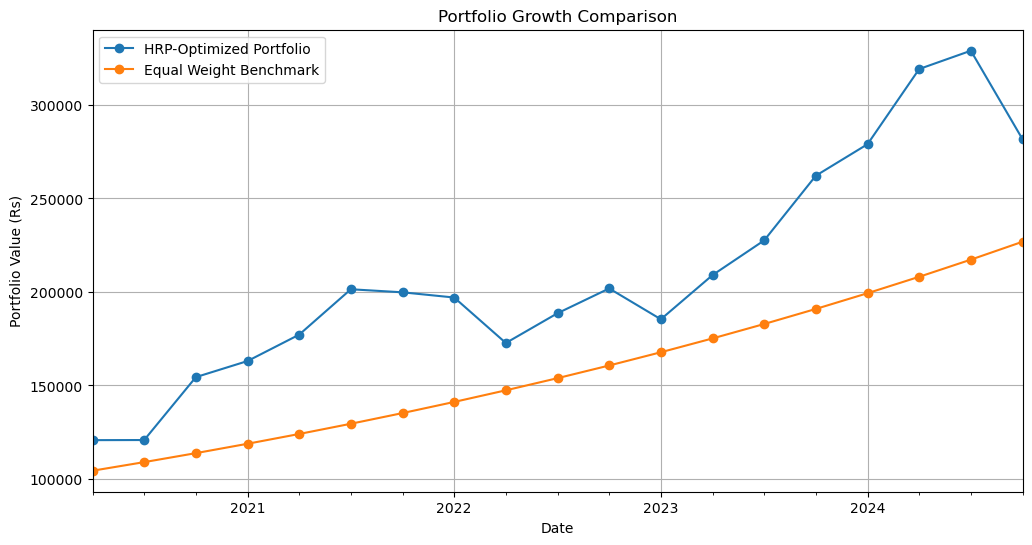

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Download and Setup
# ----------------------------
# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Create a DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# ----------------------------
# 2. HRP Weight Calculation
# ----------------------------
def get_hrp_weights(returns):
    """
    Calculate HRP weights for a set of returns.
    Steps:
      1. Compute the correlation matrix and convert to distance matrix.
      2. Perform hierarchical clustering using Ward linkage.
      3. Order tickers by cluster leaves.
      4. Allocate weights recursively based on cluster sizes.
    """
    corr = returns.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    link = sch.linkage(ssd.squareform(dist), method='ward')
    
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
    
    return weights / weights.sum()

# ----------------------------
# 3. Rebalancing Simulation (Quarterly)
# ----------------------------
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
cumulative_value = initial_capital
quarterly_results = []

print("\n--- HRP-Weighted Quarterly Rebalancing with Top 5 Sector Selection ---\n")

for i, q_end in enumerate(quarter_end_dates):
    # Define the rebalancing period start date
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    if q_start >= prices.index[-1]:
        continue

    # Use data prior to the rebalance date for training (last 252 days ~1 year)
    training_end = q_start - pd.Timedelta(days=1)
    training_prices = prices[prices.index <= training_end]
    if training_prices.empty:
        continue
    training_returns = training_prices.pct_change().dropna()
    
    # Rank sectors using the Sharpe ratio and select top 5 sectors
    sharpe_scores = training_returns.mean() / training_returns.std()
    top_5_sectors = sharpe_scores.nlargest(7).index.tolist()
    
    # Compute HRP weights on the training returns of the selected sectors
    selected_training_returns = training_returns[top_5_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    
    # Get period prices for the selected sectors
    period_prices = prices[(prices.index >= q_start) & (prices.index <= q_end)][top_5_sectors]
    if period_prices.empty:
        continue
    start_prices = period_prices.iloc[0]
    end_prices = period_prices.iloc[-1]
    sector_period_returns = (end_prices / start_prices) - 1
    
    # Compute portfolio return using HRP weights
    portfolio_return = np.dot(hrp_weights, sector_period_returns)
    cumulative_value *= (1 + portfolio_return)
    
    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': top_5_sectors,
        'hrp_weights': hrp_weights.to_dict(),
        'portfolio_return': portfolio_return,
        'sector_returns': sector_period_returns.to_dict(),
        'cumulative_value': cumulative_value
    })
    
    print(f"\nQuarter {q_start.date()} to {q_end.date()}:")
    print(f"Selected Sectors: {top_5_sectors}")
    print("HRP Weights:")
    for sector, weight in hrp_weights.items():
        print(f"  {sector}: {weight:.2%}")
    print("\nSector Returns:")
    for sector, ret in sector_period_returns.items():
        print(f"  {sector}: {ret:.2%}")
    print(f"\nPortfolio Return: {portfolio_return:.2%}")
    print(f"Cumulative Value: Rs. {cumulative_value:,.2f}")
    print("="*80)

# Benchmark: Calculate equally weighted benchmark return
full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
equally_weighted_return = full_period_returns.mean()
benchmark_value = initial_capital * (1 + equally_weighted_return)

print("\n=== Final Results ===")
print(f"Initial Capital: Rs. {initial_capital:,.2f}")
print(f"Final HRP-Optimized Portfolio Value: Rs. {cumulative_value:,.2f}")
print(f"Equally Weighted Benchmark Value: Rs. {benchmark_value:,.2f}")
print(f"Outperformance: Rs. {cumulative_value - benchmark_value:,.2f}")

# Plot portfolio growth
portfolio_growth = pd.Series(
    {result['quarter_end']: result['cumulative_value'] for result in quarterly_results}
)
benchmark_growth = pd.Series(
    {result['quarter_end']: initial_capital * (1 + equally_weighted_return) ** ((i+1)/len(quarterly_results))
     for i, result in enumerate(quarterly_results)}
)

plt.figure(figsize=(12, 6))
portfolio_growth.plot(label='HRP-Optimized Portfolio', marker='o')
benchmark_growth.plot(label='Equal Weight Benchmark', marker='o')
plt.title("Portfolio Growth Comparison")
plt.ylabel("Portfolio Value (Rs)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#Top 3 to 10 sector HRP simulation and advisory

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of in


--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---


For n = 3 sectors, Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC']
HRP Weights:
  ^CNXIT: 37.50%
  ^CNXFMCG: 12.50%
  ^CNXMNC: 50.00%

Sector Returns:
  ^CNXFMCG: 14.05%
  ^CNXIT: 22.48%
  ^CNXMNC: 22.57%

Portfolio Return: 21.47%
Cumulative Value: Rs. 121,472.97

For n = 3 sectors, Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXINFRA']
HRP Weights:
  ^CNXFMCG: 37.50%
  ^CNXENERGY: 12.50%
  ^CNXINFRA: 50.00%

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXINFRA: 1.63%

Portfolio Return: 0.81%
Cumulative Value: Rs. 122,456.68

For n = 3 sectors, Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXENERGY']
HRP Weights:
  ^CNXIT: 37.50%
  ^CNXAUTO: 12.50%
  ^CNXENERGY: 50.00%

Sector Returns:
  ^CNXIT: 20.59%
  ^CNXAUTO: 15.41%
  ^CNXENERGY: 12.44%

Portfolio Return: 15.87%
Cumulative Value: Rs. 141,8

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 3 sectors, Quarter 2024-10-01 to 2024-12-31:
Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO']
HRP Weights:
  ^CNXAUTO: 37.50%
  ^CNXPSE: 12.50%
  ^CNXINFRA: 50.00%

Sector Returns:
  ^CNXPSE: -15.20%
  ^CNXINFRA: -11.43%
  ^CNXAUTO: -15.69%

Portfolio Return: -13.50%
Cumulative Value: Rs. 299,590.14

For n = 4 sectors, Quarter 2020-04-01 to 2020-06-30:
Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY']
HRP Weights:
  ^CNXFMCG: 31.58%
  ^CNXMNC: 10.53%
  ^CNXIT: 10.53%
  ^CNXENERGY: 47.37%

Sector Returns:
  ^CNXFMCG: 14.05%
  ^CNXIT: 22.48%
  ^CNXMNC: 22.57%
  ^CNXENERGY: 33.65%

Portfolio Return: 25.12%
Cumulative Value: Rs. 125,119.62

For n = 4 sectors, Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXINFRA', '^CNXMNC']
HRP Weights:
  ^CNXENERGY: 31.58%
  ^CNXINFRA: 10.53%
  ^CNXFMCG: 10.53%
  ^CNXMNC: 47.37%

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXINFRA: 1.63%
  ^CNXMNC: 6.58%

Portfolio Return: 

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 5 sectors, Quarter 2020-07-01 to 2020-09-30:
Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXINFRA', '^CNXMNC', '^CNXIT']
HRP Weights:
  ^CNXFMCG: 28.04%
  ^CNXMNC: 9.35%
  ^CNXIT: 9.35%
  ^CNXENERGY: 8.41%
  ^CNXINFRA: 44.86%

Sector Returns:
  ^CNXFMCG: -1.29%
  ^CNXENERGY: 3.82%
  ^CNXINFRA: 1.63%
  ^CNXMNC: 6.58%
  ^CNXIT: 35.43%

Portfolio Return: 4.62%
Cumulative Value: Rs. 131,721.10

For n = 5 sectors, Quarter 2020-10-01 to 2020-12-31:
Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXENERGY', '^CNXMNC', '^CNXFMCG']
HRP Weights:
  ^CNXIT: 28.04%
  ^CNXMNC: 9.35%
  ^CNXFMCG: 9.35%
  ^CNXAUTO: 8.41%
  ^CNXENERGY: 44.86%

Sector Returns:
  ^CNXIT: 20.59%
  ^CNXAUTO: 15.41%
  ^CNXENERGY: 12.44%
  ^CNXMNC: 11.34%
  ^CNXFMCG: 13.89%

Portfolio Return: 15.01%
Cumulative Value: Rs. 151,490.90

For n = 5 sectors, Quarter 2021-01-01 to 2021-03-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXAUTO', '^CNXMNC', '^CNXFMCG']
HRP Weights:
  ^CNXMETAL: 28.04%
  ^CNXAUTO: 9.35%
  ^CNXI

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 6 sectors, Quarter 2022-01-01 to 2022-03-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXMNC', '^CNXREALTY']
HRP Weights:
  ^CNXIT: 25.64%
  ^CNXREALTY: 8.55%
  ^CNXMETAL: 8.55%
  ^CNXMNC: 7.69%
  ^CNXINFRA: 6.84%
  ^CNXENERGY: 42.74%

Sector Returns:
  ^CNXIT: -7.17%
  ^CNXMETAL: 14.14%
  ^CNXINFRA: 0.16%
  ^CNXENERGY: 13.01%
  ^CNXMNC: -6.44%
  ^CNXREALTY: -5.33%

Portfolio Return: 3.99%
Cumulative Value: Rs. 210,148.24

For n = 6 sectors, Quarter 2022-04-01 to 2022-06-30:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXREALTY']
HRP Weights:
  ^CNXIT: 25.64%
  ^CNXREALTY: 8.55%
  ^CNXMETAL: 8.55%
  ^CNXSERVICE: 7.69%
  ^CNXENERGY: 6.84%
  ^CNXINFRA: 42.74%

Sector Returns:
  ^CNXIT: -23.39%
  ^CNXMETAL: -28.04%
  ^CNXENERGY: -5.09%
  ^CNXINFRA: -9.34%
  ^CNXSERVICE: -13.53%
  ^CNXREALTY: -18.81%

Portfolio Return: -15.38%
Cumulative Value: Rs. 177,825.04

For n = 6 sectors, Quarter 2022-07-01 to 2022-09-3

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 7 sectors, Quarter 2021-10-01 to 2021-12-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXREALTY', '^CNXMNC', '^CNXFMCG']
HRP Weights:
  ^CNXIT: 23.89%
  ^CNXMNC: 7.96%
  ^CNXFMCG: 7.96%
  ^CNXREALTY: 7.17%
  ^CNXMETAL: 6.37%
  ^CNXINFRA: 5.69%
  ^CNXENERGY: 40.96%

Sector Returns:
  ^CNXIT: 11.27%
  ^CNXMETAL: -2.08%
  ^CNXINFRA: -1.46%
  ^CNXENERGY: -1.60%
  ^CNXREALTY: -4.33%
  ^CNXMNC: 0.42%
  ^CNXFMCG: -6.98%

Portfolio Return: 0.99%
Cumulative Value: Rs. 205,232.39

For n = 7 sectors, Quarter 2022-01-01 to 2022-03-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXMNC', '^CNXREALTY', '^CNXSERVICE']
HRP Weights:
  ^CNXIT: 23.89%
  ^CNXREALTY: 7.96%
  ^CNXMETAL: 7.96%
  ^CNXINFRA: 7.17%
  ^CNXENERGY: 6.37%
  ^CNXMNC: 5.69%
  ^CNXSERVICE: 40.96%

Sector Returns:
  ^CNXIT: -7.17%
  ^CNXMETAL: 14.14%
  ^CNXINFRA: 0.16%
  ^CNXENERGY: 13.01%
  ^CNXMNC: -6.44%
  ^CNXREALTY: -5.33%
  ^CNXSERVICE: -2.53%

Portfolio Return: -1

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 8 sectors, Quarter 2022-07-01 to 2022-09-30:
Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXFMCG', '^CNXPSE']
HRP Weights:
  ^CNXMETAL: 22.54%
  ^CNXPSE: 7.51%
  ^CNXENERGY: 7.51%
  ^CNXINFRA: 6.76%
  ^CNXIT: 6.01%
  ^CNXAUTO: 5.37%
  ^CNXMNC: 4.83%
  ^CNXFMCG: 39.45%

Sector Returns:
  ^CNXIT: -3.86%
  ^CNXENERGY: 6.05%
  ^CNXMETAL: 22.82%
  ^CNXINFRA: 9.20%
  ^CNXAUTO: 8.43%
  ^CNXMNC: 11.17%
  ^CNXFMCG: 14.67%
  ^CNXPSE: 6.92%

Portfolio Return: 13.29%
Cumulative Value: Rs. 192,250.53

For n = 8 sectors, Quarter 2022-10-01 to 2022-12-31:
Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXAUTO', '^CNXMNC', '^CNXSERVICE']
HRP Weights:
  ^CNXAUTO: 22.54%
  ^CNXSERVICE: 7.51%
  ^CNXMETAL: 7.51%
  ^CNXENERGY: 6.76%
  ^CNXINFRA: 6.01%
  ^CNXIT: 5.37%
  ^CNXFMCG: 4.83%
  ^CNXMNC: 39.45%

Sector Returns:
  ^CNXMETAL: 20.19%
  ^CNXENERGY: 2.69%
  ^CNXIT: 7.08%
  ^CNXINFRA: 6.80%
  ^CNXFMCG: 1.60%
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 9 sectors, Quarter 2022-07-01 to 2022-09-30:
Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXFMCG', '^CNXPSE', '^CNXSERVICE']
HRP Weights:
  ^CNXMETAL: 21.47%
  ^CNXPSE: 7.16%
  ^CNXENERGY: 7.16%
  ^CNXINFRA: 6.44%
  ^CNXIT: 5.72%
  ^CNXMNC: 5.11%
  ^CNXFMCG: 4.60%
  ^CNXAUTO: 4.17%
  ^CNXSERVICE: 38.17%

Sector Returns:
  ^CNXIT: -3.86%
  ^CNXENERGY: 6.05%
  ^CNXMETAL: 22.82%
  ^CNXINFRA: 9.20%
  ^CNXAUTO: 8.43%
  ^CNXMNC: 11.17%
  ^CNXFMCG: 14.67%
  ^CNXPSE: 6.92%
  ^CNXSERVICE: 9.33%

Portfolio Return: 11.36%
Cumulative Value: Rs. 200,324.21

For n = 9 sectors, Quarter 2022-10-01 to 2022-12-31:
Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXAUTO', '^CNXMNC', '^CNXSERVICE', '^CNXPSE']
HRP Weights:
  ^CNXMETAL: 21.47%
  ^CNXPSE: 7.16%
  ^CNXENERGY: 7.16%
  ^CNXINFRA: 6.44%
  ^CNXIT: 5.72%
  ^CNXFMCG: 5.11%
  ^CNXMNC: 4.60%
  ^CNXAUTO: 4.17%
  ^CNXSERVICE: 38.17%

Sector Returns:
  ^CNXMETA

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size


For n = 10 sectors, Quarter 2022-01-01 to 2022-03-31:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXMNC', '^CNXREALTY', '^CNXSERVICE', '^CNXAUTO', '^CNXFMCG', '^CNXPSE']
HRP Weights:
  ^CNXIT: 20.58%
  ^CNXMNC: 6.86%
  ^CNXFMCG: 6.86%
  ^CNXMETAL: 6.18%
  ^CNXPSE: 5.49%
  ^CNXINFRA: 4.90%
  ^CNXENERGY: 4.41%
  ^CNXREALTY: 4.00%
  ^CNXSERVICE: 3.66%
  ^CNXAUTO: 37.05%

Sector Returns:
  ^CNXIT: -7.17%
  ^CNXMETAL: 14.14%
  ^CNXINFRA: 0.16%
  ^CNXENERGY: 13.01%
  ^CNXMNC: -6.44%
  ^CNXREALTY: -5.33%
  ^CNXSERVICE: -2.53%
  ^CNXAUTO: -5.06%
  ^CNXFMCG: -3.51%
  ^CNXPSE: 5.07%

Portfolio Return: -2.61%
Cumulative Value: Rs. 213,467.83

For n = 10 sectors, Quarter 2022-04-01 to 2022-06-30:
Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXREALTY', '^CNXMNC', '^CNXPSE', '^CNXAUTO', '^CNXMEDIA']
HRP Weights:
  ^CNXMETAL: 20.58%
  ^CNXPSE: 6.86%
  ^CNXENERGY: 6.86%
  ^CNXINFRA: 6.18%
  ^CNXIT: 5.49%
  ^CNXMEDIA: 4.90%
  ^CNXRE

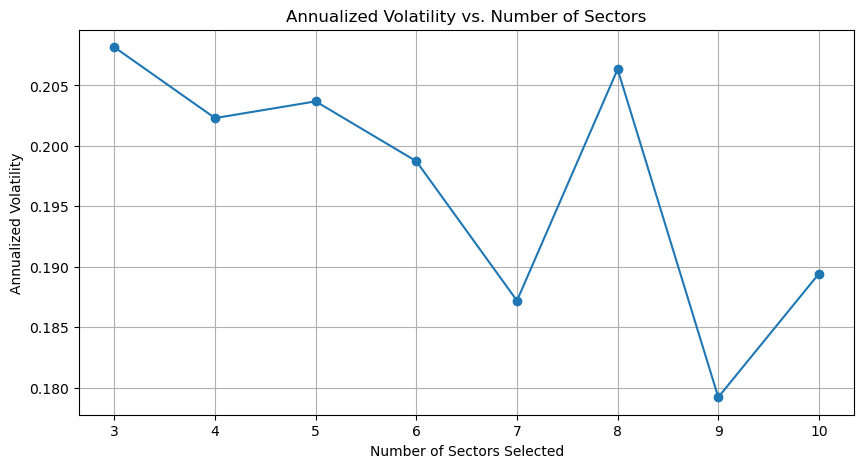


--- Investment Advice as of 2025-02-10 ---

Based on the past year of data ( 2024-06-02 to 2025-02-09 ):

--- Top 3 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG']
Recommended HRP Weights:
  ^CNXIT: 12.50%
  ^CNXSERVICE: 50.00%
  ^CNXFMCG: 37.50%
------------------------------------------------------------
--- Top 4 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK']
Recommended HRP Weights:
  ^CNXIT: 10.53%
  ^CNXSERVICE: 10.53%
  ^CNXFMCG: 31.58%
  ^NSEBANK: 47.37%
------------------------------------------------------------
--- Top 5 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK', '^CNXAUTO']
Recommended HRP Weights:
  ^CNXIT: 9.35%
  ^CNXSERVICE: 8.41%
  ^CNXFMCG: 28.04%
  ^NSEBANK: 44.86%
  ^CNXAUTO: 9.35%
------------------------------------------------------------
--- Top 6 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG',

C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:192: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  advice_training_prices = prices.loc[advice_training_start:advice_training_end].fillna(method='ffill')
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_26788\127337139.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\L

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Download and Setup
# ----------------------------
# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

# Create a DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# ----------------------------
# 2. HRP Weight Calculation Function
# ----------------------------
def get_hrp_weights(returns):
    """
    Calculate HRP weights for a set of returns.
    Steps:
      1. Compute the correlation matrix and convert to a distance matrix.
      2. Perform hierarchical clustering using Ward linkage.
      3. Order tickers by cluster leaves.
      4. Allocate weights recursively based on cluster sizes.
    """
    corr = returns.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    link = sch.linkage(ssd.squareform(dist), method='ward')
    
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
    
    return weights / weights.sum()

# ----------------------------
# 3. Portfolio Rebalancing Simulation (Quarterly)
# ----------------------------
# We'll simulate quarterly rebalancing.
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')

initial_capital = 100000
results_summary = []  # To store simulation results for each n
all_quarterly_results = {}  # Dictionary to store detailed quarterly results for each n

print("\n--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---\n")

# Iterate over n from 3 to 10 sectors
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # To store period returns (for volatility calculation)
    quarterly_results = []  # Detailed results per quarter
    
    for i, q_end in enumerate(quarter_end_dates):
        # Define rebalancing period: from previous quarter end + 1 day (or first day) to current quarter end
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            continue
        
        # Use data prior to q_start for training (last 252 days ~1 year)
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Rank sectors by Sharpe ratio using training data
        sharpe_scores = training_returns.mean() / training_returns.std()
        # Select top n sectors (if available)
        selected_sectors = sharpe_scores.nlargest(n).index.tolist()
        
        # Compute HRP weights on the training returns of the selected sectors
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        # Get period prices for the selected sectors
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Portfolio return using HRP weights on the selected sectors
        portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)
        
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'portfolio_return': portfolio_return,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value
        })
        
        # Optionally print details for each quarter
        print(f"\nFor n = {n} sectors, Quarter {q_start.date()} to {q_end.date()}:")
        print(f"Selected Sectors: {selected_sectors}")
        print("HRP Weights:")
        for sector, weight in hrp_weights.items():
            if sector in selected_sectors:
                print(f"  {sector}: {weight:.2%}")
        print("\nSector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"  {sector}: {ret:.2%}")
        print(f"\nPortfolio Return: {portfolio_return:.2%}")
        print(f"Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("="*80)
    
    # Compute annualized volatility of quarterly returns for this n (if at least 2 quarters)
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan
    
    # Benchmark: Equally weighted return across all sectors (for reference)
    full_period_returns = (prices.iloc[-1] / prices.iloc[0]) - 1
    equally_weighted_return = full_period_returns.mean()
    benchmark_value = initial_capital * (1 + equally_weighted_return)
    
    results_summary.append({
        'Number of Sectors': n,
        'Final Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol,
        'Outperformance': cumulative_value - benchmark_value
    })
    all_quarterly_results[n] = quarterly_results
    # Reset cumulative value for next simulation iteration
    cumulative_value = initial_capital

# Convert summary to DataFrame and display
results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for Different Top N Sector Portfolios ===")
print(results_df[['Number of Sectors', 'Final Portfolio Value', 'Annualized Volatility', 'Outperformance']])

# Plot: Volatility vs. Number of Sectors
plt.figure(figsize=(10, 5))
plt.plot(results_df['Number of Sectors'], results_df['Annualized Volatility'], marker='o', linestyle='-')
plt.xlabel("Number of Sectors Selected")
plt.ylabel("Annualized Volatility")
plt.title("Annualized Volatility vs. Number of Sectors")
plt.grid(True)
plt.show()

# ----------------------------
# 4. Investment Advice for Today
# ----------------------------
# Suppose today's date is Feb 10, 2025. For simulation, we set advice_date accordingly.
advice_date = datetime(2025, 2, 10)

# For advice, use the most recent 252 days of training data ending on advice_date - 1 day.
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
# Ensure the training period is within the prices index:
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].fillna(method='ffill')
advice_training_returns = advice_training_prices.pct_change().dropna()

print("\n--- Investment Advice as of", advice_date.date(), "---\n")
print("Based on the past year of data (", advice_training_start.date(), "to", advice_training_end.date(), "):\n")
# For each n from 3 to 10, provide recommended portfolio composition:
for n in range(3, 11):
    sharpe_scores = advice_training_returns.mean() / advice_training_returns.std()
    top_n_sectors = sharpe_scores.nlargest(n).index.tolist()
    selected_training_returns = advice_training_returns[top_n_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended HRP Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {hrp_weights[sector]:.2%}")
    print("-"*60)

# End of code.

In [32]:
#FINAL COMPARISON WITH NIFTY


--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---


===== Simulating for Top 3 Sectors =====

Quarter 2020-04-01 to 2020-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC']
  HRP Weights:
    ^CNXFMCG: 12.50%
    ^CNXIT: 37.50%
    ^CNXMNC: 50.00%
  Sector Returns:
    ^CNXFMCG: 14.05%
    ^CNXIT: 22.48%
    ^CNXMNC: 22.57%
  Portfolio Return: 21.47%
  Cumulative Value: Rs. 12,147.30
--------------------------------------------------------------------------------
Quarter 2020-07-01 to 2020-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXMNC']
  HRP Weights:
    ^CNXFMCG: 12.50%
    ^CNXENERGY: 37.50%
    ^CNXMNC: 50.00%
  Sector Returns:
    ^CNXFMCG: -1.29%
    ^CNXENERGY: 3.82%
    ^CNXMNC: 6.58%
  Portfolio Return: 4.56%
  Cumulative Value: Rs. 12,701.38
--------------------------------------------------------------------------------
Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXENERGY']
  HRP Weights:
   

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXINFRA', '^CNXMNC']
  HRP Weights:
    ^CNXPSE: 31.58%
    ^CNXAUTO: 10.53%
    ^CNXINFRA: 10.53%
    ^CNXMNC: 47.37%
  Sector Returns:
    ^CNXPSE: -15.20%
    ^CNXAUTO: -15.69%
    ^CNXINFRA: -11.43%
    ^CNXMNC: -14.74%
  Portfolio Return: -14.64%
  Cumulative Value: Rs. 32,934.94
--------------------------------------------------------------------------------

===== Simulating for Top 5 Sectors =====

Quarter 2020-04-01 to 2020-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC', '^CNXENERGY', '^CNXPSE']
  HRP Weights:
    ^CNXFMCG: 8.41%
    ^CNXIT: 9.35%
    ^CNXMNC: 44.86%
    ^CNXENERGY: 28.04%
    ^CNXPSE: 9.35%
  Sector Returns:
    ^CNXFMCG: 14.05%
    ^CNXIT: 22.48%
    ^CNXMNC: 22.57%
    ^CNXENERGY: 33.65%
    ^CNXPSE: 16.18%
  Portfolio Return: 24.35%
  Cumulative Value: Rs. 12,435.43
--------------------------------------------------------------------------------
Quarter 2020-07-01

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXMETAL', '^CNXAUTO', '^CNXENERGY', '^CNXFMCG']
  HRP Weights:
    ^CNXPSE: 7.69%
    ^CNXINFRA: 6.84%
    ^CNXMETAL: 8.55%
    ^CNXAUTO: 8.55%
    ^CNXENERGY: 42.74%
    ^CNXFMCG: 25.64%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXINFRA: 14.53%
    ^CNXMETAL: 2.91%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXFMCG: -5.70%
  Portfolio Return: 9.12%
  Cumulative Value: Rs. 28,844.65
--------------------------------------------------------------------------------
Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK']
  HRP Weights:
    ^CNXPSE: 7.69%
    ^CNXINFRA: 6.84%
    ^CNXAUTO: 8.55%
    ^CNXENERGY: 42.74%
    ^CNXMETAL: 8.55%
    ^CNXPSUBANK: 25.64%
  Sector Returns:
    ^CNXPSE: 14.99%
    ^CNXINFRA: 8.44%
    ^CNXAUTO: 17.84%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
    ^CNXPSUBANK: 3.55%
  Portfolio Return: 

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 22.54%
    ^CNXENERGY: 7.51%
    ^CNXIT: 6.01%
    ^CNXFMCG: 4.83%
    ^CNXINFRA: 6.76%
    ^CNXAUTO: 5.37%
    ^CNXMNC: 39.45%
    ^CNXPSE: 7.51%
  Sector Returns:
    ^CNXMETAL: 20.19%
    ^CNXENERGY: 2.69%
    ^CNXIT: 7.08%
    ^CNXFMCG: 1.60%
    ^CNXINFRA: 6.80%
    ^CNXAUTO: 1.37%
    ^CNXMNC: 1.85%
    ^CNXPSE: 9.43%
  Portfolio Return: 7.23%
  Cumulative Value: Rs. 20,592.11
--------------------------------------------------------------------------------
Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXPSUBANK', '^CNXFMCG', '^CNXAUTO', '^CNXMNC']
  HRP Weights:
    ^CNXMETAL: 7.51%
    ^CNXENERGY: 6.76%
    ^CNXIT: 5.37%
    ^CNXINFRA: 6.01%
    ^CNXPSUBANK: 22.54%
    ^CNXFMCG: 4.83%
    ^CNXAUTO: 7.51%
    ^CNXMNC: 39.45%
  Sector Returns

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXMNC', '^CNXREALTY', '^CNXSERVICE', '^CNXAUTO', '^CNXPSE', '^CNXFMCG']
  HRP Weights:
    ^CNXIT: 20.58%
    ^CNXMETAL: 6.18%
    ^CNXINFRA: 4.90%
    ^CNXENERGY: 4.41%
    ^CNXMNC: 6.86%
    ^CNXREALTY: 4.00%
    ^CNXSERVICE: 3.66%
    ^CNXAUTO: 37.05%
    ^CNXPSE: 5.49%
    ^CNXFMCG: 6.86%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMETAL: 14.14%
    ^CNXINFRA: 0.16%
    ^CNXENERGY: 13.01%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXSERVICE: -2.53%
    ^CNXAUTO: -5.06%
    ^CNXPSE: 5.07%
    ^CNXFMCG: -3.51%
  Portfolio Return: -2.61%
  Cumulative Value: Rs. 21,341.06
--------------------------------------------------------------------------------
Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXREALTY', '^CNXMNC', '^CNXPSE', '^CNXAUTO', '^CNXMEDIA']
  HRP Weights:
    ^CNXIT: 5.49%
    ^CNXMET

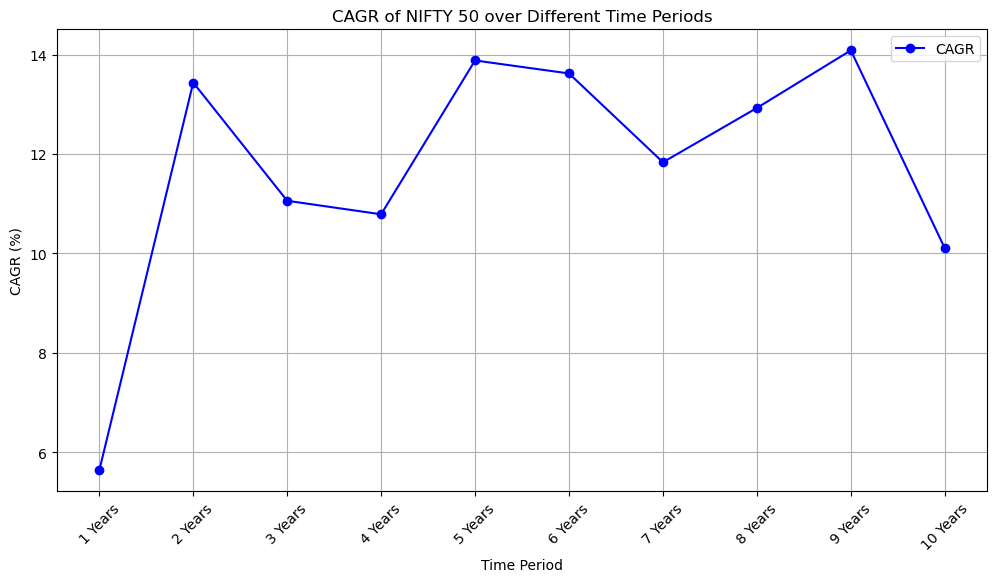


=== Comparison: HRP Portfolio vs. NIFTY 50 (5-Year) ===
   Number of Sectors  HRP Portfolio Value  NIFTY 5-Year Value  \
0                  3         31073.900940        19153.398824   
1                  4         32934.940204        19153.398824   
2                  5         30382.427817        19153.398824   
3                  6         27370.286976        19153.398824   
4                  7         30450.647884        19153.398824   
5                  8         26397.131700        19153.398824   
6                  9         33617.650856        19153.398824   
7                 10         35291.998730        19153.398824   

   Absolute Outperformance  Percentage Outperformance (%)  
0             11920.502116                      62.237007  
1             13781.541380                      71.953503  
2             11229.028993                      58.626822  
3              8216.888152                      42.900418  
4             11297.249060                      58.982999

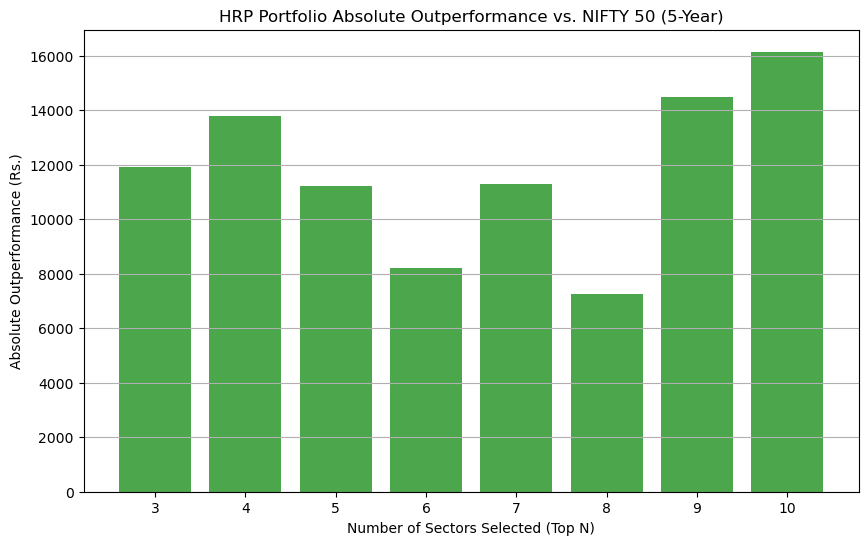


--- Investment Advice as of 2025-02-10 ---

Using training data from 2024-06-02 to 2025-02-09:

--- Top 3 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG']
Recommended HRP Weights:
  ^CNXIT: 12.50%
  ^CNXSERVICE: 50.00%
  ^CNXFMCG: 37.50%
------------------------------------------------------------
--- Top 4 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK']
Recommended HRP Weights:
  ^CNXIT: 10.53%
  ^CNXSERVICE: 10.53%
  ^CNXFMCG: 31.58%
  ^NSEBANK: 47.37%
------------------------------------------------------------
--- Top 5 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK', '^CNXAUTO']
Recommended HRP Weights:
  ^CNXIT: 9.35%
  ^CNXSERVICE: 8.41%
  ^CNXFMCG: 28.04%
  ^NSEBANK: 44.86%
  ^CNXAUTO: 9.35%
------------------------------------------------------------
--- Top 6 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\2999189215.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# =============================================================================
# 1. Data Download and Setup for Sector Data
# =============================================================================

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# 2. HRP Weight Calculation Function
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate HRP weights for a set of returns.
    Steps:
      1. Compute the correlation matrix and convert to a distance matrix.
      2. Perform hierarchical clustering using Ward linkage.
      3. Order tickers by cluster leaves.
      4. Allocate weights recursively based on cluster sizes.
    Note: This is a simplified version of HRP allocation.
    """
    corr = returns_df.corr()
    # Convert correlation to distance
    dist = np.sqrt(0.5 * (1 - corr))
    # Compute linkage using Ward method
    link = sch.linkage(ssd.squareform(dist), method='ward')
    # Get the order of tickers from the leaves of the dendrogram
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    # Initialize equal weights and cluster sizes for each ticker
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    # A simple pairwise rebalancing along the ordered list
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
        
    return weights / weights.sum()

# =============================================================================
# 3. HRP Portfolio Rebalancing Simulation (Quarterly)
# =============================================================================

print("\n--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---\n")

# We'll simulate quarterly rebalancing.
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')

initial_capital = 10000
results_summary = []       # To store summary simulation results for each n
all_quarterly_results = {} # To store detailed quarterly results for each n

# Loop for different top-n sector selections (n = 3,4,...,10)
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # For volatility (each quarter's return)
    quarterly_results = []  # Detailed results per quarter

    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    # Loop over each quarter end date for rebalancing
    for i, q_end in enumerate(quarter_end_dates):
        # Define the rebalancing period: from previous quarter end + 1 day (or the very start) to current quarter end
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break  # Not enough data
        
        # Use data prior to q_start for training (approximately last 252 days ~1 year)
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Rank sectors by Sharpe ratio (mean/volatility) using training data
        sharpe_scores = training_returns.mean() / training_returns.std()
        # Select top n sectors (if available)
        selected_sectors = sharpe_scores.nlargest(n).index.tolist()
        
        # Compute HRP weights using the training returns of the selected sectors
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        # Get period prices for the selected sectors in the rebalancing period
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Calculate portfolio return using HRP weights on the selected sectors
        portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)
        
        # Store detailed quarterly result
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'portfolio_return': portfolio_return,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value
        })
        
        # Print quarterly details
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {hrp_weights[sector]:.2%}")
        print("  Sector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"    {sector}: {ret:.2%}")
        print(f"  Portfolio Return: {portfolio_return:.2%}")
        print(f"  Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("-" * 80)
        
    # Calculate annualized volatility (quarterly returns * sqrt(4) since 4 quarters per year)
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan

    # (Note: The originally computed "benchmark" here was based on equally weighted sector returns.
    #  We will later compare against the NIFTY benchmark.)
    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

# Convert simulation summary to DataFrame and display
hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df[['Number of Sectors', 'HRP Portfolio Value', 'Annualized Volatility']])

# =============================================================================
# 4. NIFTY Benchmark Analysis (Using Provided Code)
# =============================================================================

# Define the benchmark index ticker for NIFTY 50
benchmark_ticker = "^NSEI"

# We will compute the benchmark performance over various time periods.
# (Here, we download data from the earliest required start date for up to 10 years.)
end_date_bench = datetime.today()
# For multiple periods: from 1 to 10 years.
time_periods = {f"{i} Years": end_date_bench - timedelta(days=365 * i) for i in range(1, 11)}

# Initial investment for benchmark
initial_capital_bench = 10000
benchmark_results = []

# Download benchmark data (from the earliest needed date)
earliest_start = min(time_periods.values())
benchmark_data = yf.download(benchmark_ticker, start=earliest_start, end=end_date_bench, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded. Check the ticker or network connection.")

benchmark_data = benchmark_data['Adj Close']

for period, start_dt in time_periods.items():
    filtered_data = benchmark_data[benchmark_data.index >= pd.Timestamp(start_dt)]
    if filtered_data.empty:
        continue
    
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    
    # Calculate total return over the period
    total_return = (end_price / start_price) - 1
    # Calculate CAGR (Compound Annual Growth Rate)
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    
    # Final portfolio value
    final_value = initial_capital_bench * (1 + total_return)
    
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return (%)': total_return * 100,
        'CAGR (%)': cagr * 100,
        'Final Portfolio Value': final_value
    })

# Convert benchmark results to DataFrame and display
benchmark_results_df = pd.DataFrame(benchmark_results)
print("\n=== NIFTY 50 Benchmark Performance over Different Time Periods ===")
print(benchmark_results_df)

# (Optional) Save the NIFTY benchmark results to Excel
excel_filename = "NIFTY_Benchmark_Comparison.xlsx"
benchmark_results_df.to_excel(excel_filename, index=False)
print(f"\nNIFTY Benchmark results saved to {excel_filename}")

# Plotting the CAGR over time for NIFTY benchmark
plt.figure(figsize=(12, 6))
plt.plot(benchmark_results_df['Time Period'], benchmark_results_df['CAGR (%)'], marker='o', linestyle='-', color='b', label='CAGR')
plt.xlabel("Time Period")
plt.ylabel("CAGR (%)")
plt.title("CAGR of NIFTY 50 over Different Time Periods")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# =============================================================================
# 5. Comparison Analysis: HRP Portfolio vs. NIFTY Benchmark (5-Year)
# =============================================================================

# For comparison, we use the 5-Year benchmark result.
bench_5yr = benchmark_results_df[benchmark_results_df["Time Period"] == "5 Years"]
if bench_5yr.empty:
    raise ValueError("5-Year benchmark data not available.")
nifty_5yr_final = bench_5yr.iloc[0]['Final Portfolio Value']

# Add comparison columns to the HRP simulation summary
comparison_df = hrp_results_df.copy()
comparison_df['NIFTY 5-Year Value'] = nifty_5yr_final
comparison_df['Absolute Outperformance'] = comparison_df['HRP Portfolio Value'] - nifty_5yr_final
comparison_df['Percentage Outperformance (%)'] = (comparison_df['Absolute Outperformance'] / nifty_5yr_final) * 100

print("\n=== Comparison: HRP Portfolio vs. NIFTY 50 (5-Year) ===")
print(comparison_df[['Number of Sectors', 'HRP Portfolio Value', 'NIFTY 5-Year Value', 
                     'Absolute Outperformance', 'Percentage Outperformance (%)']])

# =============================================================================
# 6. (Optional) Plotting the Outperformance vs. Number of Sectors
# =============================================================================

plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Number of Sectors'], comparison_df['Absolute Outperformance'], color='green', alpha=0.7)
plt.xlabel("Number of Sectors Selected (Top N)")
plt.ylabel("Absolute Outperformance (Rs.)")
plt.title("HRP Portfolio Absolute Outperformance vs. NIFTY 50 (5-Year)")
plt.grid(axis='y')
plt.show()

# =============================================================================
# 7. Investment Advice for Today (Using Last 1 Year Data)
# =============================================================================

# Suppose today's date is Feb 10, 2025.
advice_date = datetime(2025, 2, 10)
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
# Ensure the training period is within available data:
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---\n")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")

for n in range(3, 11):
    sharpe_scores = advice_training_returns.mean() / advice_training_returns.std()
    top_n_sectors = sharpe_scores.nlargest(n).index.tolist()
    selected_training_returns = advice_training_returns[top_n_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended HRP Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {hrp_weights[sector]:.2%}")
    print("-" * 60)

In [1]:
#The above comparison code but with 0.1% transactional charges per trade


--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---


===== Simulating for Top 3 Sectors =====

Quarter 2020-04-01 to 2020-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC']
  HRP Weights:
    ^CNXFMCG: 12.50%
    ^CNXIT: 37.50%
    ^CNXMNC: 50.00%
  Transaction Cost: Rs. 100.00
  Sector Returns:
    ^CNXFMCG: 14.05%
    ^CNXIT: 22.48%
    ^CNXMNC: 22.57%
  Portfolio Return: 21.47%
  Cumulative Value: Rs. 121,351.49
--------------------------------------------------------------------------------
Quarter 2020-07-01 to 2020-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXMNC']
  HRP Weights:
    ^CNXFMCG: 12.50%
    ^CNXENERGY: 37.50%
    ^CNXMNC: 50.00%
  Transaction Cost: Rs. 45.51
  Sector Returns:
    ^CNXFMCG: -1.29%
    ^CNXENERGY: 3.82%
    ^CNXMNC: 6.58%
  Portfolio Return: 4.56%
  Cumulative Value: Rs. 126,839.15
--------------------------------------------------------------------------------
Quarter 2020-10-01 to 2020-12-31:
  Selected S

C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY']
  HRP Weights:
    ^CNXPSE: 10.53%
    ^CNXINFRA: 10.53%
    ^CNXAUTO: 31.58%
    ^CNXENERGY: 47.37%
  Transaction Cost: Rs. 154.59
  Sector Returns:
    ^CNXPSE: 14.99%
    ^CNXINFRA: 8.44%
    ^CNXAUTO: 17.84%
    ^CNXENERGY: 5.82%
  Portfolio Return: 10.86%
  Cumulative Value: Rs. 361,625.74
--------------------------------------------------------------------------------
Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXAUTO', '^CNXMNC']
  HRP Weights:
    ^CNXPSE: 31.58%
    ^CNXINFRA: 10.53%
    ^CNXAUTO: 10.53%
    ^CNXMNC: 47.37%
  Transaction Cost: Rs. 247.43
  Sector Returns:
    ^CNXPSE: 5.16%
    ^CNXINFRA: 4.85%
    ^CNXAUTO: 6.73%
    ^CNXMNC: 6.24%
  Portfolio Return: 5.81%
  Cumulative Value: Rs. 382,360.80
--------------------------------------------------------------------------------
Quarter 2024-10-01 to 2024-12-31:
  Selected Sec

C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXMETAL', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXIT']
  HRP Weights:
    ^CNXFMCG: 8.55%
    ^CNXMETAL: 8.55%
    ^CNXINFRA: 6.84%
    ^CNXAUTO: 7.69%
    ^CNXMNC: 42.74%
    ^CNXIT: 25.64%
  Transaction Cost: Rs. 128.58
  Sector Returns:
    ^CNXFMCG: -2.16%
    ^CNXMETAL: 8.99%
    ^CNXINFRA: 7.92%
    ^CNXAUTO: 7.13%
    ^CNXMNC: 0.84%
    ^CNXIT: 8.02%
  Portfolio Return: 4.09%
  Cumulative Value: Rs. 217,355.04
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXINFRA', '^CNXPSE', '^CNXAUTO', '^CNXFMCG', '^CNXPSUBANK']
  HRP Weights:
    ^CNXMETAL: 7.69%
    ^CNXINFRA: 6.84%
    ^CNXPSE: 42.74%
    ^CNXAUTO: 8.55%
    ^CNXFMCG: 25.64%
    ^CNXPSUBANK: 8.55%
  Transaction Cost: Rs. 150.48
  Sector Returns:
    ^CNXMETAL: 17.36%
    ^CNXINFRA: 17.17%
    ^CNXPSE: 32.03%
    ^CNXAUTO: 16.43%
    ^CNXFMCG: 11.04%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXMNC', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 22.54%
    ^CNXENERGY: 7.51%
    ^CNXIT: 6.01%
    ^CNXFMCG: 4.83%
    ^CNXINFRA: 6.76%
    ^CNXAUTO: 5.37%
    ^CNXMNC: 39.45%
    ^CNXPSE: 7.51%
  Transaction Cost: Rs. 66.15
  Sector Returns:
    ^CNXMETAL: 20.19%
    ^CNXENERGY: 2.69%
    ^CNXIT: 7.08%
    ^CNXFMCG: 1.60%
    ^CNXINFRA: 6.80%
    ^CNXAUTO: 1.37%
    ^CNXMNC: 1.85%
    ^CNXPSE: 9.43%
  Portfolio Return: 7.23%
  Cumulative Value: Rs. 204,818.70
--------------------------------------------------------------------------------
Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXMETAL', '^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXPSUBANK', '^CNXFMCG', '^CNXAUTO', '^CNXMNC']
  HRP Weights:
    ^CNXMETAL: 7.51%
    ^CNXENERGY: 6.76%
    ^CNXIT: 5.37%
    ^CNXINFRA: 6.01%
    ^CNXPSUBANK: 22.54%
    ^CNXFMCG: 4.83%
    ^CNXAUTO: 7.51%
    ^

C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_size)
C:\Users\sarda\AppData\Local\Temp\ipykernel_15752\3984779716.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= right_size / (left_size + right_s

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMNC', '^CNXSERVICE', '^CNXFMCG', '^CNXPSE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXIT: 6.86%
    ^CNXMETAL: 4.41%
    ^CNXINFRA: 3.66%
    ^CNXAUTO: 6.18%
    ^CNXENERGY: 37.05%
    ^CNXMNC: 20.58%
    ^CNXSERVICE: 5.49%
    ^CNXFMCG: 6.86%
    ^CNXPSE: 4.00%
    ^CNXPSUBANK: 4.90%
  Transaction Cost: Rs. 110.07
  Sector Returns:
    ^CNXIT: 20.77%
    ^CNXMETAL: 7.76%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
    ^CNXENERGY: 15.98%
    ^CNXMNC: 9.81%
    ^CNXSERVICE: 12.98%
    ^CNXFMCG: 11.57%
    ^CNXPSE: 13.65%
    ^CNXPSUBANK: -1.55%
  Portfolio Return: 12.22%
  Cumulative Value: Rs. 213,637.81
--------------------------------------------------------------------------------
Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXMETAL', '^CNXINFRA', '^CNXENERGY', '^CNXREALTY', '^CNXMNC', '^CNXFMCG', '^CNXSERVICE', '^CNXPSE', '^CNXAUTO']
  HRP Weig

Text(0.5, 1.0, 'CAGR of NIFTY 50 over Different Time Periods')

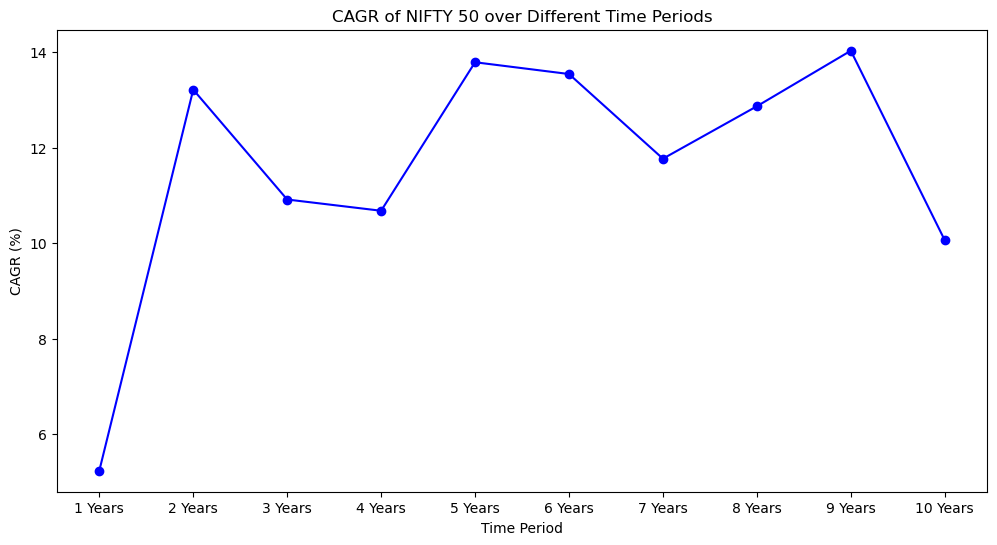

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# =============================================================================
# 1. Data Download and Setup for Sector Data
# =============================================================================

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# 2. HRP Weight Calculation Function
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate HRP weights for a set of returns.
    Steps:
      1. Compute the correlation matrix and convert to a distance matrix.
      2. Perform hierarchical clustering using Ward linkage.
      3. Order tickers by cluster leaves.
      4. Allocate weights recursively based on cluster sizes.
    """
    corr = returns_df.corr()
    # Convert correlation to distance
    dist = np.sqrt(0.5 * (1 - corr))
    # Compute linkage using Ward method
    link = sch.linkage(ssd.squareform(dist), method='ward')
    # Get the order of tickers from the leaves of the dendrogram
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    # Initialize equal weights and cluster sizes for each ticker
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    # A simple pairwise rebalancing along the ordered list
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
        
    return weights / weights.sum()

# =============================================================================
# 3. HRP Portfolio Rebalancing Simulation (Quarterly) with Transaction Costs
# =============================================================================

print("\n--- HRP-Weighted Quarterly Rebalancing with Top N Sector Selection ---\n")

# We simulate quarterly rebalancing.
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')

initial_capital = 100000
results_summary = []       # To store summary simulation results for each n
all_quarterly_results = {} # To store detailed quarterly results for each n

transaction_rate = 0.001  # 0.1% per trade

# Loop for different top-n sector selections (n = 3,4,...,10)
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # To record each quarter's return
    quarterly_results = []  # Detailed results per quarter
    prev_weights = None     # To store the previous quarter's HRP weights

    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    # Loop over each quarter end date for rebalancing
    for i, q_end in enumerate(quarter_end_dates):
        # Define the rebalancing period: from previous quarter end + 1 day (or the very start) to current quarter end
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break  # Not enough data
        
        # Use data prior to q_start for training (approximately last 252 days ~1 year)
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Rank sectors by Sharpe ratio (mean/volatility) using training data
        sharpe_scores = training_returns.mean() / training_returns.std()
        # Select top n sectors (if available)
        selected_sectors = sharpe_scores.nlargest(n).index.tolist()
        
        # Compute HRP weights using the training returns of the selected sectors
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        # -------------------------------
        # Apply Transactional Charges
        # -------------------------------
        # For each rebalancing trade, we compute the turnover.
        # For the initial allocation, assume that the full portfolio is traded.
        if prev_weights is None:
            turnover = 1.0  # Full trade (i.e. 100% of portfolio)
        else:
            # For sectors not common to both periods, assume a previous weight of 0.
            all_sectors = set(prev_weights.index).union(set(hrp_weights.index))
            total_diff = 0.0
            for sec in all_sectors:
                old_weight = prev_weights.get(sec, 0)
                new_weight = hrp_weights.get(sec, 0)
                total_diff += abs(new_weight - old_weight)
            turnover = total_diff / 2.0  # Standard turnover measure
        
        transaction_cost = cumulative_value * transaction_rate * turnover
        cumulative_value -= transaction_cost
        
        # Get period prices for the selected sectors in the rebalancing period
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Calculate portfolio return using HRP weights on the selected sectors
        portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)
        
        # Store detailed quarterly result
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'transaction_cost': transaction_cost,
            'portfolio_return': portfolio_return,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value
        })
        
        # Print quarterly details
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {hrp_weights[sector]:.2%}")
        print(f"  Transaction Cost: Rs. {transaction_cost:,.2f}")
        print("  Sector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"    {sector}: {ret:.2%}")
        print(f"  Portfolio Return: {portfolio_return:.2%}")
        print(f"  Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("-" * 80)
        
        # Update prev_weights for next quarter
        prev_weights = hrp_weights.copy()
        
    # Calculate annualized volatility (quarterly returns * sqrt(4) since 4 quarters per year)
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan

    cumulative_return_pct = (cumulative_value / initial_capital - 1) * 100
    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Cumulative Return (%)': cumulative_return_pct,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

# Convert simulation summary to DataFrame and display
hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df[['Number of Sectors', 'HRP Portfolio Value', 'Cumulative Return (%)', 'Annualized Volatility']])

# =============================================================================
# 4. NIFTY Benchmark Analysis
# =============================================================================

# Define the benchmark index ticker for NIFTY 50
benchmark_ticker = "^NSEI"

# We will compute the benchmark performance over various time periods.
# (Here, we download data from the earliest required start date for up to 10 years.)
end_date_bench = datetime.today()
# For multiple periods: from 1 to 10 years.
time_periods = {f"{i} Years": end_date_bench - timedelta(days=365 * i) for i in range(1, 11)}

# Initial investment for benchmark
initial_capital_bench = 100000

# Initialize benchmark_results to an empty list
benchmark_results = []

# Download benchmark data (from the earliest needed date)
earliest_start = min(time_periods.values())
benchmark_data = yf.download(benchmark_ticker, start=earliest_start, end=end_date_bench, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded. Check the ticker or network connection.")

benchmark_data = benchmark_data['Adj Close']

for period, start_dt in time_periods.items():
    filtered_data = benchmark_data[benchmark_data.index >= pd.Timestamp(start_dt)]
    if filtered_data.empty:
        continue
    
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    
    # Calculate total return over the period
    total_return = (end_price / start_price) - 1
    # Calculate CAGR (Compound Annual Growth Rate)
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    
    # Final portfolio value
    final_value = initial_capital_bench * (1 + total_return)
    
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return (%)': total_return * 100,
        'CAGR (%)': cagr * 100,
        'Final Portfolio Value': final_value
    })

# Convert benchmark results to DataFrame and display
benchmark_results_df = pd.DataFrame(benchmark_results)
print("\n=== NIFTY 50 Benchmark Performance over Different Time Periods ===")
print(benchmark_results_df)

# (Optional) Save the NIFTY benchmark results to Excel
excel_filename = "NIFTY_Benchmark_Comparison.xlsx"
benchmark_results_df.to_excel(excel_filename, index=False)
print(f"\nNIFTY Benchmark results saved to {excel_filename}")

# Plotting the CAGR over time for NIFTY benchmark
plt.figure(figsize=(12, 6))
plt.plot(benchmark_results_df['Time Period'], benchmark_results_df['CAGR (%)'], marker='o', linestyle='-', color='b', label='CAGR')
plt.xlabel("Time Period")
plt.ylabel("CAGR (%)")
plt.title("CAGR of NIFTY 50 over Different Time Periods")


In [31]:
!pip install streamlit

  Obtaining dependency information for toml<2,>=0.10.1 from https://files.pythonhosted.org/packages/44/6f/7120676b6d73228c96e17f1f794d8ab046fc910d781c8d151120c3f1569e/toml-0.10.2-py2.py3-none-any.whl.metadata
Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)


In [37]:
#Trying to beat nifty, inclusive of transaction costs and staying on cash for some periods


--- Improved HRP-Weighted Quarterly Rebalancing Simulation ---


===== Simulating for Top 3 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5246588955016234' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA']
  HRP Weights:
    ^CNXIT: 52.47%
    ^CNXAUTO: 23.78%
    ^CNXMEDIA: 23.75%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
  Portfolio Return (after transaction costs): 15.23%
  Cumulative Value: Rs. 11,523.11
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.48226894170965595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXREALTY: 28.79%
    ^CNXMETAL: 48.23%
    ^NSEBANK: 22.98%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
  Portfolio Return (after transaction costs): 10.74%
  Cumulative Value: Rs. 12,760.29
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3629508714770787' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 24.92%
    ^CNXPSUBANK: 36.30%
    ^CNXPSE: 38.79%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
  Portfolio Return (after transaction costs): 16.53%
  Cumulative Value: Rs. 14,869.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5263495546909496' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 15.61%
    ^CNXPSE: 31.75%
    ^CNXIT: 52.63%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
  Portfolio Return (after transaction costs): 14.93%
  Cumulative Value: Rs. 17,089.06
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.462677861368306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 46.27%
    ^CNXENERGY: 28.31%
    ^CNXSERVICE: 25.42%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
  Portfolio Return (after transaction costs): 4.65%
  Cumulative Value: Rs. 17,883.06
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2588651043381026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 26.12%
    ^CNXMEDIA: 25.89%
    ^CNXMNC: 48.00%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
  Portfolio Return (after transaction costs): -3.59%
  Cumulative Value: Rs. 17,241.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5768910890977272' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT']
  HRP Weights:
    ^CNXMEDIA: 21.50%
    ^CNXMETAL: 20.81%
    ^CNXIT: 57.69%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
  Portfolio Return (after transaction costs): -24.07%
  Cumulative Value: Rs. 13,090.66
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.726970270433063' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 13.02%
    ^CNXFMCG: 72.70%
    ^CNXMETAL: 14.28%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
  Portfolio Return (after transaction costs): 10.21%
  Cumulative Value: Rs. 14,427.73
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6013623356387107' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE']
  HRP Weights:
    ^CNXPSUBANK: 16.31%
    ^NSEBANK: 23.55%
    ^CNXPSE: 60.14%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
  Portfolio Return (after transaction costs): -3.27%
  Cumulative Value: Rs. 13,955.41
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30500729543562555' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC']
  HRP Weights:
    ^CNXAUTO: 30.50%
    ^CNXFMCG: 33.51%
    ^CNXMNC: 35.99%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
  Portfolio Return (after transaction costs): 1.66%
  Cumulative Value: Rs. 14,186.47
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.38358194110939414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 19.01%
    ^CNXPSE: 42.63%
    ^CNXMEDIA: 38.36%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
  Portfolio Return (after transaction costs): 16.35%
  Cumulative Value: Rs. 16,505.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30546884762952753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA']
  HRP Weights:
    ^CNXPSE: 30.39%
    ^CNXREALTY: 30.55%
    ^CNXINFRA: 39.07%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
  Portfolio Return (after transaction costs): 14.94%
  Cumulative Value: Rs. 18,972.33
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.259425852717288' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC']
  HRP Weights:
    ^CNXAUTO: 23.68%
    ^CNXREALTY: 25.94%
    ^CNXMNC: 50.38%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
  Portfolio Return (after transaction costs): 16.87%
  Cumulative Value: Rs. 22,173.31
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2544819347230295' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY']
  HRP Weights:
    ^CNXMNC: 50.50%
    ^CNXAUTO: 24.05%
    ^CNXREALTY: 25.45%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
  Portfolio Return (after transaction costs): 4.62%
  Cumulative Value: Rs. 23,198.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.36690365784185675' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT']
  HRP Weights:
    ^CNXMETAL: 13.76%
    ^CNXMNC: 49.55%
    ^CNXIT: 36.69%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
  Portfolio Return (after transaction costs): -8.74%
  Cumulative Value: Rs. 21,170.98
--------------------------------------------------------------------------------

===== Simulating for Top 4 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5782392747933929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL']
  HRP Weights:
    ^CNXIT: 32.31%
    ^CNXAUTO: 22.24%
    ^CNXMEDIA: 25.51%
    ^CNXMETAL: 19.93%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
  Portfolio Return (after transaction costs): 19.66%
  Cumulative Value: Rs. 11,966.49
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47687214805469247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXREALTY: 26.74%
    ^CNXMETAL: 25.57%
    ^NSEBANK: 18.87%
    ^CNXSERVICE: 28.81%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
  Portfolio Return (after transaction costs): 7.80%
  Cumulative Value: Rs. 12,899.50
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45137850448355976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY']
  HRP Weights:
    ^CNXMETAL: 21.46%
    ^CNXPSUBANK: 19.15%
    ^CNXPSE: 33.40%
    ^CNXREALTY: 25.99%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
  Portfolio Return (after transaction costs): 13.19%
  Cumulative Value: Rs. 14,600.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5019220348229461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 16.60%
    ^CNXPSE: 24.49%
    ^CNXIT: 33.59%
    ^CNXENERGY: 25.32%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
  Portfolio Return (after transaction costs): 14.01%
  Cumulative Value: Rs. 16,646.48
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4501021555708373' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 21.88%
    ^CNXENERGY: 23.13%
    ^CNXSERVICE: 18.77%
    ^CNXMNC: 36.22%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
  Portfolio Return (after transaction costs): 2.14%
  Cumulative Value: Rs. 17,001.92
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7027479862652573' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 24.76%
    ^CNXMEDIA: 15.16%
    ^CNXMNC: 45.51%
    ^CNXREALTY: 14.56%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
  Portfolio Return (after transaction costs): -4.72%
  Cumulative Value: Rs. 16,199.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5300011880762292' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY']
  HRP Weights:
    ^CNXMEDIA: 19.66%
    ^CNXMETAL: 16.32%
    ^CNXIT: 33.34%
    ^CNXENERGY: 30.68%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
  Portfolio Return (after transaction costs): -18.28%
  Cumulative Value: Rs. 13,237.91
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6974196092816117' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXPSUBANK: 12.83%
    ^CNXFMCG: 53.00%
    ^CNXMETAL: 16.74%
    ^NSEBANK: 17.43%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
  Portfolio Return (after transaction costs): 12.57%
  Cumulative Value: Rs. 14,902.51
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5675853996295026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 17.69%
    ^NSEBANK: 25.55%
    ^CNXPSE: 37.32%
    ^CNXMETAL: 19.44%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
  Portfolio Return (after transaction costs): -7.75%
  Cumulative Value: Rs. 13,747.76
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.37169151825096625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE']
  HRP Weights:
    ^CNXAUTO: 16.75%
    ^CNXFMCG: 30.29%
    ^CNXMNC: 32.54%
    ^CNXPSE: 20.42%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
  Portfolio Return (after transaction costs): 4.22%
  Cumulative Value: Rs. 14,328.01
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5242049189748854' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 14.68%
    ^CNXPSE: 32.90%
    ^CNXMEDIA: 20.50%
    ^CNXIT: 31.92%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
  Portfolio Return (after transaction costs): 16.03%
  Cumulative Value: Rs. 16,624.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.40513994180621404' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXPSE: 26.03%
    ^CNXREALTY: 15.80%
    ^CNXINFRA: 33.46%
    ^CNXAUTO: 24.71%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
  Portfolio Return (after transaction costs): 15.31%
  Cumulative Value: Rs. 19,170.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28610035432085146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK']
  HRP Weights:
    ^CNXAUTO: 22.83%
    ^CNXREALTY: 15.64%
    ^CNXMNC: 48.56%
    ^CNXPSUBANK: 12.97%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
  Portfolio Return (after transaction costs): 15.08%
  Cumulative Value: Rs. 22,060.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6515228087160352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE']
  HRP Weights:
    ^CNXMNC: 44.14%
    ^CNXAUTO: 21.02%
    ^CNXREALTY: 13.68%
    ^CNXPSE: 21.17%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
  Portfolio Return (after transaction costs): 5.14%
  Cumulative Value: Rs. 23,193.68
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3786081711685164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO']
  HRP Weights:
    ^CNXMETAL: 14.01%
    ^CNXMNC: 42.17%
    ^CNXIT: 23.85%
    ^CNXAUTO: 19.97%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
  Portfolio Return (after transaction costs): -11.10%
  Cumulative Value: Rs. 20,619.98
--------------------------------------------------------------------------------

===== Simulating for Top 5 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5581720659719387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 31.19%
    ^CNXAUTO: 11.90%
    ^CNXMEDIA: 24.63%
    ^CNXMETAL: 10.67%
    ^CNXREALTY: 21.61%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
  Portfolio Return (after transaction costs): 23.57%
  Cumulative Value: Rs. 12,357.25
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5215327891787707' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT']
  HRP Weights:
    ^CNXREALTY: 11.83%
    ^CNXMETAL: 11.31%
    ^NSEBANK: 19.10%
    ^CNXSERVICE: 24.70%
    ^CNXIT: 33.05%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
  Portfolio Return (after transaction costs): 5.55%
  Cumulative Value: Rs. 13,043.22
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47977230803267923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY']
  HRP Weights:
    ^CNXMETAL: 18.77%
    ^CNXPSUBANK: 9.36%
    ^CNXPSE: 29.21%
    ^CNXREALTY: 12.70%
    ^CNXENERGY: 29.97%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
  Portfolio Return (after transaction costs): 12.38%
  Cumulative Value: Rs. 14,657.70
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5178422250789898' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 17.13%
    ^CNXPSE: 15.12%
    ^CNXIT: 34.66%
    ^CNXENERGY: 15.63%
    ^CNXMETAL: 17.46%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
  Portfolio Return (after transaction costs): 12.75%
  Cumulative Value: Rs. 16,526.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45949687234835945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXIT: 22.33%
    ^CNXENERGY: 23.62%
    ^CNXSERVICE: 10.37%
    ^CNXMNC: 20.01%
    ^CNXINFRA: 23.67%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
  Portfolio Return (after transaction costs): 1.77%
  Cumulative Value: Rs. 16,819.47
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4493643286970378' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL']
  HRP Weights:
    ^CNXIT: 28.17%
    ^CNXMEDIA: 16.77%
    ^CNXMNC: 30.36%
    ^CNXREALTY: 15.21%
    ^CNXMETAL: 9.50%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
  Portfolio Return (after transaction costs): -2.59%
  Cumulative Value: Rs. 16,384.12
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5148740730899065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE']
  HRP Weights:
    ^CNXMEDIA: 19.10%
    ^CNXMETAL: 16.48%
    ^CNXIT: 32.39%
    ^CNXENERGY: 16.45%
    ^CNXPSE: 15.58%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
  Portfolio Return (after transaction costs): -18.74%
  Cumulative Value: Rs. 13,314.30
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7200069110932532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 6.60%
    ^CNXFMCG: 34.97%
    ^CNXMETAL: 12.42%
    ^NSEBANK: 8.97%
    ^CNXMNC: 37.03%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
  Portfolio Return (after transaction costs): 8.00%
  Cumulative Value: Rs. 14,379.71
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5073583413441631' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXPSUBANK: 17.08%
    ^NSEBANK: 20.21%
    ^CNXPSE: 21.16%
    ^CNXMETAL: 11.02%
    ^CNXSERVICE: 30.53%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
  Portfolio Return (after transaction costs): -8.12%
  Cumulative Value: Rs. 13,212.41
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6440733383704256' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY']
  HRP Weights:
    ^CNXAUTO: 9.66%
    ^CNXFMCG: 31.05%
    ^CNXMNC: 33.35%
    ^CNXPSE: 19.62%
    ^CNXREALTY: 6.31%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
  Portfolio Return (after transaction costs): 4.19%
  Cumulative Value: Rs. 13,766.20
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47808257880805405' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 16.25%
    ^CNXPSE: 27.96%
    ^CNXMEDIA: 9.64%
    ^CNXIT: 31.56%
    ^CNXAUTO: 14.59%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
  Portfolio Return (after transaction costs): 16.44%
  Cumulative Value: Rs. 16,029.08
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5399058859466619' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY']
  HRP Weights:
    ^CNXPSE: 23.62%
    ^CNXREALTY: 8.24%
    ^CNXINFRA: 30.37%
    ^CNXAUTO: 12.88%
    ^CNXENERGY: 24.89%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
  Portfolio Return (after transaction costs): 15.25%
  Cumulative Value: Rs. 18,473.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28643194541290806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA']
  HRP Weights:
    ^CNXAUTO: 24.09%
    ^CNXREALTY: 15.66%
    ^CNXMNC: 27.99%
    ^CNXPSUBANK: 12.98%
    ^CNXINFRA: 19.28%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
  Portfolio Return (after transaction costs): 13.59%
  Cumulative Value: Rs. 20,983.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6371854667763277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT']
  HRP Weights:
    ^CNXMNC: 43.12%
    ^CNXAUTO: 18.64%
    ^CNXREALTY: 6.92%
    ^CNXPSE: 10.71%
    ^CNXIT: 20.60%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
  Portfolio Return (after transaction costs): 7.22%
  Cumulative Value: Rs. 22,499.18
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3401155641461775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG']
  HRP Weights:
    ^CNXMETAL: 12.58%
    ^CNXMNC: 21.23%
    ^CNXIT: 21.43%
    ^CNXAUTO: 10.05%
    ^CNXFMCG: 34.70%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
  Portfolio Return (after transaction costs): -10.88%
  Cumulative Value: Rs. 20,050.51
--------------------------------------------------------------------------------

===== Simulating for Top 6 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4917303135609167' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 25.48%
    ^CNXAUTO: 11.11%
    ^CNXMEDIA: 11.88%
    ^CNXMETAL: 17.99%
    ^CNXREALTY: 11.81%
    ^CNXMNC: 21.73%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
  Portfolio Return (after transaction costs): 23.03%
  Cumulative Value: Rs. 12,303.08
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5241020921836927' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK']
  HRP Weights:
    ^CNXREALTY: 11.77%
    ^CNXMETAL: 11.25%
    ^NSEBANK: 10.25%
    ^CNXSERVICE: 24.57%
    ^CNXIT: 31.21%
    ^CNXPSUBANK: 10.95%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
  Portfolio Return (after transaction costs): 6.85%
  Cumulative Value: Rs. 13,145.71
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49505761996577946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA']
  HRP Weights:
    ^CNXMETAL: 18.67%
    ^CNXPSUBANK: 8.35%
    ^CNXPSE: 15.35%
    ^CNXREALTY: 11.33%
    ^CNXENERGY: 15.49%
    ^CNXINFRA: 30.82%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
  Portfolio Return (after transaction costs): 10.59%
  Cumulative Value: Rs. 14,538.22
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6066701107424457' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 8.06%
    ^CNXPSE: 12.34%
    ^CNXIT: 23.84%
    ^CNXENERGY: 12.75%
    ^CNXMETAL: 14.24%
    ^CNXMNC: 28.77%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
  Portfolio Return (after transaction costs): 12.37%
  Cumulative Value: Rs. 16,337.29
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43497570996554025' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXIT: 21.82%
    ^CNXENERGY: 10.90%
    ^CNXSERVICE: 11.84%
    ^CNXMNC: 22.84%
    ^CNXINFRA: 12.77%
    ^CNXPSE: 19.82%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
  Portfolio Return (after transaction costs): 0.76%
  Cumulative Value: Rs. 16,461.59
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4332790633476039' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 17.85%
    ^CNXMEDIA: 15.28%
    ^CNXMNC: 27.19%
    ^CNXREALTY: 10.20%
    ^CNXMETAL: 14.87%
    ^CNXSERVICE: 14.61%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
  Portfolio Return (after transaction costs): -1.07%
  Cumulative Value: Rs. 16,285.23
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.46683246662786804' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA']
  HRP Weights:
    ^CNXMEDIA: 10.04%
    ^CNXMETAL: 9.72%
    ^CNXIT: 26.93%
    ^CNXENERGY: 13.44%
    ^CNXPSE: 24.27%
    ^CNXINFRA: 15.60%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
  Portfolio Return (after transaction costs): -15.73%
  Cumulative Value: Rs. 13,723.31
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2870240765982087' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 11.41%
    ^CNXFMCG: 36.15%
    ^CNXMETAL: 7.73%
    ^NSEBANK: 9.57%
    ^CNXMNC: 20.79%
    ^CNXINFRA: 14.35%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
  Portfolio Return (after transaction costs): 10.14%
  Cumulative Value: Rs. 15,114.48
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3690830483141059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 12.80%
    ^NSEBANK: 8.60%
    ^CNXPSE: 15.85%
    ^CNXMETAL: 8.26%
    ^CNXSERVICE: 13.00%
    ^CNXFMCG: 41.49%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
  Portfolio Return (after transaction costs): -3.36%
  Cumulative Value: Rs. 14,606.80
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5154339627003035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA']
  HRP Weights:
    ^CNXAUTO: 16.18%
    ^CNXFMCG: 32.70%
    ^CNXMNC: 19.07%
    ^CNXPSE: 12.27%
    ^CNXREALTY: 6.57%
    ^CNXINFRA: 13.21%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
  Portfolio Return (after transaction costs): 4.31%
  Cumulative Value: Rs. 15,236.30
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4470332295365541' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 8.49%
    ^CNXPSE: 14.57%
    ^CNXMEDIA: 10.59%
    ^CNXIT: 25.63%
    ^CNXAUTO: 22.33%
    ^CNXINFRA: 18.39%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
  Portfolio Return (after transaction costs): 15.43%
  Cumulative Value: Rs. 17,587.78
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5119027290400188' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXPSE: 15.81%
    ^CNXREALTY: 8.74%
    ^CNXINFRA: 20.33%
    ^CNXAUTO: 13.67%
    ^CNXENERGY: 26.40%
    ^CNXMETAL: 15.05%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
  Portfolio Return (after transaction costs): 13.50%
  Cumulative Value: Rs. 19,962.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.35924124251624656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXAUTO: 21.63%
    ^CNXREALTY: 8.85%
    ^CNXMNC: 25.14%
    ^CNXPSUBANK: 11.81%
    ^CNXINFRA: 17.31%
    ^CNXPSE: 15.27%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
  Portfolio Return (after transaction costs): 13.57%
  Cumulative Value: Rs. 22,671.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43476274387197666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL']
  HRP Weights:
    ^CNXMNC: 28.55%
    ^CNXAUTO: 13.59%
    ^CNXREALTY: 14.38%
    ^CNXPSE: 12.45%
    ^CNXIT: 23.25%
    ^CNXMETAL: 7.78%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
  Portfolio Return (after transaction costs): 6.66%
  Cumulative Value: Rs. 24,181.95
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5189059094415059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE']
  HRP Weights:
    ^CNXMETAL: 7.73%
    ^CNXMNC: 19.13%
    ^CNXIT: 18.22%
    ^CNXAUTO: 9.06%
    ^CNXFMCG: 25.94%
    ^CNXSERVICE: 19.92%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
  Portfolio Return (after transaction costs): -9.56%
  Cumulative Value: Rs. 21,869.00
--------------------------------------------------------------------------------

===== Simulating for Top 7 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.48485669208010984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK']
  HRP Weights:
    ^CNXIT: 25.98%
    ^CNXAUTO: 10.96%
    ^CNXMEDIA: 11.86%
    ^CNXMETAL: 10.64%
    ^CNXREALTY: 10.97%
    ^CNXMNC: 21.44%
    ^NSEBANK: 8.14%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
  Portfolio Return (after transaction costs): 22.77%
  Cumulative Value: Rs. 12,276.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3612021687960352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXREALTY: 11.22%
    ^CNXMETAL: 10.72%
    ^NSEBANK: 7.86%
    ^CNXSERVICE: 12.00%
    ^CNXIT: 16.20%
    ^CNXPSUBANK: 16.26%
    ^CNXFMCG: 25.73%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
  Portfolio Return (after transaction costs): 6.83%
  Cumulative Value: Rs. 13,115.87
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49236262719700896' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE']
  HRP Weights:
    ^CNXMETAL: 18.57%
    ^CNXPSUBANK: 8.36%
    ^CNXPSE: 15.26%
    ^CNXREALTY: 10.43%
    ^CNXENERGY: 15.40%
    ^CNXINFRA: 18.91%
    ^CNXSERVICE: 13.06%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
  Portfolio Return (after transaction costs): 10.66%
  Cumulative Value: Rs. 14,513.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5855845876988486' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 7.78%
    ^CNXPSE: 11.22%
    ^CNXIT: 23.01%
    ^CNXENERGY: 10.81%
    ^CNXMETAL: 6.85%
    ^CNXMNC: 27.77%
    ^CNXINFRA: 12.56%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
  Portfolio Return (after transaction costs): 13.10%
  Cumulative Value: Rs. 16,415.09
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4039766445962679' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG']
  HRP Weights:
    ^CNXIT: 11.32%
    ^CNXENERGY: 10.13%
    ^CNXSERVICE: 10.75%
    ^CNXMNC: 19.31%
    ^CNXINFRA: 11.86%
    ^CNXPSE: 18.41%
    ^CNXFMCG: 18.22%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
  Portfolio Return (after transaction costs): -1.59%
  Cumulative Value: Rs. 16,154.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43488170200708676' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA']
  HRP Weights:
    ^CNXIT: 17.91%
    ^CNXMEDIA: 15.34%
    ^CNXMNC: 21.60%
    ^CNXREALTY: 10.24%
    ^CNXMETAL: 7.46%
    ^CNXSERVICE: 12.81%
    ^CNXINFRA: 14.65%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
  Portfolio Return (after transaction costs): -1.69%
  Cumulative Value: Rs. 15,881.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5966918940311849' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG']
  HRP Weights:
    ^CNXMEDIA: 9.42%
    ^CNXMETAL: 6.16%
    ^CNXIT: 22.50%
    ^CNXENERGY: 10.74%
    ^CNXPSE: 10.97%
    ^CNXINFRA: 12.46%
    ^CNXFMCG: 27.75%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
  Portfolio Return (after transaction costs): -11.15%
  Cumulative Value: Rs. 14,109.57
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.695514650089168' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 6.32%
    ^CNXFMCG: 35.27%
    ^CNXMETAL: 7.47%
    ^NSEBANK: 8.59%
    ^CNXMNC: 20.28%
    ^CNXINFRA: 14.00%
    ^CNXMEDIA: 8.08%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
  Portfolio Return (after transaction costs): 7.27%
  Cumulative Value: Rs. 15,135.69
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5936009545960247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 6.08%
    ^NSEBANK: 7.29%
    ^CNXPSE: 13.34%
    ^CNXMETAL: 6.95%
    ^CNXSERVICE: 11.02%
    ^CNXFMCG: 39.06%
    ^CNXINFRA: 16.24%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
  Portfolio Return (after transaction costs): -2.63%
  Cumulative Value: Rs. 14,737.32
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.34213734758477576' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL']
  HRP Weights:
    ^CNXAUTO: 10.73%
    ^CNXFMCG: 21.63%
    ^CNXMNC: 19.75%
    ^CNXPSE: 20.89%
    ^CNXREALTY: 6.89%
    ^CNXINFRA: 13.68%
    ^CNXMETAL: 6.44%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
  Portfolio Return (after transaction costs): 6.29%
  Cumulative Value: Rs. 15,664.66
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4882234717463868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 7.78%
    ^CNXPSE: 14.90%
    ^CNXMEDIA: 9.70%
    ^CNXIT: 24.77%
    ^CNXAUTO: 14.96%
    ^CNXINFRA: 18.80%
    ^CNXMETAL: 9.09%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
  Portfolio Return (after transaction costs): 15.79%
  Cumulative Value: Rs. 18,138.10
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5235971855809038' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK']
  HRP Weights:
    ^CNXPSE: 16.17%
    ^CNXREALTY: 8.91%
    ^CNXINFRA: 20.79%
    ^CNXAUTO: 13.93%
    ^CNXENERGY: 17.12%
    ^CNXMETAL: 15.40%
    ^CNXPSUBANK: 7.67%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
  Portfolio Return (after transaction costs): 13.94%
  Cumulative Value: Rs. 20,667.33
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5550755327779752' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY']
  HRP Weights:
    ^CNXAUTO: 13.14%
    ^CNXREALTY: 14.40%
    ^CNXMNC: 27.96%
    ^CNXPSUBANK: 6.01%
    ^CNXINFRA: 14.70%
    ^CNXPSE: 12.51%
    ^CNXENERGY: 11.28%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
  Portfolio Return (after transaction costs): 13.31%
  Cumulative Value: Rs. 23,417.46
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43205873293477637' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXMNC: 23.51%
    ^CNXAUTO: 11.19%
    ^CNXREALTY: 7.26%
    ^CNXPSE: 12.38%
    ^CNXIT: 23.10%
    ^CNXMETAL: 7.73%
    ^CNXSERVICE: 14.83%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
  Portfolio Return (after transaction costs): 7.31%
  Cumulative Value: Rs. 25,129.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6552373682322091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK']
  HRP Weights:
    ^CNXMETAL: 6.04%
    ^CNXMNC: 23.52%
    ^CNXIT: 20.08%
    ^CNXAUTO: 10.30%
    ^CNXFMCG: 21.92%
    ^CNXSERVICE: 10.86%
    ^NSEBANK: 7.28%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
  Portfolio Return (after transaction costs): -9.41%
  Cumulative Value: Rs. 22,764.92
--------------------------------------------------------------------------------

===== Simulating for Top 8 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4233226925248953' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 14.71%
    ^CNXAUTO: 11.00%
    ^CNXMEDIA: 11.32%
    ^CNXMETAL: 10.42%
    ^CNXREALTY: 10.77%
    ^CNXMNC: 21.53%
    ^NSEBANK: 7.99%
    ^CNXSERVICE: 12.25%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
  Portfolio Return (after transaction costs): 24.07%
  Cumulative Value: Rs. 12,407.46
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.586401974107958' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA']
  HRP Weights:
    ^CNXREALTY: 9.25%
    ^CNXMETAL: 10.21%
    ^NSEBANK: 6.57%
    ^CNXSERVICE: 10.04%
    ^CNXIT: 15.19%
    ^CNXPSUBANK: 9.10%
    ^CNXFMCG: 24.13%
    ^CNXINFRA: 15.50%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
  Portfolio Return (after transaction costs): 6.71%
  Cumulative Value: Rs. 13,239.89
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5261813005509028' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT']
  HRP Weights:
    ^CNXMETAL: 10.18%
    ^CNXPSUBANK: 7.80%
    ^CNXPSE: 13.55%
    ^CNXREALTY: 9.74%
    ^CNXENERGY: 13.67%
    ^CNXINFRA: 17.65%
    ^CNXSERVICE: 12.19%
    ^CNXIT: 15.22%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
  Portfolio Return (after transaction costs): 9.91%
  Cumulative Value: Rs. 14,551.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5657889038400412' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 8.02%
    ^CNXPSE: 11.75%
    ^CNXIT: 16.22%
    ^CNXENERGY: 11.33%
    ^CNXMETAL: 7.18%
    ^CNXMNC: 22.15%
    ^CNXINFRA: 13.16%
    ^CNXAUTO: 10.20%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
  Portfolio Return (after transaction costs): 11.33%
  Cumulative Value: Rs. 16,199.67
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5996634576429802' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 11.39%
    ^CNXENERGY: 10.08%
    ^CNXSERVICE: 10.81%
    ^CNXMNC: 19.43%
    ^CNXINFRA: 11.81%
    ^CNXPSE: 11.30%
    ^CNXFMCG: 18.34%
    ^CNXREALTY: 6.84%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
  Portfolio Return (after transaction costs): -1.41%
  Cumulative Value: Rs. 15,971.76
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.41005628418287365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXIT: 15.30%
    ^CNXMEDIA: 8.63%
    ^CNXMNC: 20.60%
    ^CNXREALTY: 8.28%
    ^CNXMETAL: 8.79%
    ^CNXSERVICE: 12.17%
    ^CNXINFRA: 13.97%
    ^CNXPSE: 12.26%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
  Portfolio Return (after transaction costs): -0.89%
  Cumulative Value: Rs. 15,829.09
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5854777334428231' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE']
  HRP Weights:
    ^CNXMEDIA: 7.98%
    ^CNXMETAL: 6.33%
    ^CNXIT: 13.49%
    ^CNXENERGY: 11.04%
    ^CNXPSE: 11.27%
    ^CNXINFRA: 12.81%
    ^CNXFMCG: 23.45%
    ^CNXSERVICE: 13.63%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
  Portfolio Return (after transaction costs): -10.82%
  Cumulative Value: Rs. 14,117.05
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6424345269537897' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE']
  HRP Weights:
    ^CNXPSUBANK: 6.58%
    ^CNXFMCG: 19.89%
    ^CNXMETAL: 6.53%
    ^NSEBANK: 9.06%
    ^CNXMNC: 21.06%
    ^CNXINFRA: 16.71%
    ^CNXMEDIA: 7.92%
    ^CNXPSE: 12.25%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
  Portfolio Return (after transaction costs): 8.38%
  Cumulative Value: Rs. 15,300.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.341496000014056' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 5.92%
    ^NSEBANK: 8.66%
    ^CNXPSE: 12.81%
    ^CNXMETAL: 6.76%
    ^CNXSERVICE: 12.43%
    ^CNXFMCG: 20.66%
    ^CNXINFRA: 13.40%
    ^CNXMNC: 19.37%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
  Portfolio Return (after transaction costs): -3.94%
  Cumulative Value: Rs. 14,697.24
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4063635856787705' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY']
  HRP Weights:
    ^CNXAUTO: 10.90%
    ^CNXFMCG: 19.94%
    ^CNXMNC: 21.41%
    ^CNXPSE: 11.50%
    ^CNXREALTY: 7.12%
    ^CNXINFRA: 13.00%
    ^CNXMETAL: 5.76%
    ^CNXENERGY: 10.38%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
  Portfolio Return (after transaction costs): 5.61%
  Cumulative Value: Rs. 15,521.20
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5010408528919635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY']
  HRP Weights:
    ^CNXPSUBANK: 7.59%
    ^CNXPSE: 14.86%
    ^CNXMEDIA: 10.59%
    ^CNXIT: 16.50%
    ^CNXAUTO: 13.95%
    ^CNXINFRA: 18.76%
    ^CNXMETAL: 8.69%
    ^CNXREALTY: 9.06%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
  Portfolio Return (after transaction costs): 17.78%
  Cumulative Value: Rs. 18,280.79
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5301901357458403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXPSE: 14.61%
    ^CNXREALTY: 9.37%
    ^CNXINFRA: 17.24%
    ^CNXAUTO: 13.41%
    ^CNXENERGY: 13.52%
    ^CNXMETAL: 7.65%
    ^CNXPSUBANK: 7.66%
    ^CNXSERVICE: 16.54%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
  Portfolio Return (after transaction costs): 12.57%
  Cumulative Value: Rs. 20,578.11
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5458954511342351' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXAUTO: 11.78%
    ^CNXREALTY: 7.35%
    ^CNXMNC: 28.52%
    ^CNXPSUBANK: 6.94%
    ^CNXINFRA: 15.07%
    ^CNXPSE: 12.07%
    ^CNXENERGY: 11.56%
    ^CNXMETAL: 6.72%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
  Portfolio Return (after transaction costs): 12.91%
  Cumulative Value: Rs. 23,235.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45667843881965886' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA']
  HRP Weights:
    ^CNXMNC: 22.49%
    ^CNXAUTO: 10.71%
    ^CNXREALTY: 6.95%
    ^CNXPSE: 10.00%
    ^CNXIT: 13.36%
    ^CNXMETAL: 7.77%
    ^CNXSERVICE: 14.19%
    ^CNXINFRA: 14.54%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
  Portfolio Return (after transaction costs): 6.41%
  Cumulative Value: Rs. 24,724.76
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.351144433119007' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA']
  HRP Weights:
    ^CNXMETAL: 6.15%
    ^CNXMNC: 19.17%
    ^CNXIT: 11.21%
    ^CNXAUTO: 10.49%
    ^CNXFMCG: 22.09%
    ^CNXSERVICE: 11.06%
    ^NSEBANK: 7.41%
    ^CNXINFRA: 12.42%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
  Portfolio Return (after transaction costs): -10.46%
  Cumulative Value: Rs. 22,138.45
--------------------------------------------------------------------------------

===== Simulating for Top 9 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5739599568920655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXIT: 14.64%
    ^CNXAUTO: 10.95%
    ^CNXMEDIA: 6.43%
    ^CNXMETAL: 10.37%
    ^CNXREALTY: 10.86%
    ^CNXMNC: 21.43%
    ^NSEBANK: 8.07%
    ^CNXSERVICE: 11.74%
    ^CNXPSUBANK: 5.51%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
    ^CNXPSUBANK: 35.63%
  Portfolio Return (after transaction costs): 25.72%
  Cumulative Value: Rs. 12,571.58
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5848890825910151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXREALTY: 8.67%
    ^CNXMETAL: 10.19%
    ^NSEBANK: 3.57%
    ^CNXSERVICE: 5.46%
    ^CNXIT: 15.16%
    ^CNXPSUBANK: 9.08%
    ^CNXFMCG: 24.07%
    ^CNXINFRA: 14.20%
    ^CNXAUTO: 9.61%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
    ^CNXAUTO: 4.72%
  Portfolio Return (after transaction costs): 6.62%
  Cumulative Value: Rs. 13,403.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4096798910857544' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT', '^NSEBANK']
  HRP Weights:
    ^CNXMETAL: 10.99%
    ^CNXPSUBANK: 8.67%
    ^CNXPSE: 14.85%
    ^CNXREALTY: 11.76%
    ^CNXENERGY: 7.79%
    ^CNXINFRA: 8.98%
    ^CNXSERVICE: 12.43%
    ^CNXIT: 16.43%
    ^NSEBANK: 8.10%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
    ^NSEBANK: 2.70%
  Portfolio Return (after transaction costs): 10.03%
  Cumulative Value: Rs. 14,747.30
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4491389318208563' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 8.12%
    ^CNXPSE: 12.64%
    ^CNXIT: 16.43%
    ^CNXENERGY: 11.72%
    ^CNXMETAL: 7.72%
    ^CNXMNC: 13.60%
    ^CNXINFRA: 13.62%
    ^CNXAUTO: 6.26%
    ^CNXMEDIA: 9.87%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
    ^CNXMEDIA: 19.14%
  Portfolio Return (after transaction costs): 12.75%
  Cumulative Value: Rs. 16,628.19
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6271115947280026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY', '^NSEBANK']
  HRP Weights:
    ^CNXIT: 10.83%
    ^CNXENERGY: 10.05%
    ^CNXSERVICE: 5.39%
    ^CNXMNC: 19.84%
    ^CNXINFRA: 11.77%
    ^CNXPSE: 11.77%
    ^CNXFMCG: 20.27%
    ^CNXREALTY: 6.64%
    ^NSEBANK: 3.43%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
    ^NSEBANK: -4.69%
  Portfolio Return (after transaction costs): -1.78%
  Cumulative Value: Rs. 16,331.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4334096406858948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXIT: 16.81%
    ^CNXMEDIA: 9.30%
    ^CNXMNC: 13.50%
    ^CNXREALTY: 9.61%
    ^CNXMETAL: 7.54%
    ^CNXSERVICE: 13.41%
    ^CNXINFRA: 9.16%
    ^CNXPSE: 13.05%
    ^CNXPSUBANK: 7.63%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
    ^CNXPSUBANK: 5.45%
  Portfolio Return (after transaction costs): -0.34%
  Cumulative Value: Rs. 16,276.83
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5738231519398338' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXMEDIA: 4.04%
    ^CNXMETAL: 7.34%
    ^CNXIT: 13.54%
    ^CNXENERGY: 11.23%
    ^CNXPSE: 10.63%
    ^CNXINFRA: 13.37%
    ^CNXFMCG: 23.54%
    ^CNXSERVICE: 12.95%
    ^CNXPSUBANK: 3.34%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
    ^CNXPSUBANK: -14.10%
  Portfolio Return (after transaction costs): -10.64%
  Cumulative Value: Rs. 14,544.91
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6123566401596772' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 3.47%
    ^CNXFMCG: 20.31%
    ^CNXMETAL: 6.75%
    ^NSEBANK: 4.71%
    ^CNXMNC: 21.50%
    ^CNXINFRA: 12.88%
    ^CNXMEDIA: 7.06%
    ^CNXPSE: 12.67%
    ^CNXENERGY: 10.63%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
    ^CNXENERGY: 2.69%
  Portfolio Return (after transaction costs): 6.46%
  Cumulative Value: Rs. 15,485.15
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.34394997356354273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 5.96%
    ^NSEBANK: 8.72%
    ^CNXPSE: 12.90%
    ^CNXMETAL: 6.81%
    ^CNXSERVICE: 13.16%
    ^CNXFMCG: 20.64%
    ^CNXINFRA: 8.25%
    ^CNXMNC: 11.92%
    ^CNXIT: 11.63%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
    ^CNXIT: -0.13%
  Portfolio Return (after transaction costs): -3.62%
  Cumulative Value: Rs. 14,925.20
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4119658498995843' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY', '^CNXSERVICE']
  HRP Weights:
    ^CNXAUTO: 6.02%
    ^CNXFMCG: 18.56%
    ^CNXMNC: 19.93%
    ^CNXPSE: 11.66%
    ^CNXREALTY: 6.90%
    ^CNXINFRA: 13.17%
    ^CNXMETAL: 5.84%
    ^CNXENERGY: 10.52%
    ^CNXSERVICE: 7.39%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
    ^CNXSERVICE: 0.50%
  Portfolio Return (after transaction costs): 5.35%
  Cumulative Value: Rs. 15,724.17
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3484598459096755' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 6.52%
    ^CNXPSE: 14.43%
    ^CNXMEDIA: 8.09%
    ^CNXIT: 8.47%
    ^CNXAUTO: 12.24%
    ^CNXINFRA: 18.51%
    ^CNXMETAL: 7.38%
    ^CNXREALTY: 7.99%
    ^CNXFMCG: 16.36%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
    ^CNXFMCG: 11.04%
  Portfolio Return (after transaction costs): 17.39%
  Cumulative Value: Rs. 18,457.97
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5296059438746017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSE: 14.60%
    ^CNXREALTY: 8.54%
    ^CNXINFRA: 17.22%
    ^CNXAUTO: 13.36%
    ^CNXENERGY: 13.50%
    ^CNXMETAL: 7.64%
    ^CNXPSUBANK: 4.25%
    ^CNXSERVICE: 15.59%
    ^CNXMEDIA: 5.30%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
    ^CNXMEDIA: -26.47%
  Portfolio Return (after transaction costs): 10.25%
  Cumulative Value: Rs. 20,350.17
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.464221550090929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXAUTO: 8.47%
    ^CNXREALTY: 9.28%
    ^CNXMNC: 18.02%
    ^CNXPSUBANK: 6.83%
    ^CNXINFRA: 15.40%
    ^CNXPSE: 12.34%
    ^CNXENERGY: 11.82%
    ^CNXMETAL: 6.87%
    ^NSEBANK: 10.96%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
    ^NSEBANK: 10.01%
  Portfolio Return (after transaction costs): 12.15%
  Cumulative Value: Rs. 22,823.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4408384256615211' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^NSEBANK']
  HRP Weights:
    ^CNXMNC: 15.80%
    ^CNXAUTO: 7.52%
    ^CNXREALTY: 7.96%
    ^CNXPSE: 10.04%
    ^CNXIT: 11.86%
    ^CNXMETAL: 7.32%
    ^CNXSERVICE: 14.58%
    ^CNXINFRA: 14.60%
    ^NSEBANK: 10.32%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
    ^NSEBANK: 0.77%
  Portfolio Return (after transaction costs): 5.67%
  Cumulative Value: Rs. 24,117.50
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3431107286871866' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXREALTY']
  HRP Weights:
    ^CNXMETAL: 6.77%
    ^CNXMNC: 20.59%
    ^CNXIT: 7.09%
    ^CNXAUTO: 9.75%
    ^CNXFMCG: 13.98%
    ^CNXSERVICE: 12.29%
    ^NSEBANK: 8.24%
    ^CNXINFRA: 14.28%
    ^CNXREALTY: 7.02%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
    ^CNXREALTY: -4.06%
  Portfolio Return (after transaction costs): -10.25%
  Cumulative Value: Rs. 21,644.94
--------------------------------------------------------------------------------

===== Simulating for Top 10 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Ma

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6059752249078885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE', '^CNXPSUBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXIT: 12.60%
    ^CNXAUTO: 5.23%
    ^CNXMEDIA: 5.94%
    ^CNXMETAL: 4.69%
    ^CNXREALTY: 10.05%
    ^CNXMNC: 19.50%
    ^NSEBANK: 7.46%
    ^CNXSERVICE: 10.85%
    ^CNXPSUBANK: 5.10%
    ^CNXFMCG: 18.58%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
    ^CNXPSUBANK: 35.63%
    ^CNXFMCG: 13.89%
  Portfolio Return (after transaction costs): 23.22%
  Cumulative Value: Rs. 12,321.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5854484274788512' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXPSE']
  HRP Weights:
    ^CNXREALTY: 9.14%
    ^CNXMETAL: 4.74%
    ^NSEBANK: 3.77%
    ^CNXSERVICE: 5.75%
    ^CNXIT: 13.65%
    ^CNXPSUBANK: 8.24%
    ^CNXFMCG: 21.68%
    ^CNXINFRA: 8.31%
    ^CNXAUTO: 10.16%
    ^CNXPSE: 14.56%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
    ^CNXAUTO: 4.72%
    ^CNXPSE: 7.74%
  Portfolio Return (after transaction costs): 6.13%
  Cumulative Value: Rs. 13,077.34
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.430144026647336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT', '^NSEBANK', '^CNXMNC']
  HRP Weights:
    ^CNXMETAL: 8.66%
    ^CNXPSUBANK: 7.93%
    ^CNXPSE: 12.15%
    ^CNXREALTY: 10.76%
    ^CNXENERGY: 6.37%
    ^CNXINFRA: 7.34%
    ^CNXSERVICE: 11.45%
    ^CNXIT: 8.09%
    ^NSEBANK: 4.80%
    ^CNXMNC: 22.46%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
    ^NSEBANK: 2.70%
    ^CNXMNC: 7.58%
  Portfolio Return (after transaction costs): 9.31%
  Cumulative Value: Rs. 14,294.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5848209206621136' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO', '^CNXMEDIA', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 3.51%
    ^CNXPSE: 10.14%
    ^CNXIT: 11.24%
    ^CNXENERGY: 10.48%
    ^CNXMETAL: 4.36%
    ^CNXMNC: 19.84%
    ^CNXINFRA: 12.00%
    ^CNXAUTO: 4.71%
    ^CNXMEDIA: 4.19%
    ^CNXFMCG: 19.52%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
    ^CNXMEDIA: 19.14%
    ^CNXFMCG: 11.57%
  Portfolio Return (after transaction costs): 12.48%
  Cumulative Value: Rs. 16,078.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6302122607806548' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY', '^NSEBANK', '^CNXMEDIA']
  HRP Weights:
    ^CNXIT: 11.33%
    ^CNXENERGY: 6.15%
    ^CNXSERVICE: 9.56%
    ^CNXMNC: 20.75%
    ^CNXINFRA: 12.46%
    ^CNXPSE: 5.84%
    ^CNXFMCG: 18.96%
    ^CNXREALTY: 4.16%
    ^NSEBANK: 6.70%
    ^CNXMEDIA: 4.10%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
    ^NSEBANK: -4.69%
    ^CNXMEDIA: 2.99%
  Portfolio Return (after transaction costs): -1.11%
  Cumulative Value: Rs. 15,900.59
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6194748514384543' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE', '^CNXPSUBANK', '^CNXAUTO']
  HRP Weights:
    ^CNXIT: 13.57%
    ^CNXMEDIA: 4.87%
    ^CNXMNC: 13.92%
    ^CNXREALTY: 4.67%
    ^CNXMETAL: 8.30%
    ^CNXSERVICE: 13.40%
    ^CNXINFRA: 9.44%
    ^CNXPSE: 13.17%
    ^CNXPSUBANK: 7.05%
    ^CNXAUTO: 11.61%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
    ^CNXPSUBANK: 5.45%
    ^CNXAUTO: -5.06%
  Portfolio Return (after transaction costs): -0.63%
  Cumulative Value: Rs. 15,800.91
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.589472053135444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE', '^CNXPSUBANK', '^CNXREALTY']
  HRP Weights:
    ^CNXMEDIA: 4.70%
    ^CNXMETAL: 3.83%
    ^CNXIT: 13.27%
    ^CNXENERGY: 11.82%
    ^CNXPSE: 6.83%
    ^CNXINFRA: 13.73%
    ^CNXFMCG: 23.06%
    ^CNXSERVICE: 11.96%
    ^CNXPSUBANK: 6.35%
    ^CNXREALTY: 4.45%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
    ^CNXPSUBANK: -14.10%
    ^CNXREALTY: -18.81%
  Portfolio Return (after transaction costs): -10.58%
  Cumulative Value: Rs. 14,129.67
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6211231015180603' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE', '^CNXENERGY', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 6.22%
    ^CNXFMCG: 19.10%
    ^CNXMETAL: 6.92%
    ^NSEBANK: 4.88%
    ^CNXMNC: 20.22%
    ^CNXINFRA: 8.77%
    ^CNXMEDIA: 7.50%
    ^CNXPSE: 7.11%
    ^CNXENERGY: 13.24%
    ^CNXAUTO: 6.05%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
    ^CNXENERGY: 2.69%
    ^CNXAUTO: 1.37%
  Portfolio Return (after transaction costs): 7.14%
  Cumulative Value: Rs. 15,138.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3495865639687976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC', '^CNXIT', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 6.41%
    ^NSEBANK: 4.91%
    ^CNXPSE: 11.88%
    ^CNXMETAL: 3.83%
    ^CNXSERVICE: 13.05%
    ^CNXFMCG: 20.46%
    ^CNXINFRA: 8.18%
    ^CNXMNC: 11.82%
    ^CNXIT: 11.53%
    ^CNXMEDIA: 7.92%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
    ^CNXIT: -0.13%
    ^CNXMEDIA: -15.64%
  Portfolio Return (after transaction costs): -4.09%
  Cumulative Value: Rs. 14,518.71
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6098247455650339' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXAUTO: 6.04%
    ^CNXFMCG: 18.58%
    ^CNXMNC: 19.96%
    ^CNXPSE: 7.14%
    ^CNXREALTY: 6.92%
    ^CNXINFRA: 8.78%
    ^CNXMETAL: 6.52%
    ^CNXENERGY: 12.86%
    ^CNXSERVICE: 7.40%
    ^CNXPSUBANK: 5.80%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
    ^CNXSERVICE: 0.50%
    ^CNXPSUBANK: 23.48%
  Portfolio Return (after transaction costs): 5.87%
  Cumulative Value: Rs. 15,370.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.614918691436722' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY', '^CNXFMCG', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 6.15%
    ^CNXPSE: 7.62%
    ^CNXMEDIA: 7.42%
    ^CNXIT: 12.68%
    ^CNXAUTO: 6.76%
    ^CNXINFRA: 9.62%
    ^CNXMETAL: 7.09%
    ^CNXREALTY: 4.39%
    ^CNXFMCG: 24.48%
    ^CNXENERGY: 13.78%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
    ^CNXFMCG: 11.04%
    ^CNXENERGY: 24.08%
  Portfolio Return (after transaction costs): 16.12%
  Cumulative Value: Rs. 17,848.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.537775489700915' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE', '^CNXMEDIA', '^NSEBANK']
  HRP Weights:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 8.80%
    ^CNXINFRA: 17.29%
    ^CNXAUTO: 13.76%
    ^CNXENERGY: 8.71%
    ^CNXMETAL: 7.87%
    ^CNXPSUBANK: 7.75%
    ^CNXSERVICE: 9.54%
    ^CNXMEDIA: 4.86%
    ^NSEBANK: 6.37%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
    ^CNXMEDIA: -26.47%
    ^NSEBANK: -1.33%
  Portfolio Return (after transaction costs): 10.43%
  Cumulative Value: Rs. 19,710.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4474164426629035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXAUTO: 11.13%
    ^CNXREALTY: 3.94%
    ^CNXMNC: 23.68%
    ^CNXPSUBANK: 6.61%
    ^CNXINFRA: 14.63%
    ^CNXPSE: 12.25%
    ^CNXENERGY: 7.10%
    ^CNXMETAL: 6.82%
    ^NSEBANK: 5.54%
    ^CNXSERVICE: 8.31%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
    ^NSEBANK: 10.01%
    ^CNXSERVICE: 8.47%
  Portfolio Return (after transaction costs): 12.40%
  Cumulative Value: Rs. 22,154.82
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.38933501807937454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^NSEBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXMNC: 15.14%
    ^CNXAUTO: 11.65%
    ^CNXREALTY: 7.03%
    ^CNXPSE: 5.59%
    ^CNXIT: 13.12%
    ^CNXMETAL: 6.37%
    ^CNXSERVICE: 11.30%
    ^CNXINFRA: 8.14%
    ^NSEBANK: 7.54%
    ^CNXFMCG: 14.13%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
    ^NSEBANK: 0.77%
    ^CNXFMCG: 14.67%
  Portfolio Return (after transaction costs): 7.31%
  Cumulative Value: Rs. 23,773.62
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49411722900621946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXREALTY', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 6.69%
    ^CNXMNC: 19.89%
    ^CNXIT: 10.16%
    ^CNXAUTO: 9.42%
    ^CNXFMCG: 14.54%
    ^CNXSERVICE: 6.66%
    ^NSEBANK: 4.46%
    ^CNXINFRA: 14.39%
    ^CNXREALTY: 6.93%
    ^CNXPSE: 6.87%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
    ^CNXREALTY: -4.06%
    ^CNXPSE: -15.20%
  Portfolio Return (after transaction costs): -10.72%
  Cumulative Value: Rs. 21,224.97
--------------------------------------------------------------------------------

=== Simulation Summary for Improved HRP Portfolios (Top N Sectors) ===
   Number of Sectors  HRP Portfolio Value  Annualized Volatility
0                  3         21170.983641               0.

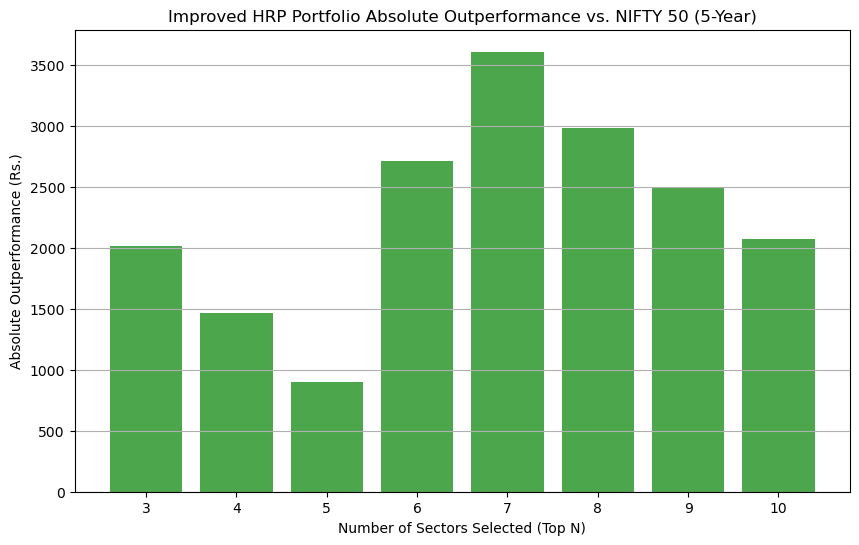


--- Investment Advice as of 2025-02-10 ---

Using training data from 2024-06-02 to 2025-02-09:



C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.32074968937422366' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 3 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT']
Recommended HRP Weights:
  ^CNXFMCG: 45.33%
  ^CNXAUTO: 22.59%
  ^CNXIT: 32.07%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7117195742121107' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 4 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL']
Recommended HRP Weights:
  ^CNXFMCG: 47.68%
  ^CNXAUTO: 17.95%
  ^CNXIT: 23.49%
  ^CNXMETAL: 10.88%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6282012517048978' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 5 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE']
Recommended HRP Weights:
  ^CNXFMCG: 42.08%
  ^CNXAUTO: 15.38%
  ^CNXIT: 20.74%
  ^CNXMETAL: 5.71%
  ^CNXSERVICE: 16.10%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.39449053136438716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 6 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK']
Recommended HRP Weights:
  ^CNXFMCG: 32.46%
  ^CNXAUTO: 7.79%
  ^CNXIT: 15.99%
  ^CNXMETAL: 12.10%
  ^CNXSERVICE: 21.57%
  ^NSEBANK: 10.09%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4110227051115537' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 7 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA']
Recommended HRP Weights:
  ^CNXFMCG: 29.03%
  ^CNXAUTO: 15.94%
  ^CNXIT: 14.30%
  ^CNXMETAL: 6.05%
  ^CNXSERVICE: 14.31%
  ^NSEBANK: 10.85%
  ^CNXINFRA: 9.51%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.37561029550955816' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 8 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC']
Recommended HRP Weights:
  ^CNXFMCG: 25.48%
  ^CNXAUTO: 8.98%
  ^CNXIT: 12.55%
  ^CNXMETAL: 5.44%
  ^CNXSERVICE: 13.16%
  ^NSEBANK: 9.98%
  ^CNXINFRA: 8.41%
  ^CNXMNC: 16.00%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3896272582391469' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 9 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK']
Recommended HRP Weights:
  ^CNXFMCG: 17.58%
  ^CNXAUTO: 8.66%
  ^CNXIT: 8.66%
  ^CNXMETAL: 5.91%
  ^CNXSERVICE: 14.96%
  ^NSEBANK: 11.22%
  ^CNXINFRA: 9.30%
  ^CNXMNC: 19.59%
  ^CNXPSUBANK: 4.12%
------------------------------------------------------------
--- Top 10 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK', '^CNXPSE']
Recommended HRP Weights:
  ^CNXFMCG: 23.53%
  ^CNXAUTO: 8.34%
  ^CNXIT: 11.60%
  ^CNXMETAL: 2.73%
  ^CNXSERVICE: 12.79%
  ^NSEBANK: 5.84%
  ^CNXINFRA: 9.14%
  ^CNXMNC: 15.12%
  ^CNXPSUBANK: 4.51%
  ^CNXPSE: 6.40%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\882911055.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.44819854532499603' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# =============================================================================
# 1. Data Download and Setup
# =============================================================================

# Define sector tickers (NSE sector indices)
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame of prices (only keep dates when all data is available)
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# Download NIFTY benchmark data for market timing & benchmark analysis
# =============================================================================
benchmark_ticker = "^NSEI"
nifty_data = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False)
if not nifty_data.empty:
    nifty_prices = nifty_data['Adj Close']
else:
    nifty_prices = pd.Series()

# =============================================================================
# 2. Functions for Feature Calculation and Prediction
# =============================================================================
def compute_features(prices_series, end_date, window=63):
    """
    Compute features from a price series over the last 'window' days ending at end_date.
      - Momentum: cumulative return over window.
      - Volatility: std. dev. of daily returns over window.
      - Sharpe: (mean return / volatility).
    """
    df = pd.DataFrame(prices_series)
    df.columns = ['price']
    df = df.sort_index().dropna()
    period_data = df.loc[end_date - timedelta(days=window):end_date, 'price']
    if len(period_data) < window / 2:
        return None  # not enough data
    momentum = period_data.iloc[-1] / period_data.iloc[0] - 1
    returns_window = period_data.pct_change().dropna()
    volatility = returns_window.std()
    sharpe = returns_window.mean() / volatility if volatility > 0 else 0
    return np.array([momentum, volatility, sharpe])

def predict_sector_return_rf(prices_series, training_start, training_end, horizon=63):
    """
    Train a RandomForest regressor on sliding-window samples (weekly) over the training period.
    For each sample, features (momentum, volatility, sharpe) are computed over the previous 63 days,
    and the target is the cumulative return over the next 'horizon' days.
    Returns a predicted return for the sector for the upcoming period.
    """
    df = pd.DataFrame(prices_series)
    df.columns = ['price']
    df = df.sort_index().dropna()
    
    X, y = [], []
    window = 63
    sample_dates = pd.date_range(start=training_start, end=training_end - timedelta(days=horizon), freq='7D')
    for date in sample_dates:
        start_feat = date - timedelta(days=window)
        end_feat = date
        if start_feat < df.index[0] or end_feat > df.index[-1]:
            continue
        feat = compute_features(prices_series, end_feat, window)
        if feat is None:
            continue
        X.append(feat)
        # Target: cumulative return from date to date+horizon
        start_target = date
        end_target = date + timedelta(days=horizon)
        if end_target > df.index[-1]:
            continue
        target_data = df.loc[start_target:end_target, 'price']
        target_return = target_data.iloc[-1] / target_data.iloc[0] - 1
        y.append(target_return)
    
    if len(X) < 5:
        # Not enough samples; fallback to momentum computed over last window.
        feat = compute_features(prices_series, training_end, window)
        return feat[0] if feat is not None else 0
    X = np.array(X)
    y = np.array(y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_scaled, y)
    # Compute features for prediction using the last 'window' days ending at training_end
    feat_pred = compute_features(prices_series, training_end, window)
    if feat_pred is None:
        return 0
    feat_pred_scaled = scaler.transform([feat_pred])
    pred_return = rf.predict(feat_pred_scaled)[0]
    return pred_return

def compute_all_composite_scores(prices, sectors, training_end, training_start):
    """
    For each sector compute:
      - Momentum, Sharpe (from last 63 days)
      - Predicted return (via RandomForest)
    Then rank each metric across sectors (higher is better) and sum the ranks.
    Returns a dictionary {sector: composite_score}.
    """
    momentum_dict = {}
    sharpe_dict = {}
    pred_return_dict = {}
    for sec in sectors:
        feat = compute_features(prices[sec], training_end, window=63)
        if feat is None:
            momentum_dict[sec] = 0
            sharpe_dict[sec] = 0
        else:
            momentum_dict[sec] = feat[0]
            sharpe_dict[sec] = feat[2]  # using Sharpe ratio
        pred_return_dict[sec] = predict_sector_return_rf(prices[sec], training_start, training_end, horizon=63)
    
    momentum_rank = pd.Series(momentum_dict).rank(ascending=True)
    sharpe_rank = pd.Series(sharpe_dict).rank(ascending=True)
    pred_return_rank = pd.Series(pred_return_dict).rank(ascending=True)
    
    composite = momentum_rank + sharpe_rank + pred_return_rank
    return composite.to_dict()

# =============================================================================
# 3. Improved HRP Weight Calculation using Recursive Bisection
# =============================================================================
def get_cluster_variance(cov, cluster):
    sub_cov = cov.loc[cluster, cluster]
    inv_diag = 1 / np.diag(sub_cov)
    w = inv_diag / inv_diag.sum()
    return np.dot(w, np.dot(sub_cov, w))

def recursive_bisection(cov, sorted_indices):
    weights = pd.Series(1, index=sorted_indices)
    clusters = [list(sorted_indices)]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            continue
        split = int(len(cluster) / 2)
        left = cluster[:split]
        right = cluster[split:]
        var_left = get_cluster_variance(cov, left)
        var_right = get_cluster_variance(cov, right)
        alpha = 1 - var_left / (var_left + var_right)
        for s in left:
            weights[s] *= alpha
        for s in right:
            weights[s] *= (1 - alpha)
        clusters.append(left)
        clusters.append(right)
    return weights / weights.sum()

def get_hrp_weights(returns_df):
    """
    Compute HRP weights using hierarchical clustering and recursive bisection.
    """
    cov = returns_df.cov()
    corr = returns_df.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    link = sch.linkage(ssd.squareform(dist), method='ward')
    sorted_ix = sch.leaves_list(link)
    sorted_tickers = returns_df.columns[sorted_ix]
    weights = recursive_bisection(cov, sorted_tickers)
    return weights

# =============================================================================
# 4. Market Timing Functions (Trend & Volatility Filters)
# =============================================================================
def market_condition(nifty_prices, current_date, window_ma=200, window_vol=63, vol_threshold=0.02):
    """
    Checks market conditions using NIFTY data:
      - Trend Filter: current price must be above the 200-day MA.
      - Volatility Filter: recent volatility (over window_vol) must be below vol_threshold.
    Returns True if conditions are favorable; otherwise, False.
    """
    nifty_series = pd.Series(nifty_prices).sort_index().dropna()
    if current_date not in nifty_series.index:
        current_date = nifty_series.index.asof(current_date)
    if current_date is None:
        return False
    # Compute 200-day MA (using last 200 available observations up to current_date)
    if nifty_series.index.get_loc(current_date) < window_ma:
        ma200 = nifty_series.iloc[:window_ma].mean()
    else:
        ma200 = nifty_series.loc[:current_date].tail(window_ma).mean()
    current_price = nifty_series.loc[current_date]
    trend_ok = current_price >= ma200
    vol_data = nifty_series.loc[:current_date].tail(window_vol).pct_change().dropna()
    current_vol = vol_data.std()
    vol_ok = current_vol < vol_threshold
    return trend_ok and vol_ok

# =============================================================================
# 5. Improved HRP Portfolio Rebalancing Simulation (Quarterly)
# =============================================================================
print("\n--- Improved HRP-Weighted Quarterly Rebalancing Simulation ---\n")

quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 10000
results_summary = []       # Summary for each top-n setting
all_quarterly_results = {} # Detailed quarterly results for each top-n
transaction_cost = 0.001   # 0.1% cost per rebalancing trade

# Loop for different top-n sector selections (n = 3,4,...,10)
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # List to store each quarter’s return
    quarterly_results = []  # Detailed results per quarter
    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    for i, q_end in enumerate(quarter_end_dates):
        # Determine quarter start date
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break
        
        # Check market timing using NIFTY
        if not nifty_prices.empty:
            market_ok = market_condition(nifty_prices, q_start)
        else:
            market_ok = True  # assume favorable if no data
        
        if not market_ok:
            # If market conditions are unfavorable, stay in cash for this quarter.
            portfolio_return = 0
            cumulative_value = cumulative_value * (1 + portfolio_return)
            quarterly_returns.append(portfolio_return)
            quarterly_results.append({
                'quarter_start': q_start,
                'quarter_end': q_end,
                'selected_sectors': [],
                'hrp_weights': {},
                'portfolio_return': portfolio_return,
                'cumulative_value': cumulative_value,
                'market_condition': 'Bearish/High Volatility - Stayed in Cash'
            })
            print(f"Quarter {q_start.date()} to {q_end.date()}: Market conditions not favorable. Stayed in cash.")
            continue
        
        # Define training period (last 252 days before q_start)
        training_end = q_start - pd.Timedelta(days=1)
        training_start = training_end - pd.Timedelta(days=252)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Enhanced Sector Selection using composite score (Sharpe + momentum + predicted return)
        candidate_sectors = training_returns.columns.tolist()
        composite_scores = compute_all_composite_scores(prices, candidate_sectors, training_end, training_start)
        # Select top n sectors based on composite score (higher is better)
        selected_sectors = sorted(composite_scores, key=composite_scores.get, reverse=True)[:n]
        
        # Compute HRP weights using improved HRP on training returns for selected sectors
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        # Get price data for the current quarter for the selected sectors
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Compute portfolio return using HRP weights
        portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        # Apply transaction cost at rebalancing (subtract 0.1%)
        portfolio_return_adjusted = portfolio_return - transaction_cost
        cumulative_value *= (1 + portfolio_return_adjusted)
        quarterly_returns.append(portfolio_return_adjusted)
        
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'portfolio_return': portfolio_return_adjusted,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value,
            'market_condition': 'Favorable'
        })
        
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {hrp_weights[sector]:.2%}")
        print("  Sector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"    {sector}: {ret:.2%}")
        print(f"  Portfolio Return (after transaction costs): {portfolio_return_adjusted:.2%}")
        print(f"  Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("-" * 80)
    
    # Annualized volatility based on quarterly returns
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan

    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for Improved HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df[['Number of Sectors', 'HRP Portfolio Value', 'Annualized Volatility']])

# =============================================================================
# 6. NIFTY Benchmark Analysis (Over 1-10 Years)
# =============================================================================
time_periods = {f"{i} Years": end_date - timedelta(days=365 * i) for i in range(1, 11)}
initial_capital_bench = 10000
benchmark_results = []
earliest_start = min(time_periods.values())
benchmark_data = yf.download(benchmark_ticker, start=earliest_start, end=end_date, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded. Check the ticker or network connection.")
benchmark_data = benchmark_data['Adj Close']

for period, start_dt in time_periods.items():
    filtered_data = benchmark_data[benchmark_data.index >= pd.Timestamp(start_dt)]
    if filtered_data.empty:
        continue
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    total_return = (end_price / start_price) - 1
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    final_value = initial_capital_bench * (1 + total_return)
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return (%)': total_return * 100,
        'CAGR (%)': cagr * 100,
        'Final Portfolio Value': final_value
    })

benchmark_results_df = pd.DataFrame(benchmark_results)
print("\n=== NIFTY 50 Benchmark Performance over Different Time Periods ===")
print(benchmark_results_df)

# =============================================================================
# 7. Comparison Analysis: Improved HRP Portfolio vs. NIFTY Benchmark (5-Year)
# =============================================================================
bench_5yr = benchmark_results_df[benchmark_results_df["Time Period"] == "5 Years"]
if bench_5yr.empty:
    raise ValueError("5-Year benchmark data not available.")
nifty_5yr_final = bench_5yr.iloc[0]['Final Portfolio Value']
comparison_df = hrp_results_df.copy()
comparison_df['NIFTY 5-Year Value'] = nifty_5yr_final
comparison_df['Absolute Outperformance'] = comparison_df['HRP Portfolio Value'] - nifty_5yr_final
comparison_df['Percentage Outperformance (%)'] = (comparison_df['Absolute Outperformance'] / nifty_5yr_final) * 100

print("\n=== Comparison: Improved HRP Portfolio vs. NIFTY 50 (5-Year) ===")
print(comparison_df[['Number of Sectors', 'HRP Portfolio Value', 'NIFTY 5-Year Value', 
                     'Absolute Outperformance', 'Percentage Outperformance (%)']])

# =============================================================================
# 8. (Optional) Plotting the Outperformance vs. Number of Sectors
# =============================================================================
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Number of Sectors'], comparison_df['Absolute Outperformance'], color='green', alpha=0.7)
plt.xlabel("Number of Sectors Selected (Top N)")
plt.ylabel("Absolute Outperformance (Rs.)")
plt.title("Improved HRP Portfolio Absolute Outperformance vs. NIFTY 50 (5-Year)")
plt.grid(axis='y')
plt.show()

# =============================================================================
# 9. Investment Advice for Today (Using Last 1 Year Data)
# =============================================================================
advice_date = datetime(2025, 2, 10)
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]
advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---\n")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")
for n in range(3, 11):
    candidate_sectors = advice_training_returns.columns.tolist()
    composite_scores = compute_all_composite_scores(prices, candidate_sectors, advice_training_end, advice_training_start)
    top_n_sectors = sorted(composite_scores, key=composite_scores.get, reverse=True)[:n]
    selected_training_returns = advice_training_returns[top_n_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended HRP Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {hrp_weights[sector]:.2%}")
    print("-" * 60)


--- Improved HRP-Weighted Quarterly Rebalancing Simulation ---


===== Simulating for Top 3 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5246588955016234' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA']
  HRP Weights:
    ^CNXIT: 52.47%
    ^CNXAUTO: 23.78%
    ^CNXMEDIA: 23.75%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
  Portfolio Return (after transaction costs): 15.23%
  Cumulative Value: Rs. 11,523.11
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.48226894170965595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXREALTY: 28.79%
    ^CNXMETAL: 48.23%
    ^NSEBANK: 22.98%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
  Portfolio Return (after transaction costs): 10.74%
  Cumulative Value: Rs. 12,760.29
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3629508714770787' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 24.92%
    ^CNXPSUBANK: 36.30%
    ^CNXPSE: 38.79%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
  Portfolio Return (after transaction costs): 16.53%
  Cumulative Value: Rs. 14,869.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5263495546909496' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 15.61%
    ^CNXPSE: 31.75%
    ^CNXIT: 52.63%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
  Portfolio Return (after transaction costs): 14.93%
  Cumulative Value: Rs. 17,089.06
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.462677861368306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 46.27%
    ^CNXENERGY: 28.31%
    ^CNXSERVICE: 25.42%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
  Portfolio Return (after transaction costs): 4.65%
  Cumulative Value: Rs. 17,883.06
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2588651043381026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 26.12%
    ^CNXMEDIA: 25.89%
    ^CNXMNC: 48.00%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
  Portfolio Return (after transaction costs): -3.59%
  Cumulative Value: Rs. 17,241.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5768910890977272' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT']
  HRP Weights:
    ^CNXMEDIA: 21.50%
    ^CNXMETAL: 20.81%
    ^CNXIT: 57.69%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
  Portfolio Return (after transaction costs): -24.07%
  Cumulative Value: Rs. 13,090.66
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.726970270433063' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 13.02%
    ^CNXFMCG: 72.70%
    ^CNXMETAL: 14.28%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
  Portfolio Return (after transaction costs): 10.21%
  Cumulative Value: Rs. 14,427.73
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6013623356387107' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE']
  HRP Weights:
    ^CNXPSUBANK: 16.31%
    ^NSEBANK: 23.55%
    ^CNXPSE: 60.14%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
  Portfolio Return (after transaction costs): -3.27%
  Cumulative Value: Rs. 13,955.41
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30500729543562555' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC']
  HRP Weights:
    ^CNXAUTO: 30.50%
    ^CNXFMCG: 33.51%
    ^CNXMNC: 35.99%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
  Portfolio Return (after transaction costs): 1.66%
  Cumulative Value: Rs. 14,186.47
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.38358194110939414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 19.01%
    ^CNXPSE: 42.63%
    ^CNXMEDIA: 38.36%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
  Portfolio Return (after transaction costs): 16.35%
  Cumulative Value: Rs. 16,505.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30546884762952753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA']
  HRP Weights:
    ^CNXPSE: 30.39%
    ^CNXREALTY: 30.55%
    ^CNXINFRA: 39.07%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
  Portfolio Return (after transaction costs): 14.94%
  Cumulative Value: Rs. 18,972.33
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.259425852717288' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC']
  HRP Weights:
    ^CNXAUTO: 23.68%
    ^CNXREALTY: 25.94%
    ^CNXMNC: 50.38%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
  Portfolio Return (after transaction costs): 16.87%
  Cumulative Value: Rs. 22,173.31
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2544819347230295' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY']
  HRP Weights:
    ^CNXMNC: 50.50%
    ^CNXAUTO: 24.05%
    ^CNXREALTY: 25.45%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
  Portfolio Return (after transaction costs): 4.62%
  Cumulative Value: Rs. 23,198.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.36690365784185675' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT']
  HRP Weights:
    ^CNXMETAL: 13.76%
    ^CNXMNC: 49.55%
    ^CNXIT: 36.69%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
  Portfolio Return (after transaction costs): -8.74%
  Cumulative Value: Rs. 21,170.98
--------------------------------------------------------------------------------

===== Simulating for Top 4 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5782392747933929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL']
  HRP Weights:
    ^CNXIT: 32.31%
    ^CNXAUTO: 22.24%
    ^CNXMEDIA: 25.51%
    ^CNXMETAL: 19.93%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
  Portfolio Return (after transaction costs): 19.66%
  Cumulative Value: Rs. 11,966.49
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47687214805469247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXREALTY: 26.74%
    ^CNXMETAL: 25.57%
    ^NSEBANK: 18.87%
    ^CNXSERVICE: 28.81%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
  Portfolio Return (after transaction costs): 7.80%
  Cumulative Value: Rs. 12,899.50
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45137850448355976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY']
  HRP Weights:
    ^CNXMETAL: 21.46%
    ^CNXPSUBANK: 19.15%
    ^CNXPSE: 33.40%
    ^CNXREALTY: 25.99%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
  Portfolio Return (after transaction costs): 13.19%
  Cumulative Value: Rs. 14,600.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5019220348229461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 16.60%
    ^CNXPSE: 24.49%
    ^CNXIT: 33.59%
    ^CNXENERGY: 25.32%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
  Portfolio Return (after transaction costs): 14.01%
  Cumulative Value: Rs. 16,646.48
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4501021555708373' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 21.88%
    ^CNXENERGY: 23.13%
    ^CNXSERVICE: 18.77%
    ^CNXMNC: 36.22%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
  Portfolio Return (after transaction costs): 2.14%
  Cumulative Value: Rs. 17,001.92
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7027479862652573' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 24.76%
    ^CNXMEDIA: 15.16%
    ^CNXMNC: 45.51%
    ^CNXREALTY: 14.56%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
  Portfolio Return (after transaction costs): -4.72%
  Cumulative Value: Rs. 16,199.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5300011880762292' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY']
  HRP Weights:
    ^CNXMEDIA: 19.66%
    ^CNXMETAL: 16.32%
    ^CNXIT: 33.34%
    ^CNXENERGY: 30.68%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
  Portfolio Return (after transaction costs): -18.28%
  Cumulative Value: Rs. 13,237.91
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6974196092816117' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXPSUBANK: 12.83%
    ^CNXFMCG: 53.00%
    ^CNXMETAL: 16.74%
    ^NSEBANK: 17.43%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
  Portfolio Return (after transaction costs): 12.57%
  Cumulative Value: Rs. 14,902.51
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5675853996295026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 17.69%
    ^NSEBANK: 25.55%
    ^CNXPSE: 37.32%
    ^CNXMETAL: 19.44%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
  Portfolio Return (after transaction costs): -7.75%
  Cumulative Value: Rs. 13,747.76
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.37169151825096625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE']
  HRP Weights:
    ^CNXAUTO: 16.75%
    ^CNXFMCG: 30.29%
    ^CNXMNC: 32.54%
    ^CNXPSE: 20.42%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
  Portfolio Return (after transaction costs): 4.22%
  Cumulative Value: Rs. 14,328.01
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5242049189748854' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 14.68%
    ^CNXPSE: 32.90%
    ^CNXMEDIA: 20.50%
    ^CNXIT: 31.92%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
  Portfolio Return (after transaction costs): 16.03%
  Cumulative Value: Rs. 16,624.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.40513994180621404' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXPSE: 26.03%
    ^CNXREALTY: 15.80%
    ^CNXINFRA: 33.46%
    ^CNXAUTO: 24.71%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
  Portfolio Return (after transaction costs): 15.31%
  Cumulative Value: Rs. 19,170.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28610035432085146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK']
  HRP Weights:
    ^CNXAUTO: 22.83%
    ^CNXREALTY: 15.64%
    ^CNXMNC: 48.56%
    ^CNXPSUBANK: 12.97%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
  Portfolio Return (after transaction costs): 15.08%
  Cumulative Value: Rs. 22,060.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6515228087160352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE']
  HRP Weights:
    ^CNXMNC: 44.14%
    ^CNXAUTO: 21.02%
    ^CNXREALTY: 13.68%
    ^CNXPSE: 21.17%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
  Portfolio Return (after transaction costs): 5.14%
  Cumulative Value: Rs. 23,193.68
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3786081711685164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO']
  HRP Weights:
    ^CNXMETAL: 14.01%
    ^CNXMNC: 42.17%
    ^CNXIT: 23.85%
    ^CNXAUTO: 19.97%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
  Portfolio Return (after transaction costs): -11.10%
  Cumulative Value: Rs. 20,619.98
--------------------------------------------------------------------------------

===== Simulating for Top 5 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5581720659719387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 31.19%
    ^CNXAUTO: 11.90%
    ^CNXMEDIA: 24.63%
    ^CNXMETAL: 10.67%
    ^CNXREALTY: 21.61%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
  Portfolio Return (after transaction costs): 23.57%
  Cumulative Value: Rs. 12,357.25
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5215327891787707' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT']
  HRP Weights:
    ^CNXREALTY: 11.83%
    ^CNXMETAL: 11.31%
    ^NSEBANK: 19.10%
    ^CNXSERVICE: 24.70%
    ^CNXIT: 33.05%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
  Portfolio Return (after transaction costs): 5.55%
  Cumulative Value: Rs. 13,043.22
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47977230803267923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY']
  HRP Weights:
    ^CNXMETAL: 18.77%
    ^CNXPSUBANK: 9.36%
    ^CNXPSE: 29.21%
    ^CNXREALTY: 12.70%
    ^CNXENERGY: 29.97%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
  Portfolio Return (after transaction costs): 12.38%
  Cumulative Value: Rs. 14,657.70
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5178422250789898' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 17.13%
    ^CNXPSE: 15.12%
    ^CNXIT: 34.66%
    ^CNXENERGY: 15.63%
    ^CNXMETAL: 17.46%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
  Portfolio Return (after transaction costs): 12.75%
  Cumulative Value: Rs. 16,526.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45949687234835945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXIT: 22.33%
    ^CNXENERGY: 23.62%
    ^CNXSERVICE: 10.37%
    ^CNXMNC: 20.01%
    ^CNXINFRA: 23.67%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
  Portfolio Return (after transaction costs): 1.77%
  Cumulative Value: Rs. 16,819.47
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4493643286970378' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL']
  HRP Weights:
    ^CNXIT: 28.17%
    ^CNXMEDIA: 16.77%
    ^CNXMNC: 30.36%
    ^CNXREALTY: 15.21%
    ^CNXMETAL: 9.50%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
  Portfolio Return (after transaction costs): -2.59%
  Cumulative Value: Rs. 16,384.12
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5148740730899065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE']
  HRP Weights:
    ^CNXMEDIA: 19.10%
    ^CNXMETAL: 16.48%
    ^CNXIT: 32.39%
    ^CNXENERGY: 16.45%
    ^CNXPSE: 15.58%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
  Portfolio Return (after transaction costs): -18.74%
  Cumulative Value: Rs. 13,314.30
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7200069110932532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 6.60%
    ^CNXFMCG: 34.97%
    ^CNXMETAL: 12.42%
    ^NSEBANK: 8.97%
    ^CNXMNC: 37.03%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
  Portfolio Return (after transaction costs): 8.00%
  Cumulative Value: Rs. 14,379.71
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5073583413441631' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXPSUBANK: 17.08%
    ^NSEBANK: 20.21%
    ^CNXPSE: 21.16%
    ^CNXMETAL: 11.02%
    ^CNXSERVICE: 30.53%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
  Portfolio Return (after transaction costs): -8.12%
  Cumulative Value: Rs. 13,212.41
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6440733383704256' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY']
  HRP Weights:
    ^CNXAUTO: 9.66%
    ^CNXFMCG: 31.05%
    ^CNXMNC: 33.35%
    ^CNXPSE: 19.62%
    ^CNXREALTY: 6.31%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
  Portfolio Return (after transaction costs): 4.19%
  Cumulative Value: Rs. 13,766.20
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47808257880805405' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 16.25%
    ^CNXPSE: 27.96%
    ^CNXMEDIA: 9.64%
    ^CNXIT: 31.56%
    ^CNXAUTO: 14.59%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
  Portfolio Return (after transaction costs): 16.44%
  Cumulative Value: Rs. 16,029.08
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5399058859466619' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY']
  HRP Weights:
    ^CNXPSE: 23.62%
    ^CNXREALTY: 8.24%
    ^CNXINFRA: 30.37%
    ^CNXAUTO: 12.88%
    ^CNXENERGY: 24.89%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
  Portfolio Return (after transaction costs): 15.25%
  Cumulative Value: Rs. 18,473.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28643194541290806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA']
  HRP Weights:
    ^CNXAUTO: 24.09%
    ^CNXREALTY: 15.66%
    ^CNXMNC: 27.99%
    ^CNXPSUBANK: 12.98%
    ^CNXINFRA: 19.28%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
  Portfolio Return (after transaction costs): 13.59%
  Cumulative Value: Rs. 20,983.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6371854667763277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT']
  HRP Weights:
    ^CNXMNC: 43.12%
    ^CNXAUTO: 18.64%
    ^CNXREALTY: 6.92%
    ^CNXPSE: 10.71%
    ^CNXIT: 20.60%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
  Portfolio Return (after transaction costs): 7.22%
  Cumulative Value: Rs. 22,499.18
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3401155641461775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG']
  HRP Weights:
    ^CNXMETAL: 12.58%
    ^CNXMNC: 21.23%
    ^CNXIT: 21.43%
    ^CNXAUTO: 10.05%
    ^CNXFMCG: 34.70%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
  Portfolio Return (after transaction costs): -10.88%
  Cumulative Value: Rs. 20,050.51
--------------------------------------------------------------------------------

===== Simulating for Top 6 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4917303135609167' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC']
  HRP Weights:
    ^CNXIT: 25.48%
    ^CNXAUTO: 11.11%
    ^CNXMEDIA: 11.88%
    ^CNXMETAL: 17.99%
    ^CNXREALTY: 11.81%
    ^CNXMNC: 21.73%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
  Portfolio Return (after transaction costs): 23.03%
  Cumulative Value: Rs. 12,303.08
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5241020921836927' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK']
  HRP Weights:
    ^CNXREALTY: 11.77%
    ^CNXMETAL: 11.25%
    ^NSEBANK: 10.25%
    ^CNXSERVICE: 24.57%
    ^CNXIT: 31.21%
    ^CNXPSUBANK: 10.95%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
  Portfolio Return (after transaction costs): 6.85%
  Cumulative Value: Rs. 13,145.71
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49505761996577946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA']
  HRP Weights:
    ^CNXMETAL: 18.67%
    ^CNXPSUBANK: 8.35%
    ^CNXPSE: 15.35%
    ^CNXREALTY: 11.33%
    ^CNXENERGY: 15.49%
    ^CNXINFRA: 30.82%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
  Portfolio Return (after transaction costs): 10.59%
  Cumulative Value: Rs. 14,538.22
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6066701107424457' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 8.06%
    ^CNXPSE: 12.34%
    ^CNXIT: 23.84%
    ^CNXENERGY: 12.75%
    ^CNXMETAL: 14.24%
    ^CNXMNC: 28.77%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
  Portfolio Return (after transaction costs): 12.37%
  Cumulative Value: Rs. 16,337.29
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43497570996554025' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXIT: 21.82%
    ^CNXENERGY: 10.90%
    ^CNXSERVICE: 11.84%
    ^CNXMNC: 22.84%
    ^CNXINFRA: 12.77%
    ^CNXPSE: 19.82%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
  Portfolio Return (after transaction costs): 0.76%
  Cumulative Value: Rs. 16,461.59
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4332790633476039' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 17.85%
    ^CNXMEDIA: 15.28%
    ^CNXMNC: 27.19%
    ^CNXREALTY: 10.20%
    ^CNXMETAL: 14.87%
    ^CNXSERVICE: 14.61%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
  Portfolio Return (after transaction costs): -1.07%
  Cumulative Value: Rs. 16,285.23
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.46683246662786804' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA']
  HRP Weights:
    ^CNXMEDIA: 10.04%
    ^CNXMETAL: 9.72%
    ^CNXIT: 26.93%
    ^CNXENERGY: 13.44%
    ^CNXPSE: 24.27%
    ^CNXINFRA: 15.60%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
  Portfolio Return (after transaction costs): -15.73%
  Cumulative Value: Rs. 13,723.31
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2870240765982087' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 11.41%
    ^CNXFMCG: 36.15%
    ^CNXMETAL: 7.73%
    ^NSEBANK: 9.57%
    ^CNXMNC: 20.79%
    ^CNXINFRA: 14.35%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
  Portfolio Return (after transaction costs): 10.14%
  Cumulative Value: Rs. 15,114.48
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3690830483141059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 12.80%
    ^NSEBANK: 8.60%
    ^CNXPSE: 15.85%
    ^CNXMETAL: 8.26%
    ^CNXSERVICE: 13.00%
    ^CNXFMCG: 41.49%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
  Portfolio Return (after transaction costs): -3.36%
  Cumulative Value: Rs. 14,606.80
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5154339627003035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA']
  HRP Weights:
    ^CNXAUTO: 16.18%
    ^CNXFMCG: 32.70%
    ^CNXMNC: 19.07%
    ^CNXPSE: 12.27%
    ^CNXREALTY: 6.57%
    ^CNXINFRA: 13.21%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
  Portfolio Return (after transaction costs): 4.31%
  Cumulative Value: Rs. 15,236.30
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4470332295365541' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 8.49%
    ^CNXPSE: 14.57%
    ^CNXMEDIA: 10.59%
    ^CNXIT: 25.63%
    ^CNXAUTO: 22.33%
    ^CNXINFRA: 18.39%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
  Portfolio Return (after transaction costs): 15.43%
  Cumulative Value: Rs. 17,587.78
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5119027290400188' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXPSE: 15.81%
    ^CNXREALTY: 8.74%
    ^CNXINFRA: 20.33%
    ^CNXAUTO: 13.67%
    ^CNXENERGY: 26.40%
    ^CNXMETAL: 15.05%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
  Portfolio Return (after transaction costs): 13.50%
  Cumulative Value: Rs. 19,962.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.35924124251624656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXAUTO: 21.63%
    ^CNXREALTY: 8.85%
    ^CNXMNC: 25.14%
    ^CNXPSUBANK: 11.81%
    ^CNXINFRA: 17.31%
    ^CNXPSE: 15.27%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
  Portfolio Return (after transaction costs): 13.57%
  Cumulative Value: Rs. 22,671.60
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43476274387197666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL']
  HRP Weights:
    ^CNXMNC: 28.55%
    ^CNXAUTO: 13.59%
    ^CNXREALTY: 14.38%
    ^CNXPSE: 12.45%
    ^CNXIT: 23.25%
    ^CNXMETAL: 7.78%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
  Portfolio Return (after transaction costs): 6.66%
  Cumulative Value: Rs. 24,181.95
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5189059094415059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE']
  HRP Weights:
    ^CNXMETAL: 7.73%
    ^CNXMNC: 19.13%
    ^CNXIT: 18.22%
    ^CNXAUTO: 9.06%
    ^CNXFMCG: 25.94%
    ^CNXSERVICE: 19.92%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
  Portfolio Return (after transaction costs): -9.56%
  Cumulative Value: Rs. 21,869.00
--------------------------------------------------------------------------------

===== Simulating for Top 7 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.48485669208010984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK']
  HRP Weights:
    ^CNXIT: 25.98%
    ^CNXAUTO: 10.96%
    ^CNXMEDIA: 11.86%
    ^CNXMETAL: 10.64%
    ^CNXREALTY: 10.97%
    ^CNXMNC: 21.44%
    ^NSEBANK: 8.14%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
  Portfolio Return (after transaction costs): 22.77%
  Cumulative Value: Rs. 12,276.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3612021687960352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXREALTY: 11.22%
    ^CNXMETAL: 10.72%
    ^NSEBANK: 7.86%
    ^CNXSERVICE: 12.00%
    ^CNXIT: 16.20%
    ^CNXPSUBANK: 16.26%
    ^CNXFMCG: 25.73%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
  Portfolio Return (after transaction costs): 6.83%
  Cumulative Value: Rs. 13,115.87
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49236262719700896' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE']
  HRP Weights:
    ^CNXMETAL: 18.57%
    ^CNXPSUBANK: 8.36%
    ^CNXPSE: 15.26%
    ^CNXREALTY: 10.43%
    ^CNXENERGY: 15.40%
    ^CNXINFRA: 18.91%
    ^CNXSERVICE: 13.06%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
  Portfolio Return (after transaction costs): 10.66%
  Cumulative Value: Rs. 14,513.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5855845876988486' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 7.78%
    ^CNXPSE: 11.22%
    ^CNXIT: 23.01%
    ^CNXENERGY: 10.81%
    ^CNXMETAL: 6.85%
    ^CNXMNC: 27.77%
    ^CNXINFRA: 12.56%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
  Portfolio Return (after transaction costs): 13.10%
  Cumulative Value: Rs. 16,415.09
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4039766445962679' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG']
  HRP Weights:
    ^CNXIT: 11.32%
    ^CNXENERGY: 10.13%
    ^CNXSERVICE: 10.75%
    ^CNXMNC: 19.31%
    ^CNXINFRA: 11.86%
    ^CNXPSE: 18.41%
    ^CNXFMCG: 18.22%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
  Portfolio Return (after transaction costs): -1.59%
  Cumulative Value: Rs. 16,154.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43488170200708676' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA']
  HRP Weights:
    ^CNXIT: 17.91%
    ^CNXMEDIA: 15.34%
    ^CNXMNC: 21.60%
    ^CNXREALTY: 10.24%
    ^CNXMETAL: 7.46%
    ^CNXSERVICE: 12.81%
    ^CNXINFRA: 14.65%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
  Portfolio Return (after transaction costs): -1.69%
  Cumulative Value: Rs. 15,881.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5966918940311849' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG']
  HRP Weights:
    ^CNXMEDIA: 9.42%
    ^CNXMETAL: 6.16%
    ^CNXIT: 22.50%
    ^CNXENERGY: 10.74%
    ^CNXPSE: 10.97%
    ^CNXINFRA: 12.46%
    ^CNXFMCG: 27.75%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
  Portfolio Return (after transaction costs): -11.15%
  Cumulative Value: Rs. 14,109.57
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.695514650089168' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 6.32%
    ^CNXFMCG: 35.27%
    ^CNXMETAL: 7.47%
    ^NSEBANK: 8.59%
    ^CNXMNC: 20.28%
    ^CNXINFRA: 14.00%
    ^CNXMEDIA: 8.08%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
  Portfolio Return (after transaction costs): 7.27%
  Cumulative Value: Rs. 15,135.69
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5936009545960247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA']
  HRP Weights:
    ^CNXPSUBANK: 6.08%
    ^NSEBANK: 7.29%
    ^CNXPSE: 13.34%
    ^CNXMETAL: 6.95%
    ^CNXSERVICE: 11.02%
    ^CNXFMCG: 39.06%
    ^CNXINFRA: 16.24%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
  Portfolio Return (after transaction costs): -2.63%
  Cumulative Value: Rs. 14,737.32
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.34213734758477576' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL']
  HRP Weights:
    ^CNXAUTO: 10.73%
    ^CNXFMCG: 21.63%
    ^CNXMNC: 19.75%
    ^CNXPSE: 20.89%
    ^CNXREALTY: 6.89%
    ^CNXINFRA: 13.68%
    ^CNXMETAL: 6.44%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
  Portfolio Return (after transaction costs): 6.29%
  Cumulative Value: Rs. 15,664.66
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4882234717463868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL']
  HRP Weights:
    ^CNXPSUBANK: 7.78%
    ^CNXPSE: 14.90%
    ^CNXMEDIA: 9.70%
    ^CNXIT: 24.77%
    ^CNXAUTO: 14.96%
    ^CNXINFRA: 18.80%
    ^CNXMETAL: 9.09%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
  Portfolio Return (after transaction costs): 15.79%
  Cumulative Value: Rs. 18,138.10
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5235971855809038' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK']
  HRP Weights:
    ^CNXPSE: 16.17%
    ^CNXREALTY: 8.91%
    ^CNXINFRA: 20.79%
    ^CNXAUTO: 13.93%
    ^CNXENERGY: 17.12%
    ^CNXMETAL: 15.40%
    ^CNXPSUBANK: 7.67%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
  Portfolio Return (after transaction costs): 13.94%
  Cumulative Value: Rs. 20,667.33
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5550755327779752' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY']
  HRP Weights:
    ^CNXAUTO: 13.14%
    ^CNXREALTY: 14.40%
    ^CNXMNC: 27.96%
    ^CNXPSUBANK: 6.01%
    ^CNXINFRA: 14.70%
    ^CNXPSE: 12.51%
    ^CNXENERGY: 11.28%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
  Portfolio Return (after transaction costs): 13.31%
  Cumulative Value: Rs. 23,417.46
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43205873293477637' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE']
  HRP Weights:
    ^CNXMNC: 23.51%
    ^CNXAUTO: 11.19%
    ^CNXREALTY: 7.26%
    ^CNXPSE: 12.38%
    ^CNXIT: 23.10%
    ^CNXMETAL: 7.73%
    ^CNXSERVICE: 14.83%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
  Portfolio Return (after transaction costs): 7.31%
  Cumulative Value: Rs. 25,129.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6552373682322091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK']
  HRP Weights:
    ^CNXMETAL: 6.04%
    ^CNXMNC: 23.52%
    ^CNXIT: 20.08%
    ^CNXAUTO: 10.30%
    ^CNXFMCG: 21.92%
    ^CNXSERVICE: 10.86%
    ^NSEBANK: 7.28%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
  Portfolio Return (after transaction costs): -9.41%
  Cumulative Value: Rs. 22,764.92
--------------------------------------------------------------------------------

===== Simulating for Top 8 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4233226925248953' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXIT: 14.71%
    ^CNXAUTO: 11.00%
    ^CNXMEDIA: 11.32%
    ^CNXMETAL: 10.42%
    ^CNXREALTY: 10.77%
    ^CNXMNC: 21.53%
    ^NSEBANK: 7.99%
    ^CNXSERVICE: 12.25%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
  Portfolio Return (after transaction costs): 24.07%
  Cumulative Value: Rs. 12,407.46
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.586401974107958' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA']
  HRP Weights:
    ^CNXREALTY: 9.25%
    ^CNXMETAL: 10.21%
    ^NSEBANK: 6.57%
    ^CNXSERVICE: 10.04%
    ^CNXIT: 15.19%
    ^CNXPSUBANK: 9.10%
    ^CNXFMCG: 24.13%
    ^CNXINFRA: 15.50%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
  Portfolio Return (after transaction costs): 6.71%
  Cumulative Value: Rs. 13,239.89
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5261813005509028' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT']
  HRP Weights:
    ^CNXMETAL: 10.18%
    ^CNXPSUBANK: 7.80%
    ^CNXPSE: 13.55%
    ^CNXREALTY: 9.74%
    ^CNXENERGY: 13.67%
    ^CNXINFRA: 17.65%
    ^CNXSERVICE: 12.19%
    ^CNXIT: 15.22%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
  Portfolio Return (after transaction costs): 9.91%
  Cumulative Value: Rs. 14,551.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5657889038400412' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 8.02%
    ^CNXPSE: 11.75%
    ^CNXIT: 16.22%
    ^CNXENERGY: 11.33%
    ^CNXMETAL: 7.18%
    ^CNXMNC: 22.15%
    ^CNXINFRA: 13.16%
    ^CNXAUTO: 10.20%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
  Portfolio Return (after transaction costs): 11.33%
  Cumulative Value: Rs. 16,199.67
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5996634576429802' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY']
  HRP Weights:
    ^CNXIT: 11.39%
    ^CNXENERGY: 10.08%
    ^CNXSERVICE: 10.81%
    ^CNXMNC: 19.43%
    ^CNXINFRA: 11.81%
    ^CNXPSE: 11.30%
    ^CNXFMCG: 18.34%
    ^CNXREALTY: 6.84%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
  Portfolio Return (after transaction costs): -1.41%
  Cumulative Value: Rs. 15,971.76
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.41005628418287365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE']
  HRP Weights:
    ^CNXIT: 15.30%
    ^CNXMEDIA: 8.63%
    ^CNXMNC: 20.60%
    ^CNXREALTY: 8.28%
    ^CNXMETAL: 8.79%
    ^CNXSERVICE: 12.17%
    ^CNXINFRA: 13.97%
    ^CNXPSE: 12.26%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
  Portfolio Return (after transaction costs): -0.89%
  Cumulative Value: Rs. 15,829.09
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5854777334428231' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE']
  HRP Weights:
    ^CNXMEDIA: 7.98%
    ^CNXMETAL: 6.33%
    ^CNXIT: 13.49%
    ^CNXENERGY: 11.04%
    ^CNXPSE: 11.27%
    ^CNXINFRA: 12.81%
    ^CNXFMCG: 23.45%
    ^CNXSERVICE: 13.63%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
  Portfolio Return (after transaction costs): -10.82%
  Cumulative Value: Rs. 14,117.05
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6424345269537897' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE']
  HRP Weights:
    ^CNXPSUBANK: 6.58%
    ^CNXFMCG: 19.89%
    ^CNXMETAL: 6.53%
    ^NSEBANK: 9.06%
    ^CNXMNC: 21.06%
    ^CNXINFRA: 16.71%
    ^CNXMEDIA: 7.92%
    ^CNXPSE: 12.25%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
  Portfolio Return (after transaction costs): 8.38%
  Cumulative Value: Rs. 15,300.57
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.341496000014056' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC']
  HRP Weights:
    ^CNXPSUBANK: 5.92%
    ^NSEBANK: 8.66%
    ^CNXPSE: 12.81%
    ^CNXMETAL: 6.76%
    ^CNXSERVICE: 12.43%
    ^CNXFMCG: 20.66%
    ^CNXINFRA: 13.40%
    ^CNXMNC: 19.37%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
  Portfolio Return (after transaction costs): -3.94%
  Cumulative Value: Rs. 14,697.24
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4063635856787705' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY']
  HRP Weights:
    ^CNXAUTO: 10.90%
    ^CNXFMCG: 19.94%
    ^CNXMNC: 21.41%
    ^CNXPSE: 11.50%
    ^CNXREALTY: 7.12%
    ^CNXINFRA: 13.00%
    ^CNXMETAL: 5.76%
    ^CNXENERGY: 10.38%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
  Portfolio Return (after transaction costs): 5.61%
  Cumulative Value: Rs. 15,521.20
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5010408528919635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY']
  HRP Weights:
    ^CNXPSUBANK: 7.59%
    ^CNXPSE: 14.86%
    ^CNXMEDIA: 10.59%
    ^CNXIT: 16.50%
    ^CNXAUTO: 13.95%
    ^CNXINFRA: 18.76%
    ^CNXMETAL: 8.69%
    ^CNXREALTY: 9.06%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
  Portfolio Return (after transaction costs): 17.78%
  Cumulative Value: Rs. 18,280.79
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5301901357458403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXPSE: 14.61%
    ^CNXREALTY: 9.37%
    ^CNXINFRA: 17.24%
    ^CNXAUTO: 13.41%
    ^CNXENERGY: 13.52%
    ^CNXMETAL: 7.65%
    ^CNXPSUBANK: 7.66%
    ^CNXSERVICE: 16.54%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
  Portfolio Return (after transaction costs): 12.57%
  Cumulative Value: Rs. 20,578.11
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5458954511342351' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL']
  HRP Weights:
    ^CNXAUTO: 11.78%
    ^CNXREALTY: 7.35%
    ^CNXMNC: 28.52%
    ^CNXPSUBANK: 6.94%
    ^CNXINFRA: 15.07%
    ^CNXPSE: 12.07%
    ^CNXENERGY: 11.56%
    ^CNXMETAL: 6.72%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
  Portfolio Return (after transaction costs): 12.91%
  Cumulative Value: Rs. 23,235.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45667843881965886' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA']
  HRP Weights:
    ^CNXMNC: 22.49%
    ^CNXAUTO: 10.71%
    ^CNXREALTY: 6.95%
    ^CNXPSE: 10.00%
    ^CNXIT: 13.36%
    ^CNXMETAL: 7.77%
    ^CNXSERVICE: 14.19%
    ^CNXINFRA: 14.54%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
  Portfolio Return (after transaction costs): 6.41%
  Cumulative Value: Rs. 24,724.76
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.351144433119007' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA']
  HRP Weights:
    ^CNXMETAL: 6.15%
    ^CNXMNC: 19.17%
    ^CNXIT: 11.21%
    ^CNXAUTO: 10.49%
    ^CNXFMCG: 22.09%
    ^CNXSERVICE: 11.06%
    ^NSEBANK: 7.41%
    ^CNXINFRA: 12.42%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
  Portfolio Return (after transaction costs): -10.46%
  Cumulative Value: Rs. 22,138.45
--------------------------------------------------------------------------------

===== Simulating for Top 9 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5739599568920655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXIT: 14.64%
    ^CNXAUTO: 10.95%
    ^CNXMEDIA: 6.43%
    ^CNXMETAL: 10.37%
    ^CNXREALTY: 10.86%
    ^CNXMNC: 21.43%
    ^NSEBANK: 8.07%
    ^CNXSERVICE: 11.74%
    ^CNXPSUBANK: 5.51%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
    ^CNXPSUBANK: 35.63%
  Portfolio Return (after transaction costs): 25.72%
  Cumulative Value: Rs. 12,571.58
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5848890825910151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO']
  HRP Weights:
    ^CNXREALTY: 8.67%
    ^CNXMETAL: 10.19%
    ^NSEBANK: 3.57%
    ^CNXSERVICE: 5.46%
    ^CNXIT: 15.16%
    ^CNXPSUBANK: 9.08%
    ^CNXFMCG: 24.07%
    ^CNXINFRA: 14.20%
    ^CNXAUTO: 9.61%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
    ^CNXAUTO: 4.72%
  Portfolio Return (after transaction costs): 6.62%
  Cumulative Value: Rs. 13,403.36
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4096798910857544' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT', '^NSEBANK']
  HRP Weights:
    ^CNXMETAL: 10.99%
    ^CNXPSUBANK: 8.67%
    ^CNXPSE: 14.85%
    ^CNXREALTY: 11.76%
    ^CNXENERGY: 7.79%
    ^CNXINFRA: 8.98%
    ^CNXSERVICE: 12.43%
    ^CNXIT: 16.43%
    ^NSEBANK: 8.10%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
    ^NSEBANK: 2.70%
  Portfolio Return (after transaction costs): 10.03%
  Cumulative Value: Rs. 14,747.30
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4491389318208563' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 8.12%
    ^CNXPSE: 12.64%
    ^CNXIT: 16.43%
    ^CNXENERGY: 11.72%
    ^CNXMETAL: 7.72%
    ^CNXMNC: 13.60%
    ^CNXINFRA: 13.62%
    ^CNXAUTO: 6.26%
    ^CNXMEDIA: 9.87%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
    ^CNXMEDIA: 19.14%
  Portfolio Return (after transaction costs): 12.75%
  Cumulative Value: Rs. 16,628.19
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6271115947280026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY', '^NSEBANK']
  HRP Weights:
    ^CNXIT: 10.83%
    ^CNXENERGY: 10.05%
    ^CNXSERVICE: 5.39%
    ^CNXMNC: 19.84%
    ^CNXINFRA: 11.77%
    ^CNXPSE: 11.77%
    ^CNXFMCG: 20.27%
    ^CNXREALTY: 6.64%
    ^NSEBANK: 3.43%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
    ^NSEBANK: -4.69%
  Portfolio Return (after transaction costs): -1.78%
  Cumulative Value: Rs. 16,331.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4334096406858948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXIT: 16.81%
    ^CNXMEDIA: 9.30%
    ^CNXMNC: 13.50%
    ^CNXREALTY: 9.61%
    ^CNXMETAL: 7.54%
    ^CNXSERVICE: 13.41%
    ^CNXINFRA: 9.16%
    ^CNXPSE: 13.05%
    ^CNXPSUBANK: 7.63%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
    ^CNXPSUBANK: 5.45%
  Portfolio Return (after transaction costs): -0.34%
  Cumulative Value: Rs. 16,276.83
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5738231519398338' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXMEDIA: 4.04%
    ^CNXMETAL: 7.34%
    ^CNXIT: 13.54%
    ^CNXENERGY: 11.23%
    ^CNXPSE: 10.63%
    ^CNXINFRA: 13.37%
    ^CNXFMCG: 23.54%
    ^CNXSERVICE: 12.95%
    ^CNXPSUBANK: 3.34%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
    ^CNXPSUBANK: -14.10%
  Portfolio Return (after transaction costs): -10.64%
  Cumulative Value: Rs. 14,544.91
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6123566401596772' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 3.47%
    ^CNXFMCG: 20.31%
    ^CNXMETAL: 6.75%
    ^NSEBANK: 4.71%
    ^CNXMNC: 21.50%
    ^CNXINFRA: 12.88%
    ^CNXMEDIA: 7.06%
    ^CNXPSE: 12.67%
    ^CNXENERGY: 10.63%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
    ^CNXENERGY: 2.69%
  Portfolio Return (after transaction costs): 6.46%
  Cumulative Value: Rs. 15,485.15
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.34394997356354273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC', '^CNXIT']
  HRP Weights:
    ^CNXPSUBANK: 5.96%
    ^NSEBANK: 8.72%
    ^CNXPSE: 12.90%
    ^CNXMETAL: 6.81%
    ^CNXSERVICE: 13.16%
    ^CNXFMCG: 20.64%
    ^CNXINFRA: 8.25%
    ^CNXMNC: 11.92%
    ^CNXIT: 11.63%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
    ^CNXIT: -0.13%
  Portfolio Return (after transaction costs): -3.62%
  Cumulative Value: Rs. 14,925.20
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4119658498995843' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY', '^CNXSERVICE']
  HRP Weights:
    ^CNXAUTO: 6.02%
    ^CNXFMCG: 18.56%
    ^CNXMNC: 19.93%
    ^CNXPSE: 11.66%
    ^CNXREALTY: 6.90%
    ^CNXINFRA: 13.17%
    ^CNXMETAL: 5.84%
    ^CNXENERGY: 10.52%
    ^CNXSERVICE: 7.39%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
    ^CNXSERVICE: 0.50%
  Portfolio Return (after transaction costs): 5.35%
  Cumulative Value: Rs. 15,724.17
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3484598459096755' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 6.52%
    ^CNXPSE: 14.43%
    ^CNXMEDIA: 8.09%
    ^CNXIT: 8.47%
    ^CNXAUTO: 12.24%
    ^CNXINFRA: 18.51%
    ^CNXMETAL: 7.38%
    ^CNXREALTY: 7.99%
    ^CNXFMCG: 16.36%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
    ^CNXFMCG: 11.04%
  Portfolio Return (after transaction costs): 17.39%
  Cumulative Value: Rs. 18,457.97
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5296059438746017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSE: 14.60%
    ^CNXREALTY: 8.54%
    ^CNXINFRA: 17.22%
    ^CNXAUTO: 13.36%
    ^CNXENERGY: 13.50%
    ^CNXMETAL: 7.64%
    ^CNXPSUBANK: 4.25%
    ^CNXSERVICE: 15.59%
    ^CNXMEDIA: 5.30%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
    ^CNXMEDIA: -26.47%
  Portfolio Return (after transaction costs): 10.25%
  Cumulative Value: Rs. 20,350.17
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.464221550090929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL', '^NSEBANK']
  HRP Weights:
    ^CNXAUTO: 8.47%
    ^CNXREALTY: 9.28%
    ^CNXMNC: 18.02%
    ^CNXPSUBANK: 6.83%
    ^CNXINFRA: 15.40%
    ^CNXPSE: 12.34%
    ^CNXENERGY: 11.82%
    ^CNXMETAL: 6.87%
    ^NSEBANK: 10.96%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
    ^NSEBANK: 10.01%
  Portfolio Return (after transaction costs): 12.15%
  Cumulative Value: Rs. 22,823.61
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4408384256615211' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^NSEBANK']
  HRP Weights:
    ^CNXMNC: 15.80%
    ^CNXAUTO: 7.52%
    ^CNXREALTY: 7.96%
    ^CNXPSE: 10.04%
    ^CNXIT: 11.86%
    ^CNXMETAL: 7.32%
    ^CNXSERVICE: 14.58%
    ^CNXINFRA: 14.60%
    ^NSEBANK: 10.32%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
    ^NSEBANK: 0.77%
  Portfolio Return (after transaction costs): 5.67%
  Cumulative Value: Rs. 24,117.50
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3431107286871866' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXREALTY']
  HRP Weights:
    ^CNXMETAL: 6.77%
    ^CNXMNC: 20.59%
    ^CNXIT: 7.09%
    ^CNXAUTO: 9.75%
    ^CNXFMCG: 13.98%
    ^CNXSERVICE: 12.29%
    ^NSEBANK: 8.24%
    ^CNXINFRA: 14.28%
    ^CNXREALTY: 7.02%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
    ^CNXREALTY: -4.06%
  Portfolio Return (after transaction costs): -10.25%
  Cumulative Value: Rs. 21,644.94
--------------------------------------------------------------------------------

===== Simulating for Top 10 Sectors =====

Quarter 2020-02-14 to 2020-03-31: Market conditions not favorable. Stayed in cash.
Quarter 2020-04-01 to 2020-06-30: Market conditions not favorable. Stayed in cash.
Quarter 2020-07-01 to 2020-09-30: Ma

C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6059752249078885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXMEDIA', '^CNXMETAL', '^CNXREALTY', '^CNXMNC', '^NSEBANK', '^CNXSERVICE', '^CNXPSUBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXIT: 12.60%
    ^CNXAUTO: 5.23%
    ^CNXMEDIA: 5.94%
    ^CNXMETAL: 4.69%
    ^CNXREALTY: 10.05%
    ^CNXMNC: 19.50%
    ^NSEBANK: 7.46%
    ^CNXSERVICE: 10.85%
    ^CNXPSUBANK: 5.10%
    ^CNXFMCG: 18.58%
  Sector Returns:
    ^CNXIT: 20.59%
    ^CNXAUTO: 15.41%
    ^CNXMEDIA: 3.64%
    ^CNXMETAL: 43.93%
    ^CNXREALTY: 45.50%
    ^CNXMNC: 11.34%
    ^NSEBANK: 40.54%
    ^CNXSERVICE: 31.66%
    ^CNXPSUBANK: 35.63%
    ^CNXFMCG: 13.89%
  Portfolio Return (after transaction costs): 23.22%
  Cumulative Value: Rs. 12,321.64
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5854484274788512' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-01-01 to 2021-03-31:
  Selected Sectors: ['^CNXREALTY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXPSE']
  HRP Weights:
    ^CNXREALTY: 9.14%
    ^CNXMETAL: 4.74%
    ^NSEBANK: 3.77%
    ^CNXSERVICE: 5.75%
    ^CNXIT: 13.65%
    ^CNXPSUBANK: 8.24%
    ^CNXFMCG: 21.68%
    ^CNXINFRA: 8.31%
    ^CNXAUTO: 10.16%
    ^CNXPSE: 14.56%
  Sector Returns:
    ^CNXREALTY: 5.26%
    ^CNXMETAL: 16.14%
    ^NSEBANK: 6.70%
    ^CNXSERVICE: 3.82%
    ^CNXIT: 2.97%
    ^CNXPSUBANK: 17.94%
    ^CNXFMCG: 0.90%
    ^CNXINFRA: 10.00%
    ^CNXAUTO: 4.72%
    ^CNXPSE: 7.74%
  Portfolio Return (after transaction costs): 6.13%
  Cumulative Value: Rs. 13,077.34
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.430144026647336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-04-01 to 2021-06-30:
  Selected Sectors: ['^CNXMETAL', '^CNXPSUBANK', '^CNXPSE', '^CNXREALTY', '^CNXENERGY', '^CNXINFRA', '^CNXSERVICE', '^CNXIT', '^NSEBANK', '^CNXMNC']
  HRP Weights:
    ^CNXMETAL: 8.66%
    ^CNXPSUBANK: 7.93%
    ^CNXPSE: 12.15%
    ^CNXREALTY: 10.76%
    ^CNXENERGY: 6.37%
    ^CNXINFRA: 7.34%
    ^CNXSERVICE: 11.45%
    ^CNXIT: 8.09%
    ^NSEBANK: 4.80%
    ^CNXMNC: 22.46%
  Sector Returns:
    ^CNXMETAL: 24.51%
    ^CNXPSUBANK: 13.73%
    ^CNXPSE: 14.28%
    ^CNXREALTY: 2.43%
    ^CNXENERGY: 7.05%
    ^CNXINFRA: 4.58%
    ^CNXSERVICE: 5.16%
    ^CNXIT: 12.27%
    ^NSEBANK: 2.70%
    ^CNXMNC: 7.58%
  Portfolio Return (after transaction costs): 9.31%
  Cumulative Value: Rs. 14,294.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5848209206621136' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXIT', '^CNXENERGY', '^CNXMETAL', '^CNXMNC', '^CNXINFRA', '^CNXAUTO', '^CNXMEDIA', '^CNXFMCG']
  HRP Weights:
    ^CNXPSUBANK: 3.51%
    ^CNXPSE: 10.14%
    ^CNXIT: 11.24%
    ^CNXENERGY: 10.48%
    ^CNXMETAL: 4.36%
    ^CNXMNC: 19.84%
    ^CNXINFRA: 12.00%
    ^CNXAUTO: 4.71%
    ^CNXMEDIA: 4.19%
    ^CNXFMCG: 19.52%
  Sector Returns:
    ^CNXPSUBANK: -1.55%
    ^CNXPSE: 13.65%
    ^CNXIT: 20.77%
    ^CNXENERGY: 15.98%
    ^CNXMETAL: 7.76%
    ^CNXMNC: 9.81%
    ^CNXINFRA: 16.13%
    ^CNXAUTO: -0.84%
    ^CNXMEDIA: 19.14%
    ^CNXFMCG: 11.57%
  Portfolio Return (after transaction costs): 12.48%
  Cumulative Value: Rs. 16,078.56
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6302122607806548' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXIT', '^CNXENERGY', '^CNXSERVICE', '^CNXMNC', '^CNXINFRA', '^CNXPSE', '^CNXFMCG', '^CNXREALTY', '^NSEBANK', '^CNXMEDIA']
  HRP Weights:
    ^CNXIT: 11.33%
    ^CNXENERGY: 6.15%
    ^CNXSERVICE: 9.56%
    ^CNXMNC: 20.75%
    ^CNXINFRA: 12.46%
    ^CNXPSE: 5.84%
    ^CNXFMCG: 18.96%
    ^CNXREALTY: 4.16%
    ^NSEBANK: 6.70%
    ^CNXMEDIA: 4.10%
  Sector Returns:
    ^CNXIT: 11.27%
    ^CNXENERGY: -1.60%
    ^CNXSERVICE: -0.06%
    ^CNXMNC: 0.42%
    ^CNXINFRA: -1.46%
    ^CNXPSE: -6.69%
    ^CNXFMCG: -6.98%
    ^CNXREALTY: -4.33%
    ^NSEBANK: -4.69%
    ^CNXMEDIA: 2.99%
  Portfolio Return (after transaction costs): -1.11%
  Cumulative Value: Rs. 15,900.59
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6194748514384543' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMEDIA', '^CNXMNC', '^CNXREALTY', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^CNXPSE', '^CNXPSUBANK', '^CNXAUTO']
  HRP Weights:
    ^CNXIT: 13.57%
    ^CNXMEDIA: 4.87%
    ^CNXMNC: 13.92%
    ^CNXREALTY: 4.67%
    ^CNXMETAL: 8.30%
    ^CNXSERVICE: 13.40%
    ^CNXINFRA: 9.44%
    ^CNXPSE: 13.17%
    ^CNXPSUBANK: 7.05%
    ^CNXAUTO: 11.61%
  Sector Returns:
    ^CNXIT: -7.17%
    ^CNXMEDIA: 5.70%
    ^CNXMNC: -6.44%
    ^CNXREALTY: -5.33%
    ^CNXMETAL: 14.14%
    ^CNXSERVICE: -2.53%
    ^CNXINFRA: 0.16%
    ^CNXPSE: 5.07%
    ^CNXPSUBANK: 5.45%
    ^CNXAUTO: -5.06%
  Portfolio Return (after transaction costs): -0.63%
  Cumulative Value: Rs. 15,800.91
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.589472053135444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXMEDIA', '^CNXMETAL', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXINFRA', '^CNXFMCG', '^CNXSERVICE', '^CNXPSUBANK', '^CNXREALTY']
  HRP Weights:
    ^CNXMEDIA: 4.70%
    ^CNXMETAL: 3.83%
    ^CNXIT: 13.27%
    ^CNXENERGY: 11.82%
    ^CNXPSE: 6.83%
    ^CNXINFRA: 13.73%
    ^CNXFMCG: 23.06%
    ^CNXSERVICE: 11.96%
    ^CNXPSUBANK: 6.35%
    ^CNXREALTY: 4.45%
  Sector Returns:
    ^CNXMEDIA: -21.61%
    ^CNXMETAL: -28.04%
    ^CNXIT: -23.39%
    ^CNXENERGY: -5.09%
    ^CNXPSE: -9.47%
    ^CNXINFRA: -9.34%
    ^CNXFMCG: 2.59%
    ^CNXSERVICE: -13.53%
    ^CNXPSUBANK: -14.10%
    ^CNXREALTY: -18.81%
  Portfolio Return (after transaction costs): -10.58%
  Cumulative Value: Rs. 14,129.67
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6211231015180603' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXMETAL', '^NSEBANK', '^CNXMNC', '^CNXINFRA', '^CNXMEDIA', '^CNXPSE', '^CNXENERGY', '^CNXAUTO']
  HRP Weights:
    ^CNXPSUBANK: 6.22%
    ^CNXFMCG: 19.10%
    ^CNXMETAL: 6.92%
    ^NSEBANK: 4.88%
    ^CNXMNC: 20.22%
    ^CNXINFRA: 8.77%
    ^CNXMEDIA: 7.50%
    ^CNXPSE: 7.11%
    ^CNXENERGY: 13.24%
    ^CNXAUTO: 6.05%
  Sector Returns:
    ^CNXPSUBANK: 48.15%
    ^CNXFMCG: 1.60%
    ^CNXMETAL: 20.19%
    ^NSEBANK: 13.03%
    ^CNXMNC: 1.85%
    ^CNXINFRA: 6.80%
    ^CNXMEDIA: -2.31%
    ^CNXPSE: 9.43%
    ^CNXENERGY: 2.69%
    ^CNXAUTO: 1.37%
  Portfolio Return (after transaction costs): 7.14%
  Cumulative Value: Rs. 15,138.53
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3495865639687976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^NSEBANK', '^CNXPSE', '^CNXMETAL', '^CNXSERVICE', '^CNXFMCG', '^CNXINFRA', '^CNXMNC', '^CNXIT', '^CNXMEDIA']
  HRP Weights:
    ^CNXPSUBANK: 6.41%
    ^NSEBANK: 4.91%
    ^CNXPSE: 11.88%
    ^CNXMETAL: 3.83%
    ^CNXSERVICE: 13.05%
    ^CNXFMCG: 20.46%
    ^CNXINFRA: 8.18%
    ^CNXMNC: 11.82%
    ^CNXIT: 11.53%
    ^CNXMEDIA: 7.92%
  Sector Returns:
    ^CNXPSUBANK: -14.55%
    ^NSEBANK: -6.01%
    ^CNXPSE: 1.02%
    ^CNXMETAL: -20.17%
    ^CNXSERVICE: -7.57%
    ^CNXFMCG: 3.87%
    ^CNXINFRA: -3.83%
    ^CNXMNC: -2.97%
    ^CNXIT: -0.13%
    ^CNXMEDIA: -15.64%
  Portfolio Return (after transaction costs): -4.09%
  Cumulative Value: Rs. 14,518.71
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30: Market conditions not favorable. Stayed in cash.


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6098247455650339' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXFMCG', '^CNXMNC', '^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXMETAL', '^CNXENERGY', '^CNXSERVICE', '^CNXPSUBANK']
  HRP Weights:
    ^CNXAUTO: 6.04%
    ^CNXFMCG: 18.58%
    ^CNXMNC: 19.96%
    ^CNXPSE: 7.14%
    ^CNXREALTY: 6.92%
    ^CNXINFRA: 8.78%
    ^CNXMETAL: 6.52%
    ^CNXENERGY: 12.86%
    ^CNXSERVICE: 7.40%
    ^CNXPSUBANK: 5.80%
  Sector Returns:
    ^CNXAUTO: 7.13%
    ^CNXFMCG: -2.16%
    ^CNXMNC: 0.84%
    ^CNXPSE: 17.17%
    ^CNXREALTY: 9.88%
    ^CNXINFRA: 7.92%
    ^CNXMETAL: 8.99%
    ^CNXENERGY: 9.20%
    ^CNXSERVICE: 0.50%
    ^CNXPSUBANK: 23.48%
  Portfolio Return (after transaction costs): 5.87%
  Cumulative Value: Rs. 15,370.84
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.614918691436722' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXPSE', '^CNXMEDIA', '^CNXIT', '^CNXAUTO', '^CNXINFRA', '^CNXMETAL', '^CNXREALTY', '^CNXFMCG', '^CNXENERGY']
  HRP Weights:
    ^CNXPSUBANK: 6.15%
    ^CNXPSE: 7.62%
    ^CNXMEDIA: 7.42%
    ^CNXIT: 12.68%
    ^CNXAUTO: 6.76%
    ^CNXINFRA: 9.62%
    ^CNXMETAL: 7.09%
    ^CNXREALTY: 4.39%
    ^CNXFMCG: 24.48%
    ^CNXENERGY: 13.78%
  Sector Returns:
    ^CNXPSUBANK: 6.13%
    ^CNXPSE: 32.03%
    ^CNXMEDIA: 4.25%
    ^CNXIT: 11.97%
    ^CNXAUTO: 16.43%
    ^CNXINFRA: 17.17%
    ^CNXMETAL: 17.36%
    ^CNXREALTY: 35.41%
    ^CNXFMCG: 11.04%
    ^CNXENERGY: 24.08%
  Portfolio Return (after transaction costs): 16.12%
  Cumulative Value: Rs. 17,848.94
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.537775489700915' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXREALTY', '^CNXINFRA', '^CNXAUTO', '^CNXENERGY', '^CNXMETAL', '^CNXPSUBANK', '^CNXSERVICE', '^CNXMEDIA', '^NSEBANK']
  HRP Weights:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 8.80%
    ^CNXINFRA: 17.29%
    ^CNXAUTO: 13.76%
    ^CNXENERGY: 8.71%
    ^CNXMETAL: 7.87%
    ^CNXPSUBANK: 7.75%
    ^CNXSERVICE: 9.54%
    ^CNXMEDIA: 4.86%
    ^NSEBANK: 6.37%
  Sector Returns:
    ^CNXPSE: 15.05%
    ^CNXREALTY: 15.70%
    ^CNXINFRA: 14.53%
    ^CNXAUTO: 16.79%
    ^CNXENERGY: 15.78%
    ^CNXMETAL: 2.91%
    ^CNXPSUBANK: 22.18%
    ^CNXSERVICE: 1.12%
    ^CNXMEDIA: -26.47%
    ^NSEBANK: -1.33%
  Portfolio Return (after transaction costs): 10.43%
  Cumulative Value: Rs. 19,710.04
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4474164426629035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXREALTY', '^CNXMNC', '^CNXPSUBANK', '^CNXINFRA', '^CNXPSE', '^CNXENERGY', '^CNXMETAL', '^NSEBANK', '^CNXSERVICE']
  HRP Weights:
    ^CNXAUTO: 11.13%
    ^CNXREALTY: 3.94%
    ^CNXMNC: 23.68%
    ^CNXPSUBANK: 6.61%
    ^CNXINFRA: 14.63%
    ^CNXPSE: 12.25%
    ^CNXENERGY: 7.10%
    ^CNXMETAL: 6.82%
    ^NSEBANK: 5.54%
    ^CNXSERVICE: 8.31%
  Sector Returns:
    ^CNXAUTO: 17.84%
    ^CNXREALTY: 17.54%
    ^CNXMNC: 16.27%
    ^CNXPSUBANK: 3.55%
    ^CNXINFRA: 8.44%
    ^CNXPSE: 14.99%
    ^CNXENERGY: 5.82%
    ^CNXMETAL: 14.62%
    ^NSEBANK: 10.01%
    ^CNXSERVICE: 8.47%
  Portfolio Return (after transaction costs): 12.40%
  Cumulative Value: Rs. 22,154.82
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.38933501807937454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXMNC', '^CNXAUTO', '^CNXREALTY', '^CNXPSE', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^CNXINFRA', '^NSEBANK', '^CNXFMCG']
  HRP Weights:
    ^CNXMNC: 15.14%
    ^CNXAUTO: 11.65%
    ^CNXREALTY: 7.03%
    ^CNXPSE: 5.59%
    ^CNXIT: 13.12%
    ^CNXMETAL: 6.37%
    ^CNXSERVICE: 11.30%
    ^CNXINFRA: 8.14%
    ^NSEBANK: 7.54%
    ^CNXFMCG: 14.13%
  Sector Returns:
    ^CNXMNC: 6.24%
    ^CNXAUTO: 6.73%
    ^CNXREALTY: -0.19%
    ^CNXPSE: 5.16%
    ^CNXIT: 13.77%
    ^CNXMETAL: 3.19%
    ^CNXSERVICE: 7.67%
    ^CNXINFRA: 4.85%
    ^NSEBANK: 0.77%
    ^CNXFMCG: 14.67%
  Portfolio Return (after transaction costs): 7.31%
  Cumulative Value: Rs. 23,773.62
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49411722900621946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXMETAL', '^CNXMNC', '^CNXIT', '^CNXAUTO', '^CNXFMCG', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXREALTY', '^CNXPSE']
  HRP Weights:
    ^CNXMETAL: 6.69%
    ^CNXMNC: 19.89%
    ^CNXIT: 10.16%
    ^CNXAUTO: 9.42%
    ^CNXFMCG: 14.54%
    ^CNXSERVICE: 6.66%
    ^NSEBANK: 4.46%
    ^CNXINFRA: 14.39%
    ^CNXREALTY: 6.93%
    ^CNXPSE: 6.87%
  Sector Returns:
    ^CNXMETAL: -15.39%
    ^CNXMNC: -14.74%
    ^CNXIT: 2.13%
    ^CNXAUTO: -15.69%
    ^CNXFMCG: -13.24%
    ^CNXSERVICE: -4.95%
    ^NSEBANK: -3.90%
    ^CNXINFRA: -11.43%
    ^CNXREALTY: -4.06%
    ^CNXPSE: -15.20%
  Portfolio Return (after transaction costs): -10.72%
  Cumulative Value: Rs. 21,224.97
--------------------------------------------------------------------------------

=== Simulation Summary for Improved HRP Portfolios (Top N Sectors) ===
   Number of Sectors  HRP Portfolio Value  Annualized Volatility
0                  3         21170.983641               0.

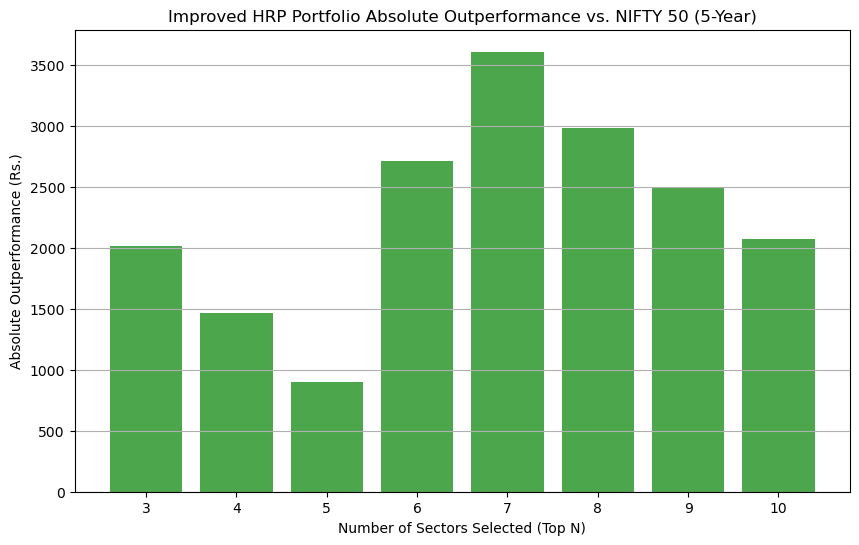


--- Investment Advice as of 2025-02-10 ---

Using training data from 2024-06-02 to 2025-02-09:



C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.32074968937422366' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 3 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT']
Recommended HRP Weights:
  ^CNXFMCG: 45.33%
  ^CNXAUTO: 22.59%
  ^CNXIT: 32.07%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7117195742121107' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 4 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL']
Recommended HRP Weights:
  ^CNXFMCG: 47.68%
  ^CNXAUTO: 17.95%
  ^CNXIT: 23.49%
  ^CNXMETAL: 10.88%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6282012517048978' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 5 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE']
Recommended HRP Weights:
  ^CNXFMCG: 42.08%
  ^CNXAUTO: 15.38%
  ^CNXIT: 20.74%
  ^CNXMETAL: 5.71%
  ^CNXSERVICE: 16.10%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.39449053136438716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 6 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK']
Recommended HRP Weights:
  ^CNXFMCG: 32.46%
  ^CNXAUTO: 7.79%
  ^CNXIT: 15.99%
  ^CNXMETAL: 12.10%
  ^CNXSERVICE: 21.57%
  ^NSEBANK: 10.09%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4110227051115537' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 7 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA']
Recommended HRP Weights:
  ^CNXFMCG: 29.03%
  ^CNXAUTO: 15.94%
  ^CNXIT: 14.30%
  ^CNXMETAL: 6.05%
  ^CNXSERVICE: 14.31%
  ^NSEBANK: 10.85%
  ^CNXINFRA: 9.51%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.37561029550955816' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 8 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC']
Recommended HRP Weights:
  ^CNXFMCG: 25.48%
  ^CNXAUTO: 8.98%
  ^CNXIT: 12.55%
  ^CNXMETAL: 5.44%
  ^CNXSERVICE: 13.16%
  ^NSEBANK: 9.98%
  ^CNXINFRA: 8.41%
  ^CNXMNC: 16.00%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3896272582391469' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


--- Top 9 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK']
Recommended HRP Weights:
  ^CNXFMCG: 17.58%
  ^CNXAUTO: 8.66%
  ^CNXIT: 8.66%
  ^CNXMETAL: 5.91%
  ^CNXSERVICE: 14.96%
  ^NSEBANK: 11.22%
  ^CNXINFRA: 9.30%
  ^CNXMNC: 19.59%
  ^CNXPSUBANK: 4.12%
------------------------------------------------------------
--- Top 10 Sectors Recommendation ---
Selected Sectors: ['^CNXFMCG', '^CNXAUTO', '^CNXIT', '^CNXMETAL', '^CNXSERVICE', '^NSEBANK', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK', '^CNXPSE']
Recommended HRP Weights:
  ^CNXFMCG: 23.53%
  ^CNXAUTO: 8.34%
  ^CNXIT: 11.60%
  ^CNXMETAL: 2.73%
  ^CNXSERVICE: 12.79%
  ^NSEBANK: 5.84%
  ^CNXINFRA: 9.14%
  ^CNXMNC: 15.12%
  ^CNXPSUBANK: 4.51%
  ^CNXPSE: 6.40%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_29084\333951064.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.44819854532499603' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[s] *= alpha


In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# =============================================================================
# 1. Data Download and Setup
# =============================================================================

# Define sector tickers (do not include CNXPHARMA)
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame of prices (only keep dates when all data is available)
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# Download NIFTY benchmark data for market timing & benchmark analysis
# =============================================================================
benchmark_ticker = "^NSEI"
nifty_data = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False)
if not nifty_data.empty:
    nifty_prices = nifty_data['Adj Close']
else:
    nifty_prices = pd.Series()

# =============================================================================
# 2. Functions for Feature Calculation and Prediction
# =============================================================================
def compute_features(prices_series, end_date, window=63):
    """
    Compute features from a price series over the last 'window' days ending at end_date.
    Features:
      - Momentum: cumulative return over window.
      - Volatility: standard deviation of daily returns over window.
      - Sharpe: (mean return / volatility).
    """
    df = pd.DataFrame(prices_series)
    df.columns = ['price']
    df = df.sort_index().dropna()
    period_data = df.loc[end_date - timedelta(days=window):end_date, 'price']
    if len(period_data) < window / 2:
        return None  # not enough data
    momentum = period_data.iloc[-1] / period_data.iloc[0] - 1
    returns_window = period_data.pct_change().dropna()
    volatility = returns_window.std()
    sharpe = returns_window.mean() / volatility if volatility > 0 else 0
    return np.array([momentum, volatility, sharpe])

def predict_sector_return_rf(prices_series, training_start, training_end, horizon=63):
    """
    Train a RandomForest regressor on sliding-window samples over the training period.
    Features (momentum, volatility, Sharpe) are computed over a 63-day window.
    The target is the cumulative return over the next 'horizon' days.
    Returns the predicted return for the upcoming period.
    """
    df = pd.DataFrame(prices_series)
    df.columns = ['price']
    df = df.sort_index().dropna()
    
    X, y = [], []
    window = 63
    sample_dates = pd.date_range(start=training_start, end=training_end - timedelta(days=horizon), freq='7D')
    for date in sample_dates:
        start_feat = date - timedelta(days=window)
        end_feat = date
        if start_feat < df.index[0] or end_feat > df.index[-1]:
            continue
        feat = compute_features(prices_series, end_feat, window)
        if feat is None:
            continue
        # Define target period
        start_target = date
        end_target = date + timedelta(days=horizon)
        if start_target < df.index[0] or end_target > df.index[-1]:
            continue
        target_data = df.loc[start_target:end_target, 'price']
        if target_data.empty:
            continue
        target_return = target_data.iloc[-1] / target_data.iloc[0] - 1
        X.append(feat)
        y.append(target_return)
    
    if len(X) < 5:
        feat = compute_features(prices_series, training_end, window)
        return feat[0] if feat is not None else 0
    
    # Ensure consistent sample size between X and y
    n_samples = min(len(X), len(y))
    X = np.array(X[:n_samples])
    y = np.array(y[:n_samples])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)
    # Use cross-validation to check model performance (this fixes the inconsistent samples error)
    scores = cross_val_score(rf, X_scaled, y, cv=tscv, scoring='r2')
    # Optionally, you can print the cross-validation scores:
    # print("RF Cross Validation Scores:", scores)
    rf.fit(X_scaled, y)
    feat_pred = compute_features(prices_series, training_end, window)
    if feat_pred is None:
        return 0
    pred_return = rf.predict(scaler.transform([feat_pred]))[0]
    return pred_return

def compute_all_composite_scores(prices, sectors, training_end, training_start):
    """
    For each sector, compute a composite score based on:
      - Momentum (from the last 63 days)
      - Sharpe ratio (from the last 63 days)
      - Predicted return (via RandomForest)
    Returns a dictionary {sector: composite_score} where higher scores are better.
    """
    momentum_dict = {}
    sharpe_dict = {}
    pred_return_dict = {}
    for sec in sectors:
        feat = compute_features(prices[sec], training_end, window=63)
        if feat is None:
            momentum_dict[sec] = 0
            sharpe_dict[sec] = 0
        else:
            momentum_dict[sec] = feat[0]
            sharpe_dict[sec] = feat[2]  # using Sharpe ratio
        pred_return_dict[sec] = predict_sector_return_rf(prices[sec], training_start, training_end, horizon=63)
    
    momentum_rank = pd.Series(momentum_dict).rank(ascending=True)
    sharpe_rank = pd.Series(sharpe_dict).rank(ascending=True)
    pred_return_rank = pd.Series(pred_return_dict).rank(ascending=True)
    
    composite = momentum_rank + sharpe_rank + pred_return_rank
    return composite.to_dict()

# =============================================================================
# 3. Improved HRP Weight Calculation using Recursive Bisection
# =============================================================================
def get_cluster_variance(cov, cluster):
    sub_cov = cov.loc[cluster, cluster]
    inv_diag = 1 / np.diag(sub_cov)
    w = inv_diag / inv_diag.sum()
    return np.dot(w, np.dot(sub_cov, w))

def recursive_bisection(cov, sorted_indices):
    weights = pd.Series(1, index=sorted_indices)
    clusters = [list(sorted_indices)]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            continue
        split = int(len(cluster) / 2)
        left = cluster[:split]
        right = cluster[split:]
        var_left = get_cluster_variance(cov, left)
        var_right = get_cluster_variance(cov, right)
        alpha = 1 - var_left / (var_left + var_right)
        for s in left:
            weights[s] *= alpha
        for s in right:
            weights[s] *= (1 - alpha)
        clusters.append(left)
        clusters.append(right)
    return weights / weights.sum()

def get_hrp_weights(returns_df):
    """
    Compute HRP weights using hierarchical clustering and recursive bisection.
    """
    cov = returns_df.cov()
    corr = returns_df.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    link = sch.linkage(ssd.squareform(dist), method='ward')
    sorted_ix = sch.leaves_list(link)
    sorted_tickers = returns_df.columns[sorted_ix]
    weights = recursive_bisection(cov, sorted_tickers)
    return weights

# =============================================================================
# 4. Market Timing Functions (Trend & Volatility Filters)
# =============================================================================
def market_condition(nifty_prices, current_date, window_ma=200, window_vol=63, vol_threshold=0.02):
    """
    Checks market conditions using NIFTY data:
      - Trend Filter: current price must be above the 200-day moving average.
      - Volatility Filter: recent volatility (over window_vol) must be below vol_threshold.
    Returns True if conditions are favorable; otherwise, False.
    """
    nifty_series = pd.Series(nifty_prices).sort_index().dropna()
    if current_date not in nifty_series.index:
        current_date = nifty_series.index.asof(current_date)
    if current_date is None:
        return False
    # Compute 200-day MA using the last 200 observations up to current_date
    if nifty_series.index.get_loc(current_date) < window_ma:
        ma200 = nifty_series.iloc[:window_ma].mean()
    else:
        ma200 = nifty_series.loc[:current_date].tail(window_ma).mean()
    current_price = nifty_series.loc[current_date]
    trend_ok = current_price >= ma200
    vol_data = nifty_series.loc[:current_date].tail(window_vol).pct_change().dropna()
    current_vol = vol_data.std()
    vol_ok = current_vol < vol_threshold
    return trend_ok and vol_ok

# =============================================================================
# 5. Improved HRP Portfolio Rebalancing Simulation (Quarterly)
# =============================================================================
print("\n--- Improved HRP-Weighted Quarterly Rebalancing Simulation ---\n")

quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 10000
results_summary = []       # Summary for each top-n setting
all_quarterly_results = {} # Detailed quarterly results for each top-n
transaction_cost = 0.001   # 0.1% cost per rebalancing trade

# Loop for different top-n sector selections (n = 3,4,...,10)
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # List to store each quarter’s return
    quarterly_results = []  # Detailed results per quarter
    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    for i, q_end in enumerate(quarter_end_dates):
        # Determine quarter start date
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break
        
        # Check market timing using NIFTY
        if not nifty_prices.empty:
            market_ok = market_condition(nifty_prices, q_start)
        else:
            market_ok = True  # Assume favorable if no data
        
        if not market_ok:
            # If market conditions are unfavorable, stay in cash for this quarter.
            portfolio_return = 0
            cumulative_value *= (1 + portfolio_return)
            quarterly_returns.append(portfolio_return)
            quarterly_results.append({
                'quarter_start': q_start,
                'quarter_end': q_end,
                'selected_sectors': [],
                'hrp_weights': {},
                'portfolio_return': portfolio_return,
                'cumulative_value': cumulative_value,
                'market_condition': 'Bearish/High Volatility - Stayed in Cash'
            })
            print(f"Quarter {q_start.date()} to {q_end.date()}: Market conditions not favorable. Stayed in cash.")
            continue
        
        # Define training period (last 252 days before q_start)
        training_end = q_start - pd.Timedelta(days=1)
        training_start = training_end - pd.Timedelta(days=252)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Enhanced Sector Selection using composite score (Sharpe + momentum + predicted return)
        candidate_sectors = training_returns.columns.tolist()
        composite_scores = compute_all_composite_scores(prices, candidate_sectors, training_end, training_start)
        # Select top n sectors based on composite score (higher is better)
        selected_sectors = sorted(composite_scores, key=composite_scores.get, reverse=True)[:n]
        
        # Compute HRP weights using improved HRP on training returns for selected sectors
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        # Get price data for the current quarter for the selected sectors
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Compute portfolio return using HRP weights
        portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        # Apply transaction cost at rebalancing (subtract 0.1%)
        portfolio_return_adjusted = portfolio_return - transaction_cost
        cumulative_value *= (1 + portfolio_return_adjusted)
        quarterly_returns.append(portfolio_return_adjusted)
        
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'portfolio_return': portfolio_return_adjusted,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value,
            'market_condition': 'Favorable'
        })
        
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {hrp_weights[sector]:.2%}")
        print("  Sector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"    {sector}: {ret:.2%}")
        print(f"  Portfolio Return (after transaction costs): {portfolio_return_adjusted:.2%}")
        print(f"  Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("-" * 80)
    
    # Annualized volatility based on quarterly returns
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan

    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for Improved HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df[['Number of Sectors', 'HRP Portfolio Value', 'Annualized Volatility']])

# =============================================================================
# 6. NIFTY Benchmark Analysis (Over 1-10 Years)
# =============================================================================
time_periods = {f"{i} Years": end_date - timedelta(days=365 * i) for i in range(1, 11)}
initial_capital_bench = 10000
benchmark_results = []
earliest_start = min(time_periods.values())
benchmark_data = yf.download(benchmark_ticker, start=earliest_start, end=end_date, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded. Check the ticker or network connection.")
benchmark_data = benchmark_data['Adj Close']

for period, start_dt in time_periods.items():
    filtered_data = benchmark_data[benchmark_data.index >= pd.Timestamp(start_dt)]
    if filtered_data.empty:
        continue
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    total_return = (end_price / start_price) - 1
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    final_value = initial_capital_bench * (1 + total_return)
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return (%)': total_return * 100,
        'CAGR (%)': cagr * 100,
        'Final Portfolio Value': final_value
    })

benchmark_results_df = pd.DataFrame(benchmark_results)
print("\n=== NIFTY 50 Benchmark Performance over Different Time Periods ===")
print(benchmark_results_df)

# =============================================================================
# 7. Comparison Analysis: Improved HRP Portfolio vs. NIFTY Benchmark (5-Year)
# =============================================================================
bench_5yr = benchmark_results_df[benchmark_results_df["Time Period"] == "5 Years"]
if bench_5yr.empty:
    raise ValueError("5-Year benchmark data not available.")
nifty_5yr_final = bench_5yr.iloc[0]['Final Portfolio Value']
comparison_df = hrp_results_df.copy()
comparison_df['NIFTY 5-Year Value'] = nifty_5yr_final
comparison_df['Absolute Outperformance'] = comparison_df['HRP Portfolio Value'] - nifty_5yr_final
comparison_df['Percentage Outperformance (%)'] = (comparison_df['Absolute Outperformance'] / nifty_5yr_final) * 100

print("\n=== Comparison: Improved HRP Portfolio vs. NIFTY 50 (5-Year) ===")
print(comparison_df[['Number of Sectors', 'HRP Portfolio Value', 'NIFTY 5-Year Value', 
                     'Absolute Outperformance', 'Percentage Outperformance (%)']])

# =============================================================================
# 8. (Optional) Plotting the Outperformance vs. Number of Sectors
# =============================================================================
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Number of Sectors'], comparison_df['Absolute Outperformance'], color='green', alpha=0.7)
plt.xlabel("Number of Sectors Selected (Top N)")
plt.ylabel("Absolute Outperformance (Rs.)")
plt.title("Improved HRP Portfolio Absolute Outperformance vs. NIFTY 50 (5-Year)")
plt.grid(axis='y')
plt.show()

# =============================================================================
# 9. Investment Advice for Today (Using Last 1 Year Data)
# =============================================================================
advice_date = datetime(2025, 2, 10)
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]
advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---\n")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")
for n in range(3, 11):
    candidate_sectors = advice_training_returns.columns.tolist()
    composite_scores = compute_all_composite_scores(prices, candidate_sectors, advice_training_end, advice_training_start)
    top_n_sectors = sorted(composite_scores, key=composite_scores.get, reverse=True)[:n]
    selected_training_returns = advice_training_returns[top_n_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended HRP Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {hrp_weights[sector]:.2%}")
    print("-" * 60)

In [4]:
#Makrowitz Portfolio


--- Mean–Variance Optimized Quarterly Rebalancing with Top N Sector Selection ---


===== Simulating for Top 3 Sectors =====

Quarter 2020-04-01 to 2020-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXIT', '^CNXMNC']
  Optimized Weights:
    ^CNXFMCG: 100.00%
    ^CNXIT: 0.00%
    ^CNXMNC: 0.00%
  Sector Returns:
    ^CNXFMCG: 14.05%
    ^CNXIT: 22.48%
    ^CNXMNC: 22.57%
  Portfolio Return: 14.05%
  Cumulative Value: Rs. 11,405.39
--------------------------------------------------------------------------------
Quarter 2020-07-01 to 2020-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXENERGY', '^CNXMNC']
  Optimized Weights:
    ^CNXFMCG: 33.33%
    ^CNXENERGY: 33.33%
    ^CNXMNC: 33.33%
  Sector Returns:
    ^CNXFMCG: -1.29%
    ^CNXENERGY: 3.82%
    ^CNXMNC: 6.58%
  Portfolio Return: 3.04%
  Cumulative Value: Rs. 11,751.65
--------------------------------------------------------------------------------
Quarter 2020-10-01 to 2020-12-31:
  Selected Sectors: ['^CNXIT', '^CNXAUTO', '^CNXENERG

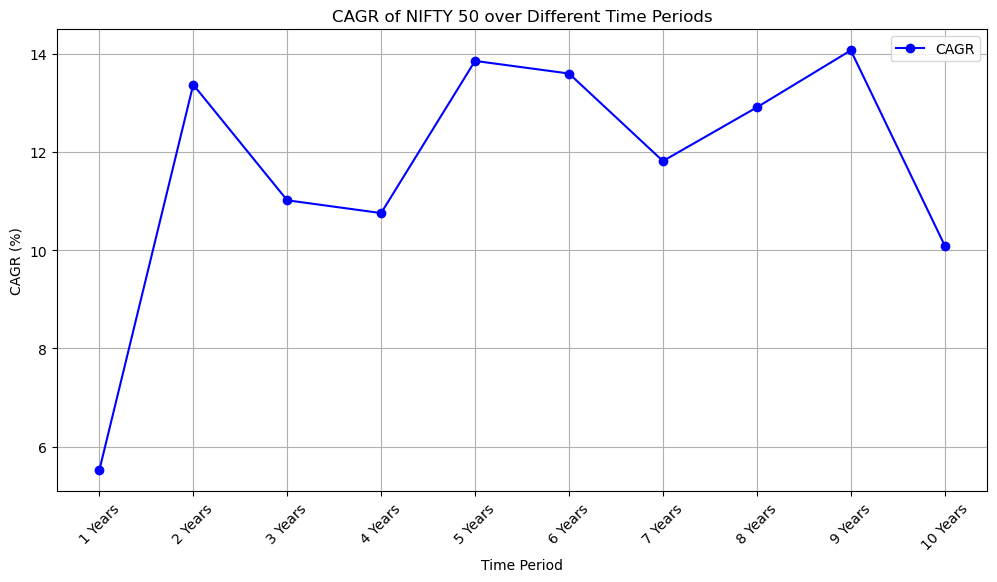


=== Comparison: Optimized Portfolio vs. NIFTY 50 (5-Year) ===
   Number of Sectors  Optimized Portfolio Value  NIFTY 5-Year Value  \
0                  3               28162.298163        19131.357298   
1                  4               28893.055707        19131.357298   
2                  5               28467.140175        19131.357298   
3                  6               25496.888545        19131.357298   
4                  7               26269.443171        19131.357298   
5                  8               26418.315806        19131.357298   
6                  9               27697.448551        19131.357298   
7                 10               28579.682500        19131.357298   

   Absolute Outperformance  Percentage Outperformance (%)  
0              9030.940866                      47.204915  
1              9761.698410                      51.024599  
2              9335.782878                      48.798330  
3              6365.531248                      33.272763

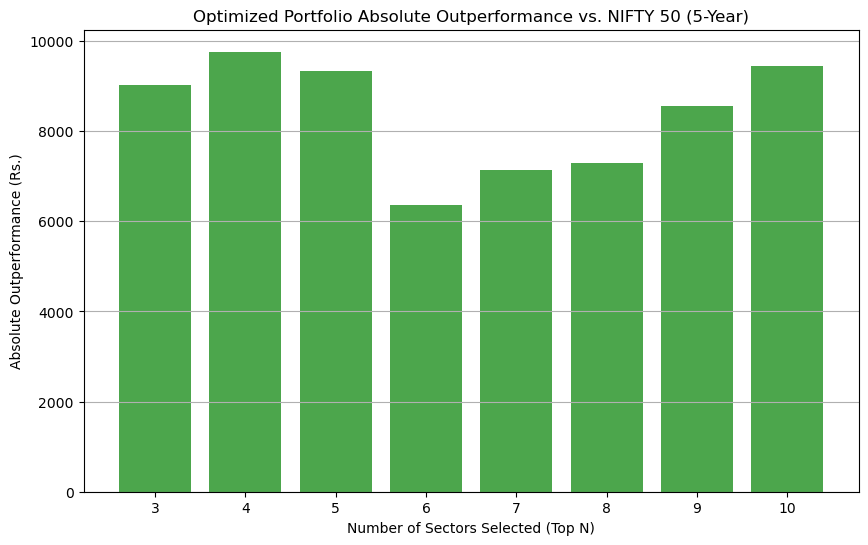


--- Investment Advice as of 2025-02-10 ---

Using training data from 2024-06-02 to 2025-02-09:

--- Top 3 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG']
Recommended Optimized Weights:
  ^CNXIT: 100.00%
  ^CNXSERVICE: 0.00%
  ^CNXFMCG: 0.00%
------------------------------------------------------------
--- Top 4 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK']
Recommended Optimized Weights:
  ^CNXIT: 100.00%
  ^CNXSERVICE: 0.00%
  ^CNXFMCG: 0.00%
  ^NSEBANK: 0.00%
------------------------------------------------------------
--- Top 5 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXFMCG', '^NSEBANK', '^CNXAUTO']
Recommended Optimized Weights:
  ^CNXIT: 100.00%
  ^CNXSERVICE: 0.00%
  ^CNXFMCG: 0.00%
  ^NSEBANK: 0.00%
  ^CNXAUTO: 0.00%
------------------------------------------------------------
--- Top 6 Sectors Recommendation ---
Selected Sectors: ['^CNXIT', '^CNXSERVICE', '^CNXF

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =============================================================================
# 1. Data Download and Setup for Sector Data
# =============================================================================

# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define the time period (last 5 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# Download data for each sector and store Adjusted Close prices
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        data_dict[ticker] = df['Adj Close']

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame and drop rows with missing data
prices = pd.DataFrame(data_dict).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# 2. (Optional) HRP Weight Calculation Function
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate HRP weights for a set of returns.
    (This function is kept for reference/comparison.)
    """
    corr = returns_df.corr()
    # Convert correlation to a distance metric
    dist = np.sqrt(0.5 * (1 - corr))
    # Compute hierarchical clustering using Ward linkage
    link = sch.linkage(ssd.squareform(dist), method='ward')
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    # Initialize equal weights and cluster sizes
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        left_size, right_size = cluster_sizes[left], cluster_sizes[right]
        weights[left] *= right_size / (left_size + right_size)
        weights[right] *= left_size / (left_size + right_size)
        cluster_sizes[left] += right_size
        cluster_sizes[right] += left_size
        
    return weights / weights.sum()

# =============================================================================
# 3. Mean–Variance Optimization Function
# =============================================================================
def optimize_portfolio(expected_returns, cov_matrix, q=1.0):
    """
    Optimizes the portfolio using a mean–variance framework.
    
    Parameters:
      expected_returns : array-like, expected return for each asset
      cov_matrix       : array-like, covariance matrix of asset returns
      q                : risk tolerance factor (higher q -> lower risk emphasis)
    
    Objective: minimize  -w.T*r + q * w.T*Sigma*w
    Subject to: sum(w) = 1, and 0 <= w <= 1 (no short selling)
    """
    n = len(expected_returns)
    init_guess = np.ones(n) / n
    
    def objective(w, expected_returns, cov_matrix, q):
        port_return = np.dot(w, expected_returns)
        port_variance = np.dot(w, np.dot(cov_matrix, w))
        return -port_return + q * port_variance
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(n)]
    
    result = minimize(objective, init_guess, args=(expected_returns, cov_matrix, q),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# =============================================================================
# 4. Mean–Variance Optimized Portfolio Rebalancing Simulation (Quarterly)
# =============================================================================

print("\n--- Mean–Variance Optimized Quarterly Rebalancing with Top N Sector Selection ---\n")

# Define the quarterly rebalancing dates
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')

initial_capital = 10000
results_summary = []       # For summary simulation results for each n
all_quarterly_results = {} # To store detailed results per quarter

# Loop over different top-N selections (e.g., n = 3,4,...,10)
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []  # To track each quarter's return
    quarterly_results = []  # Detailed info per quarter
    
    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    for i, q_end in enumerate(quarter_end_dates):
        # Define the rebalancing period: from previous quarter end + 1 day (or the start) to current quarter end
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break  # Not enough data
        
        # Use data prior to q_start for training (approximately the last 252 days ~1 year)
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        
        # Rank sectors by Sharpe ratio (mean/volatility) from training data and select top N
        sharpe_scores = training_returns.mean() / training_returns.std()
        selected_sectors = sharpe_scores.nlargest(n).index.tolist()
        
        # Estimate expected returns and covariance matrix for the selected sectors
        exp_returns = training_returns[selected_sectors].mean().values
        cov_matrix = training_returns[selected_sectors].cov().values
        
        # Set a risk tolerance factor (q); adjust as desired to tilt risk vs. return.
        q_val = 1.0
        opt_weights = optimize_portfolio(exp_returns, cov_matrix, q=q_val)
        opt_weights_series = pd.Series(opt_weights, index=selected_sectors)
        
        # Get period prices for the selected sectors during the rebalancing period
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        
        # Calculate portfolio return using the optimized weights
        portfolio_return = np.dot(opt_weights_series, sector_period_returns)
        cumulative_value *= (1 + portfolio_return)
        quarterly_returns.append(portfolio_return)
        
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'optimized_weights': opt_weights_series.to_dict(),
            'portfolio_return': portfolio_return,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value
        })
        
        # Print detailed quarterly info
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  Optimized Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {opt_weights_series[sector]:.2%}")
        print("  Sector Returns:")
        for sector, ret in sector_period_returns.items():
            print(f"    {sector}: {ret:.2%}")
        print(f"  Portfolio Return: {portfolio_return:.2%}")
        print(f"  Cumulative Value: Rs. {cumulative_value:,.2f}")
        print("-" * 80)
    
    # Annualized volatility from quarterly returns (4 quarters per year)
    if len(quarterly_returns) > 1:
        annualized_vol = np.std(quarterly_returns) * np.sqrt(4)
    else:
        annualized_vol = np.nan

    results_summary.append({
        'Number of Sectors': n,
        'Optimized Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

optimized_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for Optimized Portfolios (Top N Sectors) ===")
print(optimized_results_df[['Number of Sectors', 'Optimized Portfolio Value', 'Annualized Volatility']])

# =============================================================================
# 5. NIFTY Benchmark Analysis (Using Provided Code)
# =============================================================================

benchmark_ticker = "^NSEI"
end_date_bench = datetime.today()
time_periods = {f"{i} Years": end_date_bench - timedelta(days=365 * i) for i in range(1, 11)}
initial_capital_bench = 10000
benchmark_results = []

earliest_start = min(time_periods.values())
benchmark_data = yf.download(benchmark_ticker, start=earliest_start, end=end_date_bench, progress=False)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded. Check the ticker or network connection.")
benchmark_data = benchmark_data['Adj Close']

for period, start_dt in time_periods.items():
    filtered_data = benchmark_data[benchmark_data.index >= pd.Timestamp(start_dt)]
    if filtered_data.empty:
        continue
    
    start_price = filtered_data.iloc[0]
    end_price = filtered_data.iloc[-1]
    total_return = (end_price / start_price) - 1
    num_years = int(period.split()[0])
    cagr = ((end_price / start_price) ** (1 / num_years)) - 1
    final_value = initial_capital_bench * (1 + total_return)
    
    benchmark_results.append({
        'Time Period': period,
        'Start Price': start_price,
        'End Price': end_price,
        'Total Return (%)': total_return * 100,
        'CAGR (%)': cagr * 100,
        'Final Portfolio Value': final_value
    })

benchmark_results_df = pd.DataFrame(benchmark_results)
print("\n=== NIFTY 50 Benchmark Performance over Different Time Periods ===")
print(benchmark_results_df)

excel_filename = "NIFTY_Benchmark_Comparison.xlsx"
benchmark_results_df.to_excel(excel_filename, index=False)
print(f"\nNIFTY Benchmark results saved to {excel_filename}")

plt.figure(figsize=(12, 6))
plt.plot(benchmark_results_df['Time Period'], benchmark_results_df['CAGR (%)'], marker='o', linestyle='-', color='b', label='CAGR')
plt.xlabel("Time Period")
plt.ylabel("CAGR (%)")
plt.title("CAGR of NIFTY 50 over Different Time Periods")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# =============================================================================
# 6. Comparison Analysis: Optimized Portfolio vs. NIFTY Benchmark (5-Year)
# =============================================================================

bench_5yr = benchmark_results_df[benchmark_results_df["Time Period"] == "5 Years"]
if bench_5yr.empty:
    raise ValueError("5-Year benchmark data not available.")
nifty_5yr_final = bench_5yr.iloc[0]['Final Portfolio Value']

comparison_df = optimized_results_df.copy()
comparison_df['NIFTY 5-Year Value'] = nifty_5yr_final
comparison_df['Absolute Outperformance'] = comparison_df['Optimized Portfolio Value'] - nifty_5yr_final
comparison_df['Percentage Outperformance (%)'] = (comparison_df['Absolute Outperformance'] / nifty_5yr_final) * 100

print("\n=== Comparison: Optimized Portfolio vs. NIFTY 50 (5-Year) ===")
print(comparison_df[['Number of Sectors', 'Optimized Portfolio Value', 'NIFTY 5-Year Value', 
                     'Absolute Outperformance', 'Percentage Outperformance (%)']])

plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Number of Sectors'], comparison_df['Absolute Outperformance'], color='green', alpha=0.7)
plt.xlabel("Number of Sectors Selected (Top N)")
plt.ylabel("Absolute Outperformance (Rs.)")
plt.title("Optimized Portfolio Absolute Outperformance vs. NIFTY 50 (5-Year)")
plt.grid(axis='y')
plt.show()

# =============================================================================
# 7. Investment Advice for Today (Using Last 1 Year Data)
# =============================================================================

# Suppose today's date is Feb 10, 2025.
advice_date = datetime(2025, 2, 10)
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---\n")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")

q_val_advice = 1.0  # risk tolerance for advice; adjust as needed
for n in range(3, 11):
    sharpe_scores = advice_training_returns.mean() / advice_training_returns.std()
    top_n_sectors = sharpe_scores.nlargest(n).index.tolist()
    exp_returns = advice_training_returns[top_n_sectors].mean().values
    cov_matrix = advice_training_returns[top_n_sectors].cov().values
    opt_weights = optimize_portfolio(exp_returns, cov_matrix, q=q_val_advice)
    opt_weights_series = pd.Series(opt_weights, index=top_n_sectors)
    
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended Optimized Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {opt_weights_series[sector]:.2%}")
    print("-" * 60)